# Multimodal Data Processing with Pixeltable and Backblaze B2

## Extract video frames and store in Backblaze B2

Learn how to process video files with **[Pixeltable](https://www.pixeltable.com/)** and store the results in **[Backblaze B2](https://www.backblaze.com/cloud-storage)**  cloud storage.

**What you'll build:**
- Set up [Pixeltable](https://www.pixeltable.com/) with [Backblaze B2](https://www.backblaze.com/cloud-storage)  integration
- Create a video table and load video files
- Extract frames from video at specific intervals
- Convert frames to grayscale
- Store grayscale frames in Backblaze B2 with automatic URL generation
- (Bonus) Use AI to edit frames with [Reve](https://reve.com/) and store edited images to B2

## About Pixeltable

**[Pixeltable](https://www.pixeltable.com/)** is an open-source AI data infrastructure that provides:
- **Computed Columns:** Automatically process data through AI models and transformations ([docs](https://docs.pixeltable.com/overview/pixeltable))
- **Multimodal Support:** Native handling of images, video, audio, and documents
- **Persistent Storage:** Everything is stored in a database that survives restarts
- **Declarative Storage:** Simply specify where to store data—Pixeltable handles uploads and URL generation

Learn more in the [Pixeltable documentation](https://docs.pixeltable.com/overview/pixeltable).

## About Backblaze B2

**[Backblaze B2](https://www.backblaze.com/cloud-storage)**  is S3-compatible cloud storage that's cost-effective and simple. In this notebook, we use it to store processed outputs like extracted frames and transformed images. Pixeltable automatically detects B2 endpoints when you use `https://s3.{region}.backblazeb2.com/` URLs, making it seamless to integrate B2 into your data pipelines.

Learn more in the **[Backblaze B2 Cloud Storage API Documentation](https://www.backblaze.com/apidocs)**.

**Key benefits of using B2 with Pixeltable:**
- **S3-compatible API** - Works seamlessly with Pixeltable's storage system
- **Cost-effective** - Competitive pricing for cloud storage
- **Simple setup** - Just provide your B2 credentials and Pixeltable handles the rest
- **Automatic URL generation** - Pixeltable generates servable URLs for all stored files

**Prerequisites:** Backblaze B2 account (free tier available), Python 3.9+

## Setup

### Set up Backblaze B2

Backblaze B2 is S3-compatible, so we use your B2 credentials as AWS credentials. Pixeltable automatically detects B2 endpoints when you use `https://s3.{region}.backblazeb2.com/` URLs for destinations.

**Step 1: Get your B2 credentials**
- Go to [Backblaze B2 dashboard](https://secure.backblaze.com/user_signin.htm) → Account → Application Keys
- Click "Add a New Application Key"
- Select your bucket with read/write permissions (note the bucket name - you'll need it for the destination URLs)
- Copy both values immediately (the applicationKey is only shown once):
  - keyID (identifier, starts with numbers)
  - applicationKey (secret key, starts with K00)

**Step 2: Run the cell below** to enter your credentials, bucket name, and set them as AWS environment variables.

In [1]:
# Enter your Backblaze B2 credentials
import os
from getpass import getpass

print('Enter your Backblaze B2 credentials:')
print('1. First, enter your keyID (identifier, starts with numbers)')
KEY_ID = os.getenv('B2_KEY_ID') or input('   keyID: ').strip()

print('2. Now, enter your applicationKey (secret key, starts with K00)')
APPLICATION_KEY = os.getenv('B2_APPLICATION_KEY') or getpass('   applicationKey: ').strip()

print('3. Enter your B2 region (e.g., us-west-004, press Enter for default)')
B2_REGION = os.getenv('B2_REGION') or input('   region: ').strip() or 'us-west-004'

print('4. Enter your B2 bucket name')
B2_BUCKET = os.getenv('B2_BUCKET') or input('   bucket name: ').strip()

if not KEY_ID or not APPLICATION_KEY:
    raise ValueError('Both keyID and applicationKey must be provided')
if not B2_BUCKET:
    raise ValueError('B2 bucket name must be provided')

# Set as AWS credentials (Backblaze B2 is S3-compatible)
# Pixeltable will automatically detect B2 endpoints from https:// URLs
os.environ['AWS_ACCESS_KEY_ID'] = KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = APPLICATION_KEY
os.environ['AWS_DEFAULT_REGION'] = B2_REGION

# Store B2_REGION and BUCKET for constructing destination URLs
B2_ENDPOINT = f'https://s3.{B2_REGION}.backblazeb2.com'

print(f'✓ Backblaze B2 configured (endpoint: {B2_ENDPOINT}, bucket: {B2_BUCKET})')

Enter your Backblaze B2 credentials:
1. First, enter your keyID (identifier, starts with numbers)
2. Now, enter your applicationKey (secret key, starts with K00)
3. Enter your B2 region (e.g., us-west-004, press Enter for default)
4. Enter your B2 bucket name
✓ Backblaze B2 configured (endpoint: https://s3.us-east-005.backblazeb2.com, bucket: pxt-test)


### Dependencies

This notebook uses `uv` for dependency management. Set up your environment using one of the methods below.

**Option 1: Using uv (Recommended)**

If you have `uv` installed, run this in your terminal:
```bash
uv sync
```

This will:
- Create a virtual environment (`.venv`) based on `pyproject.toml` and `uv.lock`
- Install all required dependencies

Then activate the virtual environment:
```bash
# On macOS/Linux:
source .venv/bin/activate

# On Windows:
.venv\Scripts\activate
```

**Option 2: Using pip**

Alternatively, you can install dependencies directly with pip (see cell below).

In [10]:
# Install required packages (if not using uv sync)
# If you used uv sync, you can skip this cell
%pip install -qU pixeltable
%pip install -qU boto3

/Users/jdeleon/Documents/oss/b2-pixeltable/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.
/Users/jdeleon/Documents/oss/b2-pixeltable/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [3]:
import pixeltable as pxt
from getpass import getpass
from datetime import datetime
import os

## Create video table

There are two ways to get started with the video table:

**Option A: Replicate from [Pixeltable Cloud](https://www.pixeltable.com/) (Recommended)**

Replicate a pre-configured table from [Pixeltable Cloud](https://www.pixeltable.com/) that already contains the video file. This is the fastest way to get started.

**Option B: Create a new table locally**

Create a new table locally and insert the video file yourself. Use this option if you want to start from scratch or use your own video file.

Choose one of the options below to proceed.

### Option A: Replicate from [Pixeltable Cloud](https://www.pixeltable.com/)

Replicate the pre-configured table from [Pixeltable Cloud](https://www.pixeltable.com/). This table already contains the video file, so you can skip directly to frame extraction.

- **View the table:** [octopus_teacher_trailer](https://www.pixeltable.com/t/pixeltable:partners/b2/octopus_teacher_trailer)
- **Learn more about replicating:** [Data Sharing Documentation](https://docs.pixeltable.com/notebooks/feature-guides/data-sharing#working-with-replicas)

In [ ]:
# Replicate this table to your local environment
octo_replica = pxt.replicate(
    remote_uri='pxt://pixeltable:partners/b2/octopus_teacher_trailer',
    local_path='local_octo_vid'  # Your local table name
)

Next, you'll create a fresh new table from the replica. Replicas are read-only, so this allows you have a writeable copy with values only.

In [ ]:
# Create a Pixeltable table with the replica as source
octo_vid = pxt.create_table(
    'octopus_teacher_trailer',
    source=octo_replica
)

If you used Option A, skip to the "From video to frames" section below. Otherwise, continue with Option B.


### Option B: Create a new table locally

Create a new table locally and insert your own video file.

In [4]:
# Create a Pixeltable table with a video column
octo_vid = pxt.create_table(
    'octopus_teacher_trailer',
    {'video': pxt.Video},
    if_exists='replace'
)

Creating a Pixeltable instance at: /Users/jdeleon/.pixeltable
Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/jdeleon/.pixeltable/pgdata
Created table 'octopus_teacher_trailer'.


Insert octopus.mp4 as a video into our table.


In [5]:
octo_vid.insert([{'video': 'sources/octopus.mp4'}])

Inserting rows into `octopus_teacher_trailer`: 1 rows [00:00, 481.00 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

## From video to frames

Now we can see the video, ready for processing:


video
0  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...
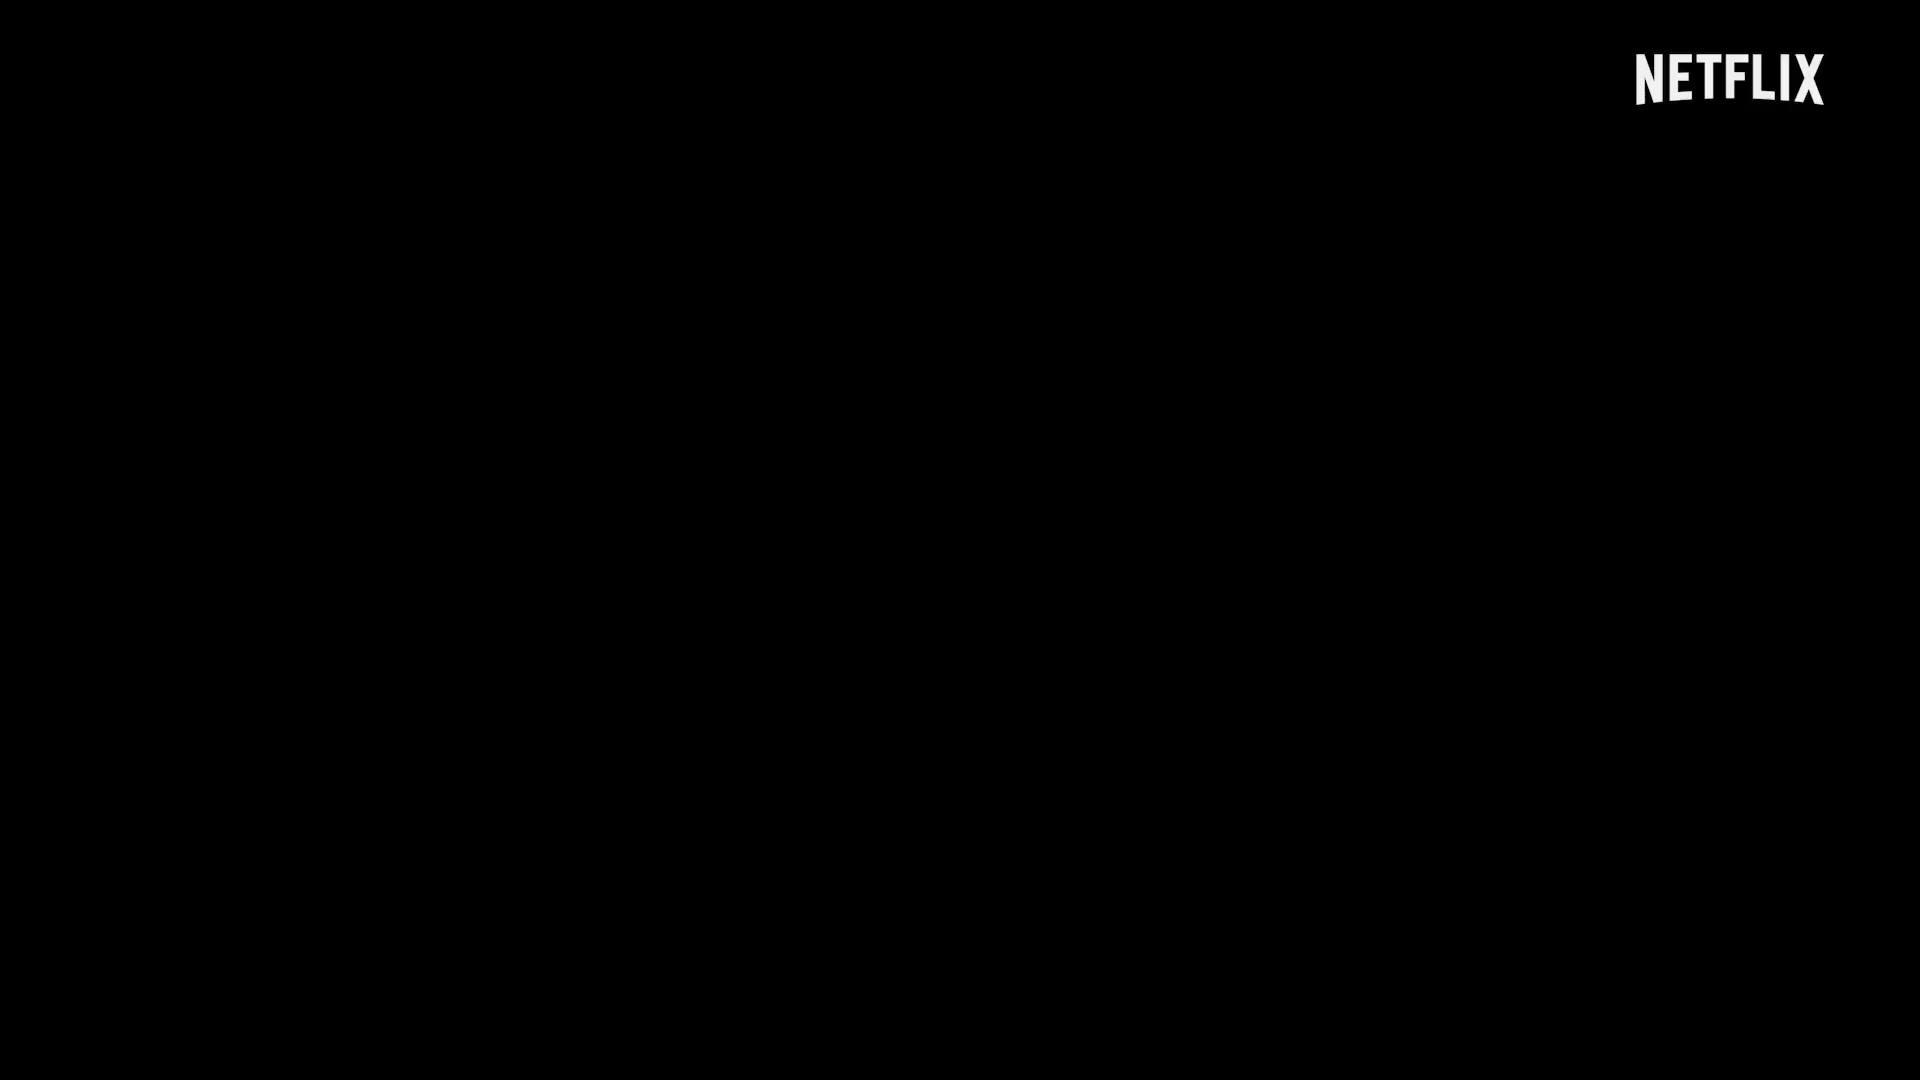

In [6]:
octo_vid.collect()

We will extract frames from the video, sampling one frame approximately every 15 seconds.

In [7]:
from pixeltable.iterators import FrameIterator

# Extract frames approximately every 15 seconds
octo_frames_v = pxt.create_view(
    'octopus_teacher_frames',
    octo_vid,
    iterator=FrameIterator.create(
        video=octo_vid.video,
        fps=0.0667  # Extract 1 frame every 15 seconds (1 / 15)
    ),
    if_exists='replace'
)

Inserting rows into `octopus_teacher_frames`: 10 rows [00:00, 4458.71 rows/s]


Iterators in Pixeltable are table-generating functions - we can see the new table we have created in this view. Remember, we started with a single video in a single row. The iterator shredded the video into frames using our `fps` parameter to specify frames per second. In this view, each row is one of those frames. There is also an implicit join here with the base table so you always keep your context with you. This does not mean that the source video is copied multiple times. Instead, Pixeltable references the same media file across rows.

pos  frame_idx  pos_msec  pos_frame  \
0    0          0       0.0          0   
1    1          1   15000.0        375   
2    2          2   30000.0        750   
3    3          3   44960.0       1124   
4    4          4   59960.0       1499   
5    5          5   74960.0       1874   
6    6          6   89960.0       2249   
7    7          7  104960.0       2624   
8    8          8  119960.0       2999   
9    9          9  134920.0       3373   

                                               frame  \
0  <PIL.Image.Image image mode=RGB size=1920x1080...   
1  <PIL.Image.Image image mode=RGB size=1920x1080...   
2  <PIL.Image.Image image mode=RGB size=1920x1080...   
3  <PIL.Image.Image image mode=RGB size=1920x1080...   
4  <PIL.Image.Image image mode=RGB size=1920x1080...   
5  <PIL.Image.Image image mode=RGB size=1920x1080...   
6  <PIL.Image.Image image mode=RGB size=1920x1080...   
7  <PIL.Image.Image image mode=RGB size=1920x1080...   
8  <PIL.Image.Image image mode=RGB size=1920x1080...   
9  <PIL.Image.Image image mode=RGB size=1920x1080...   

                                               video  
0  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
1  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
2  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
3  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
4  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
5  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
6  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
7  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
8  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
9  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...
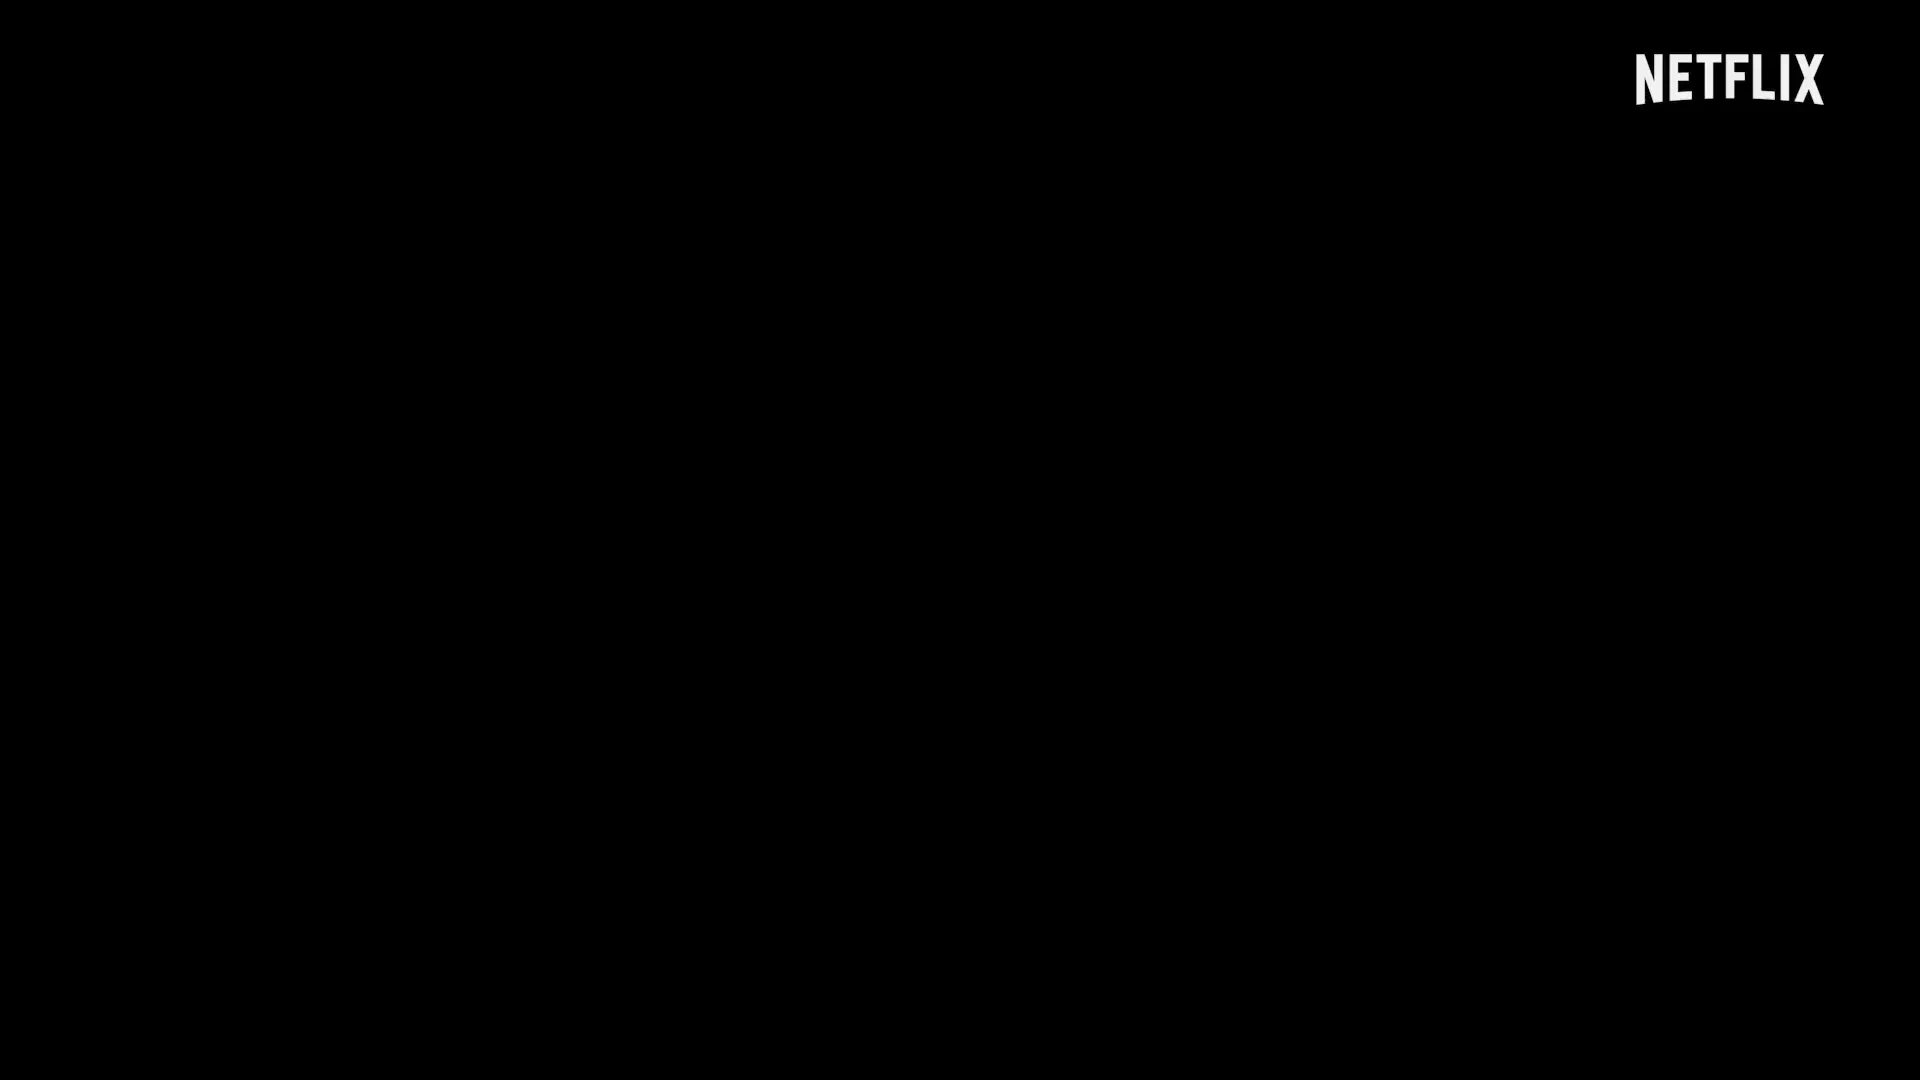
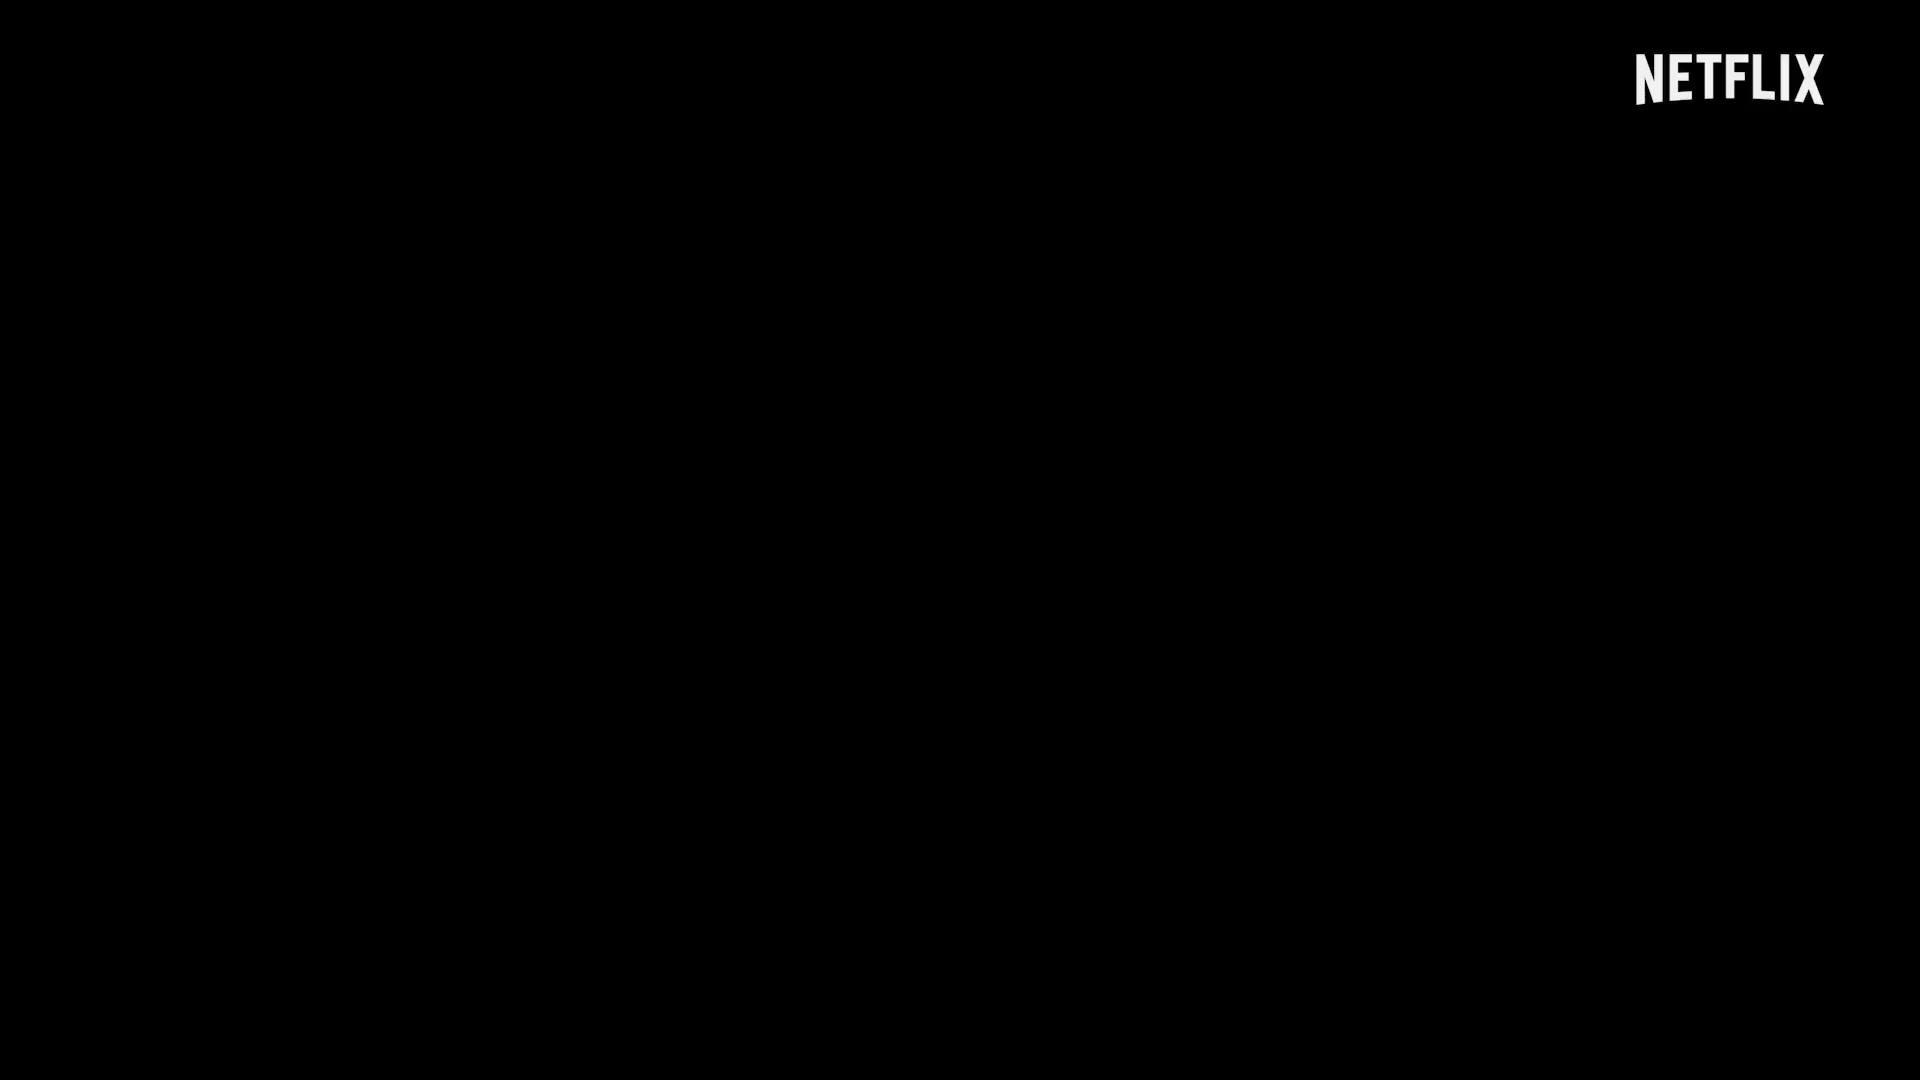
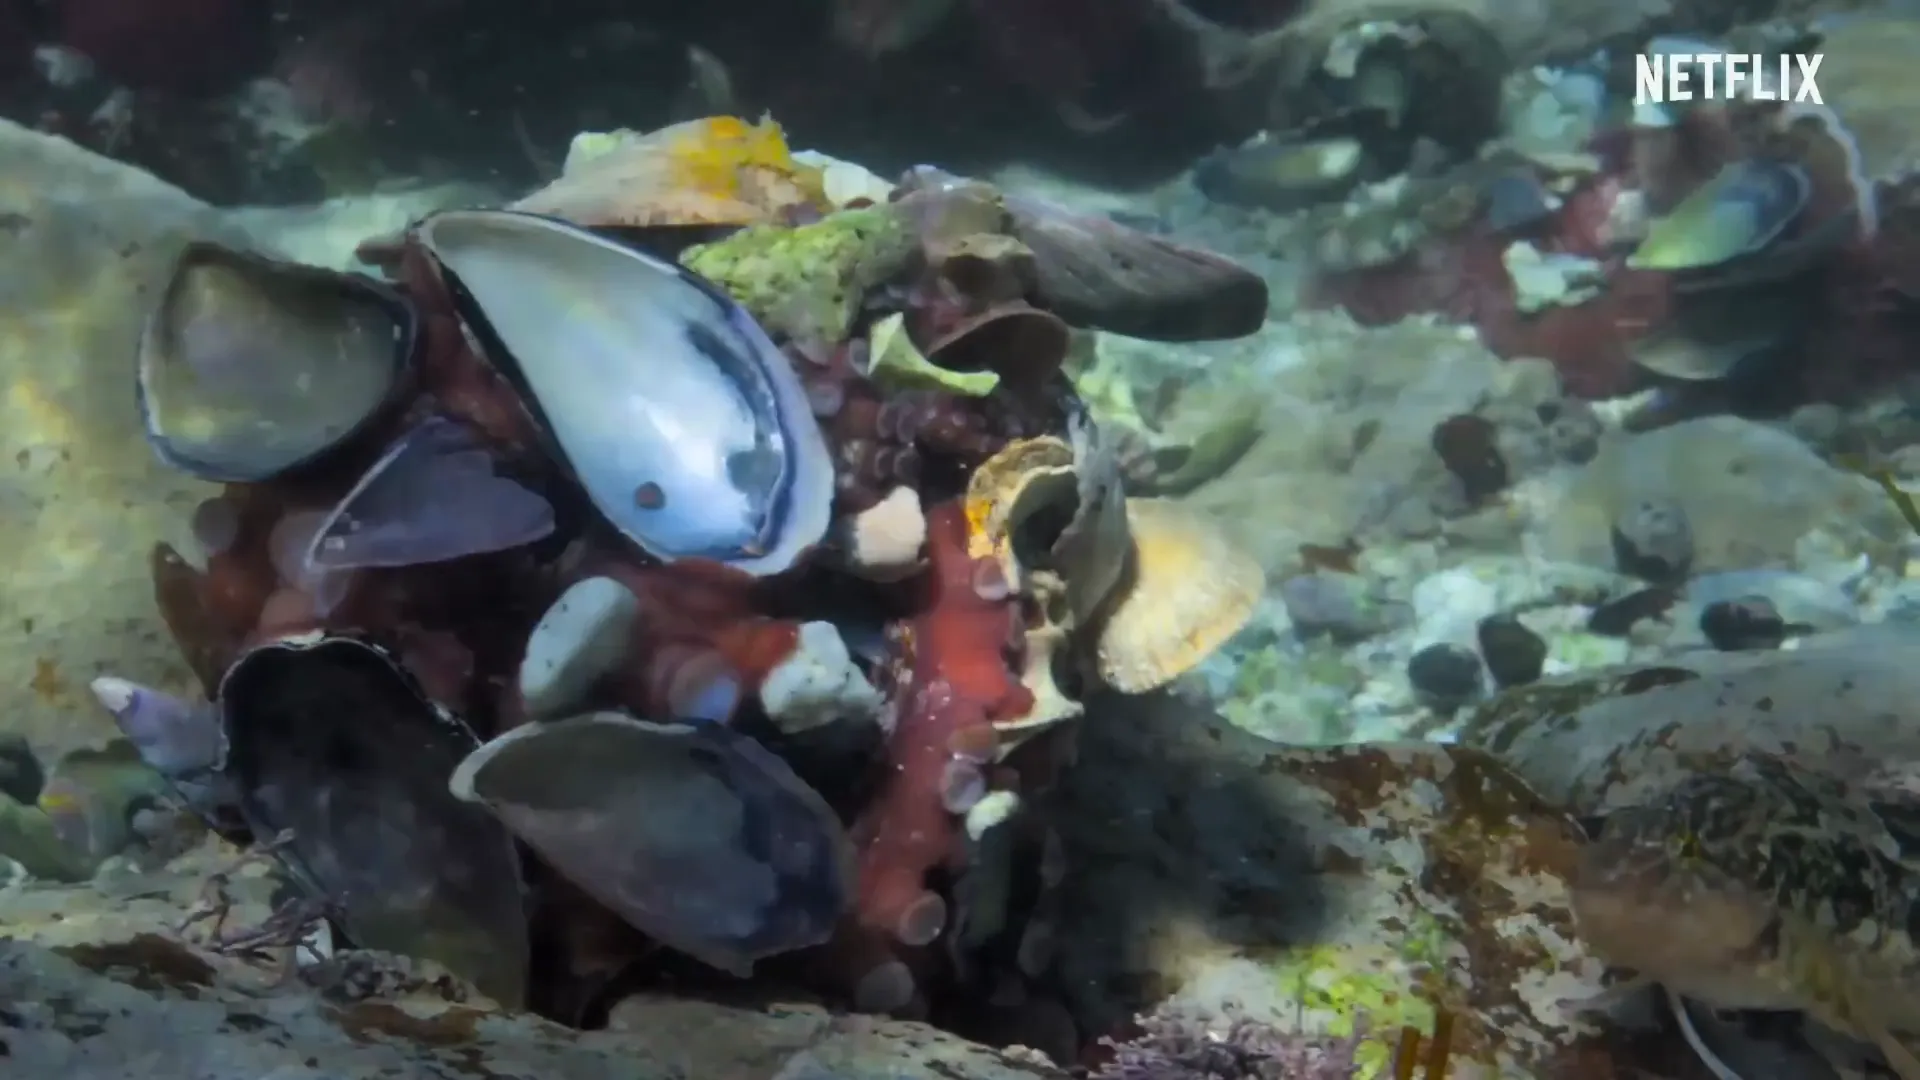
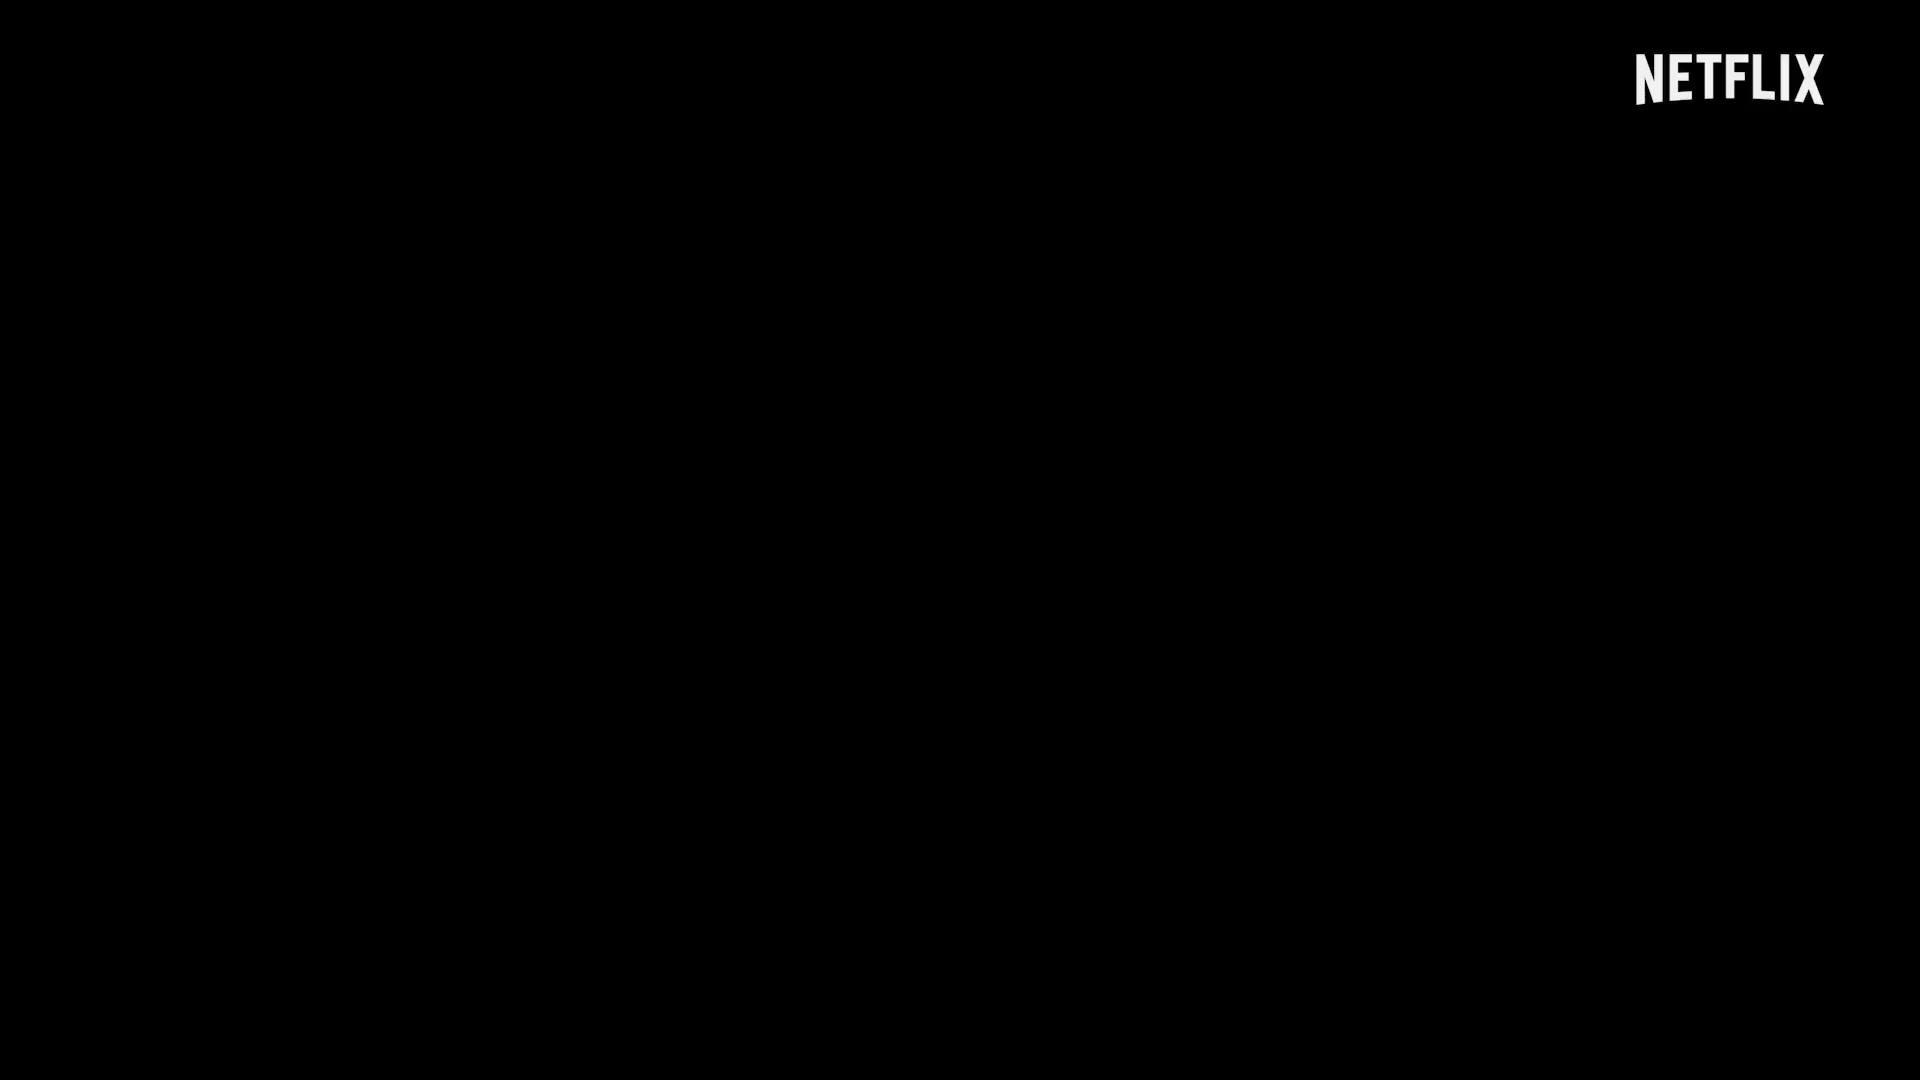
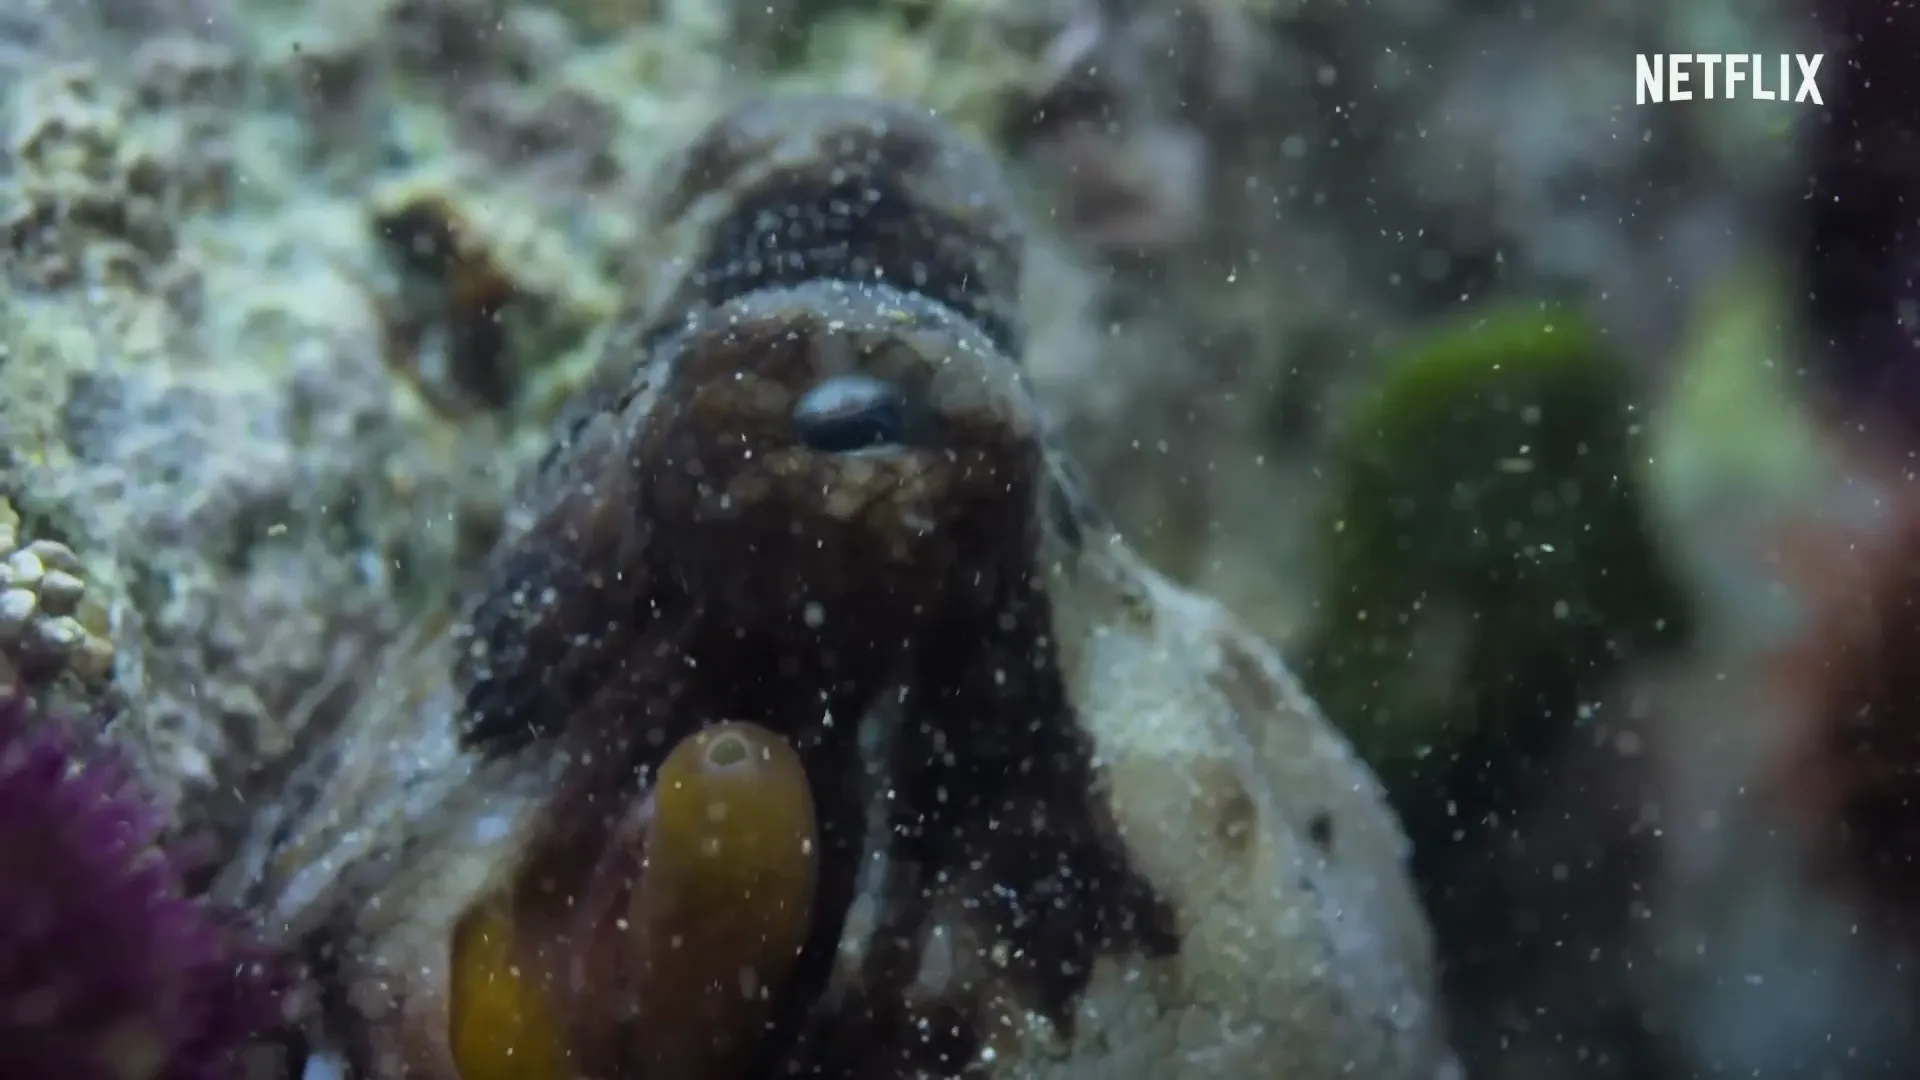
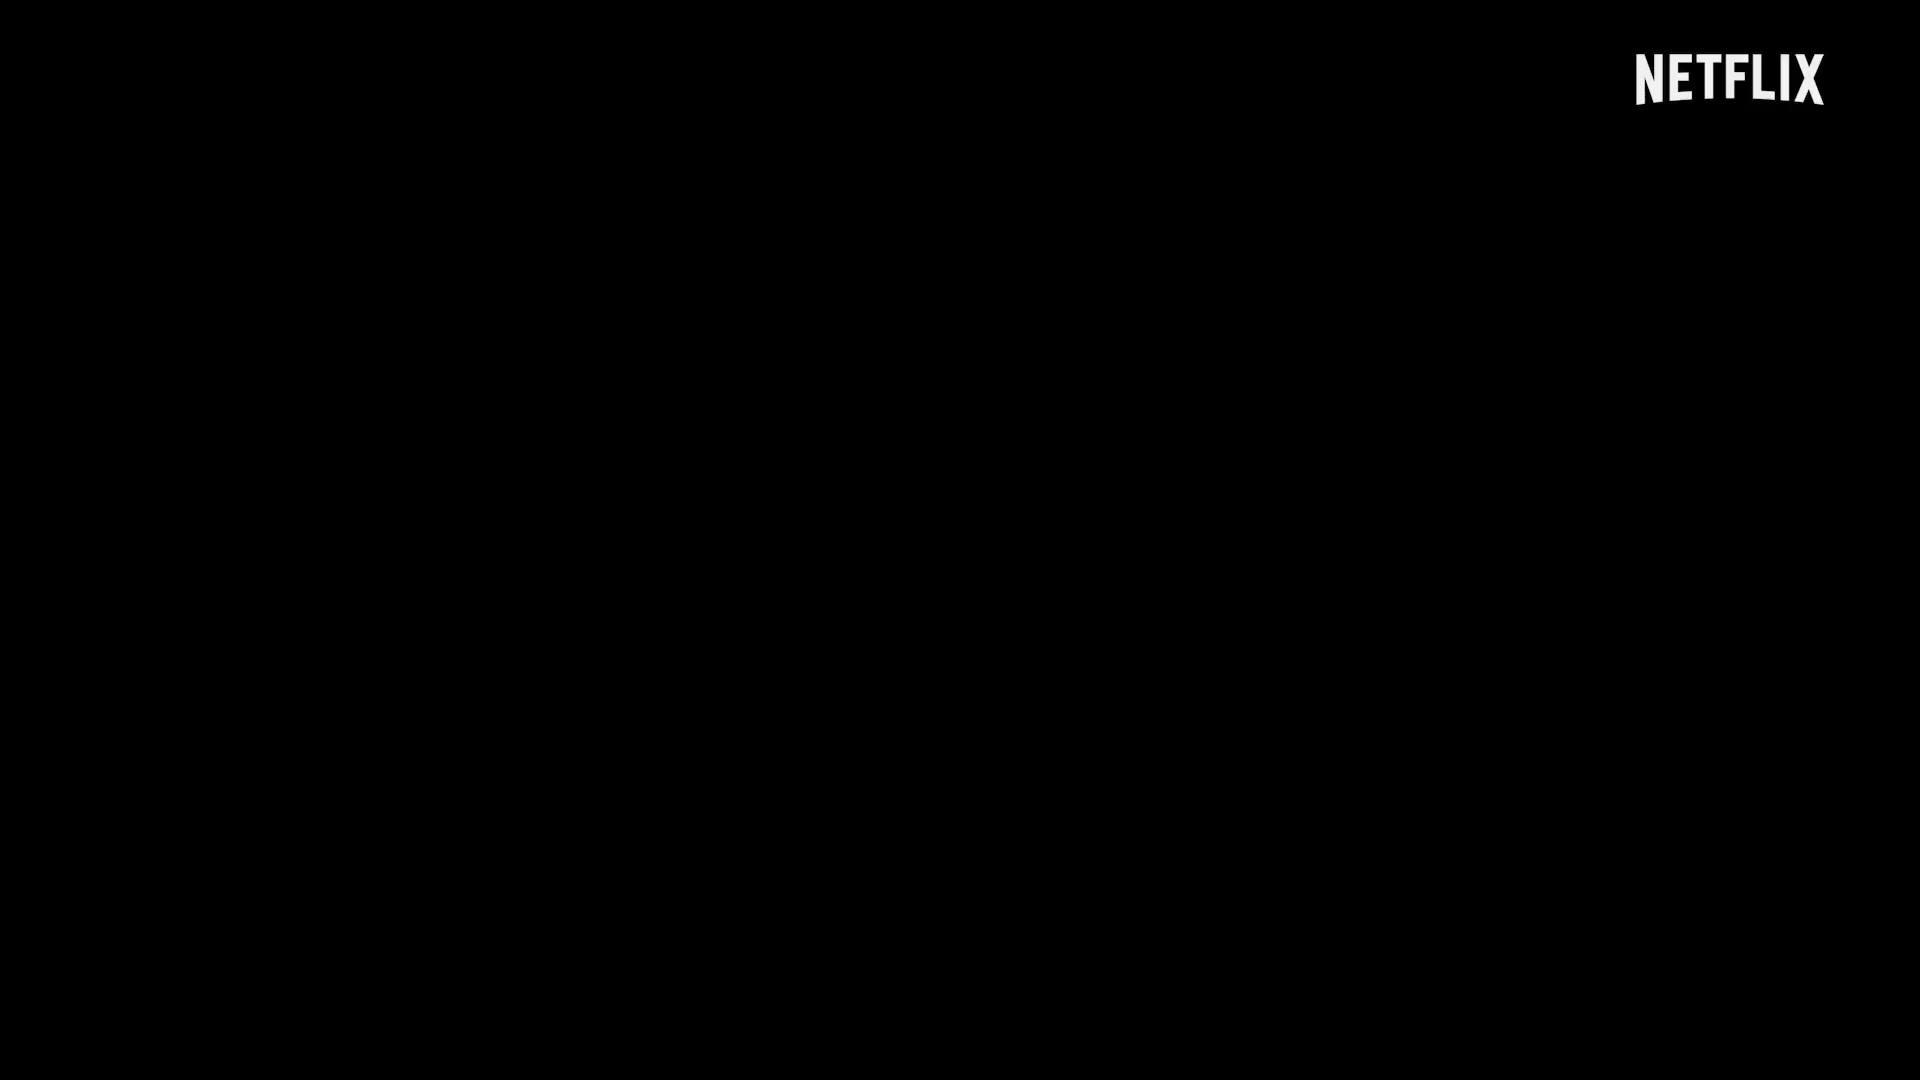
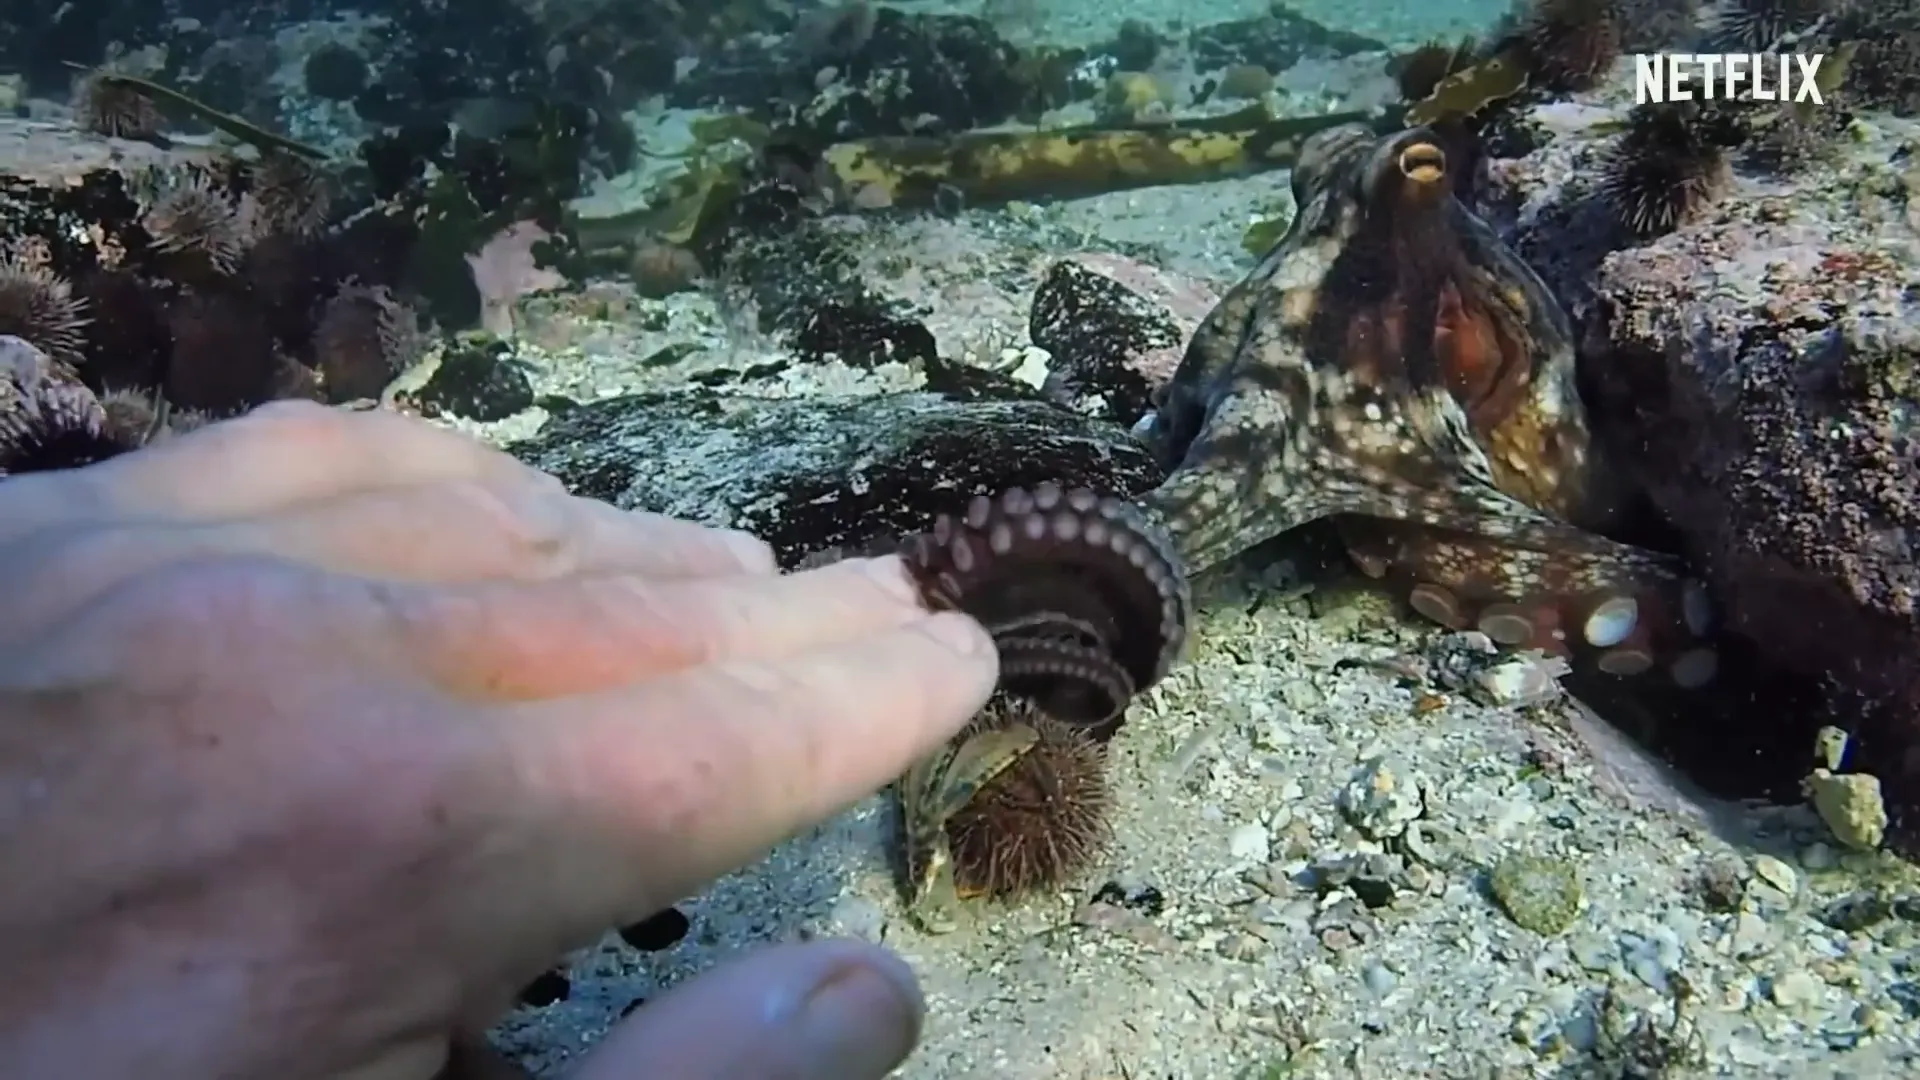
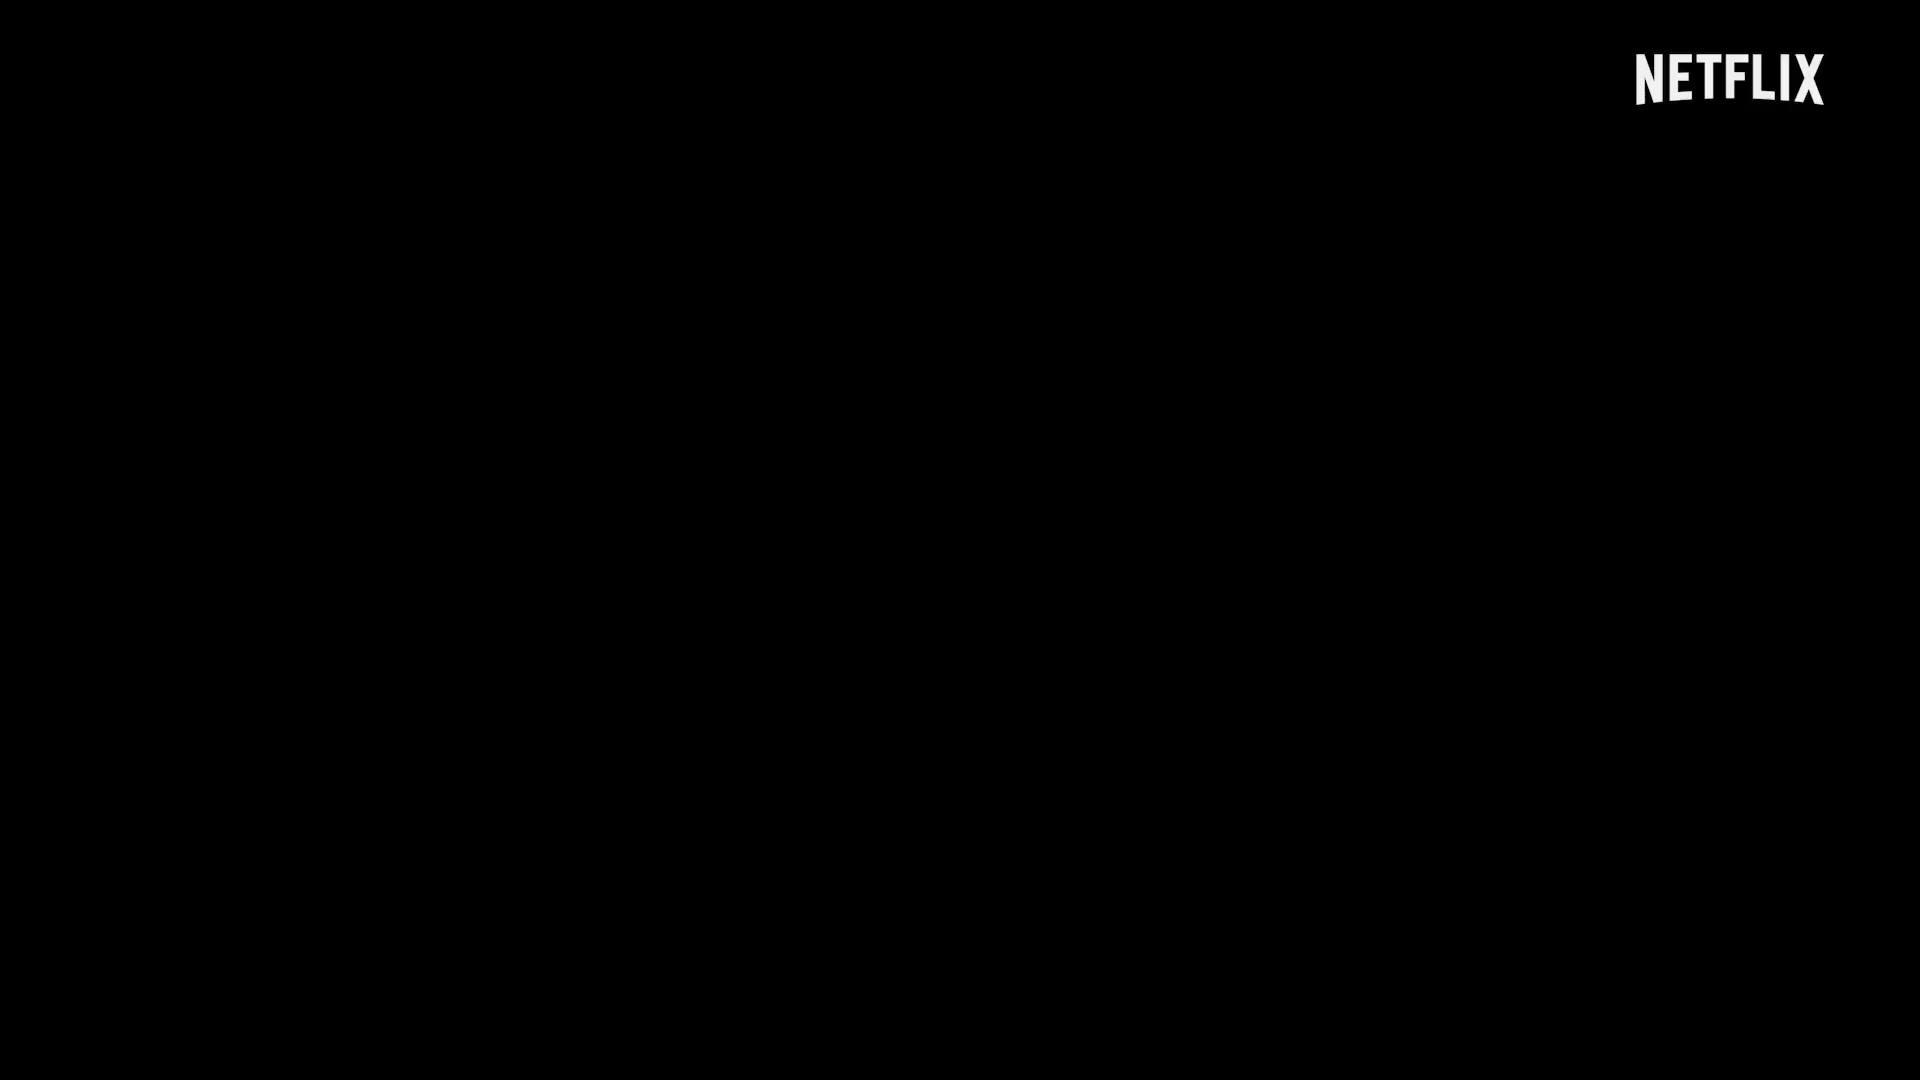
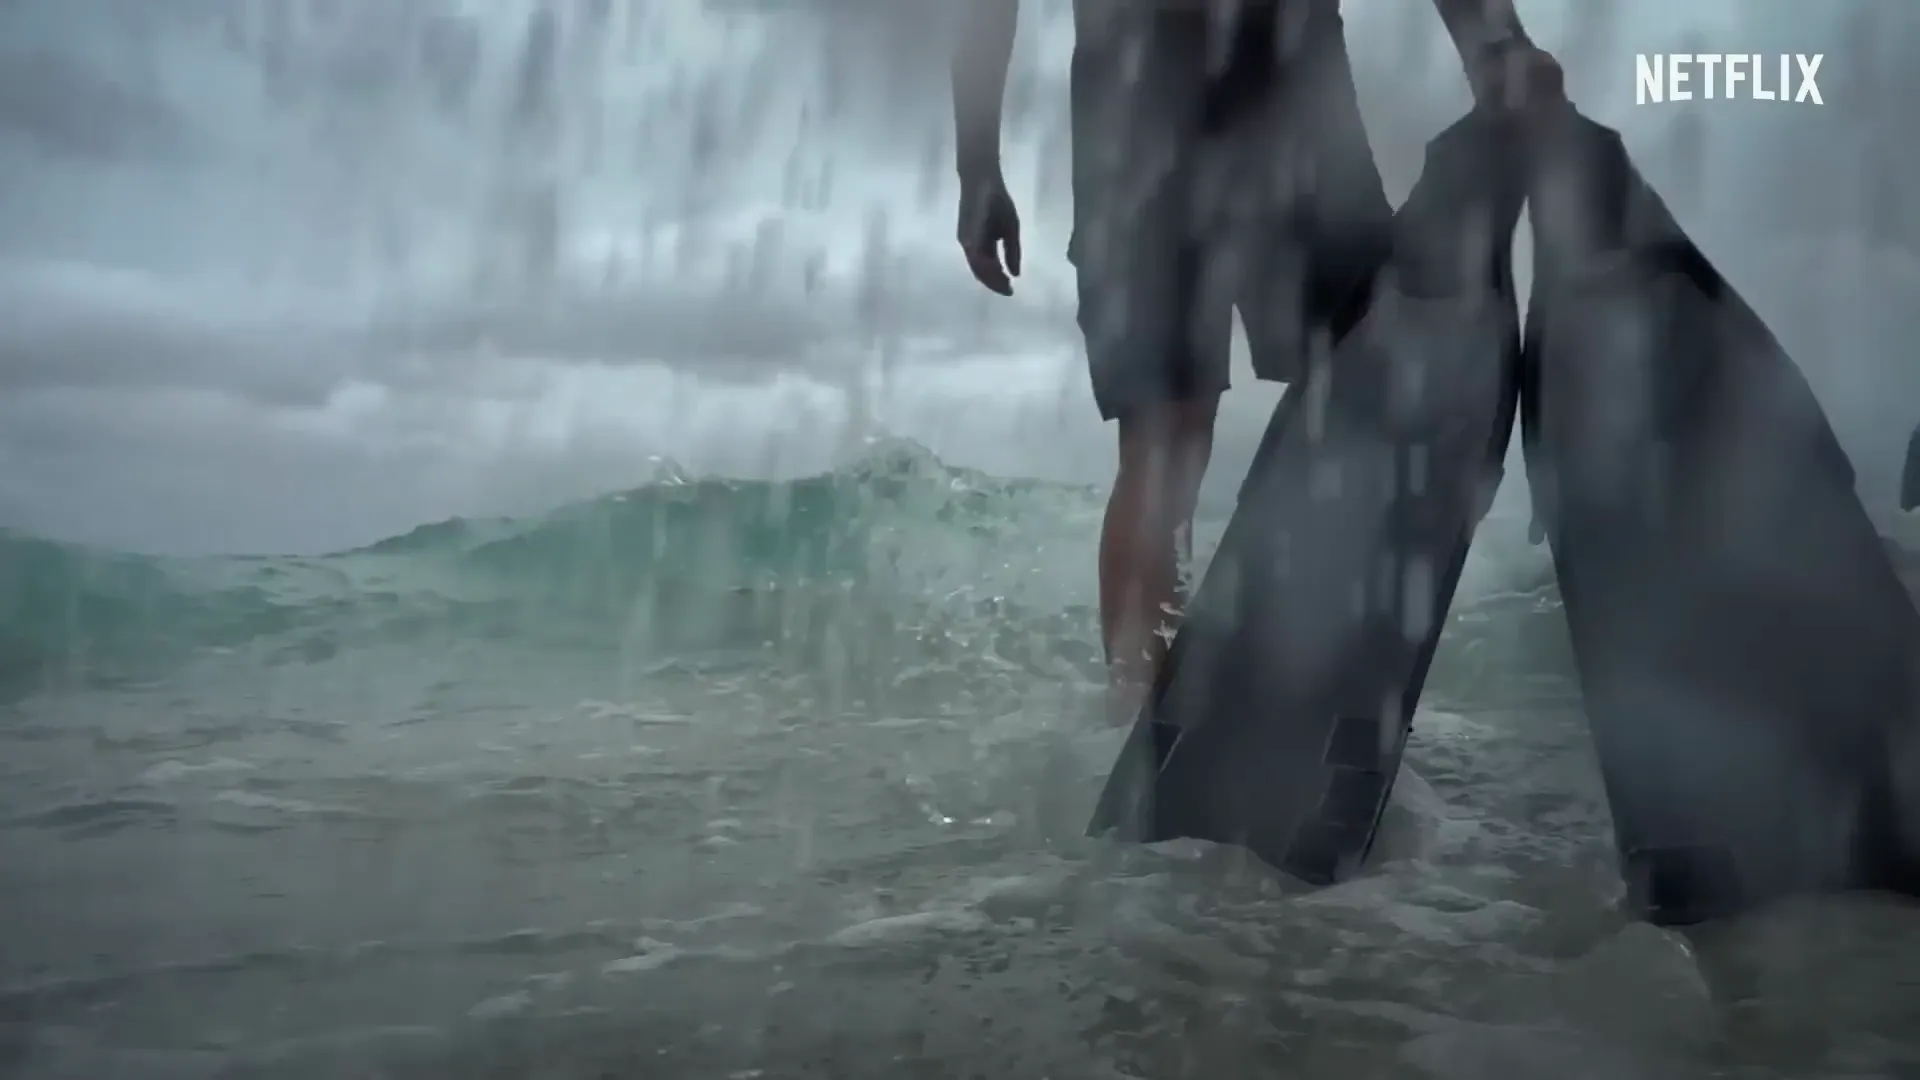
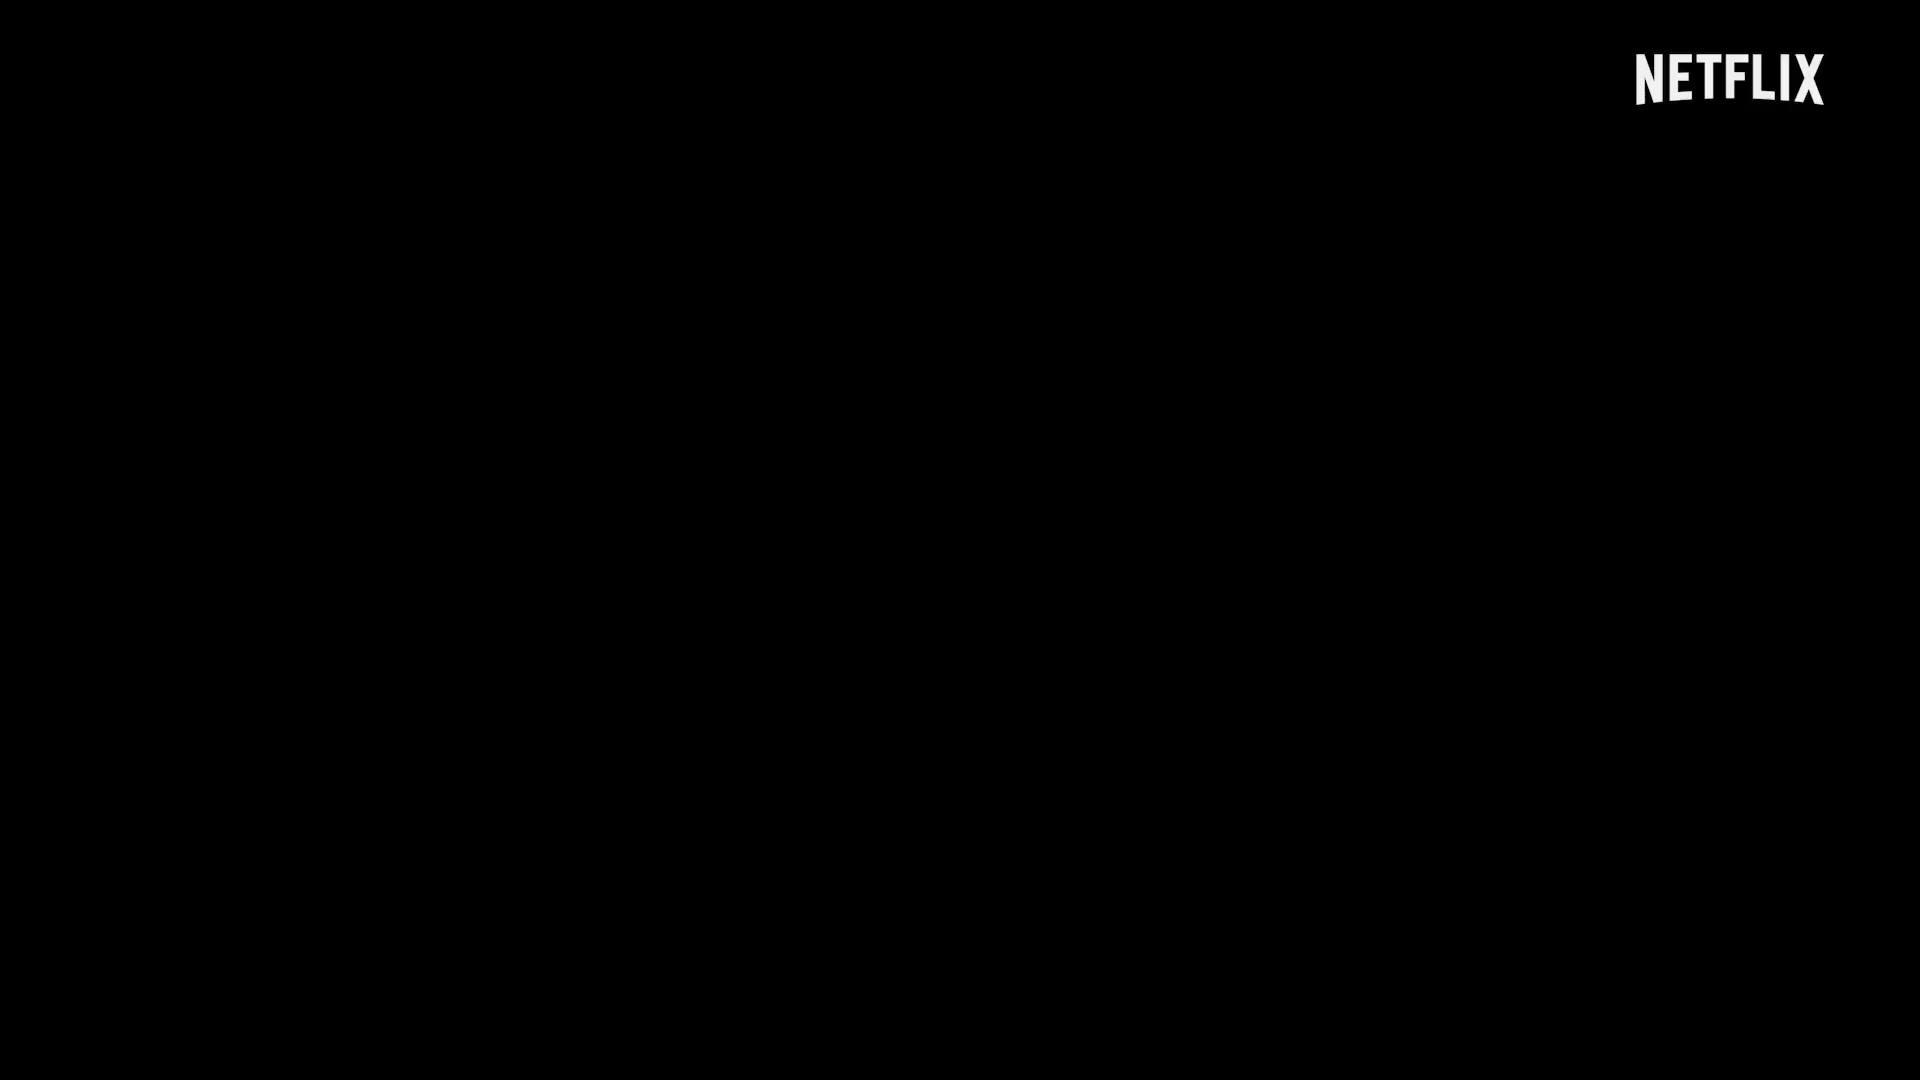
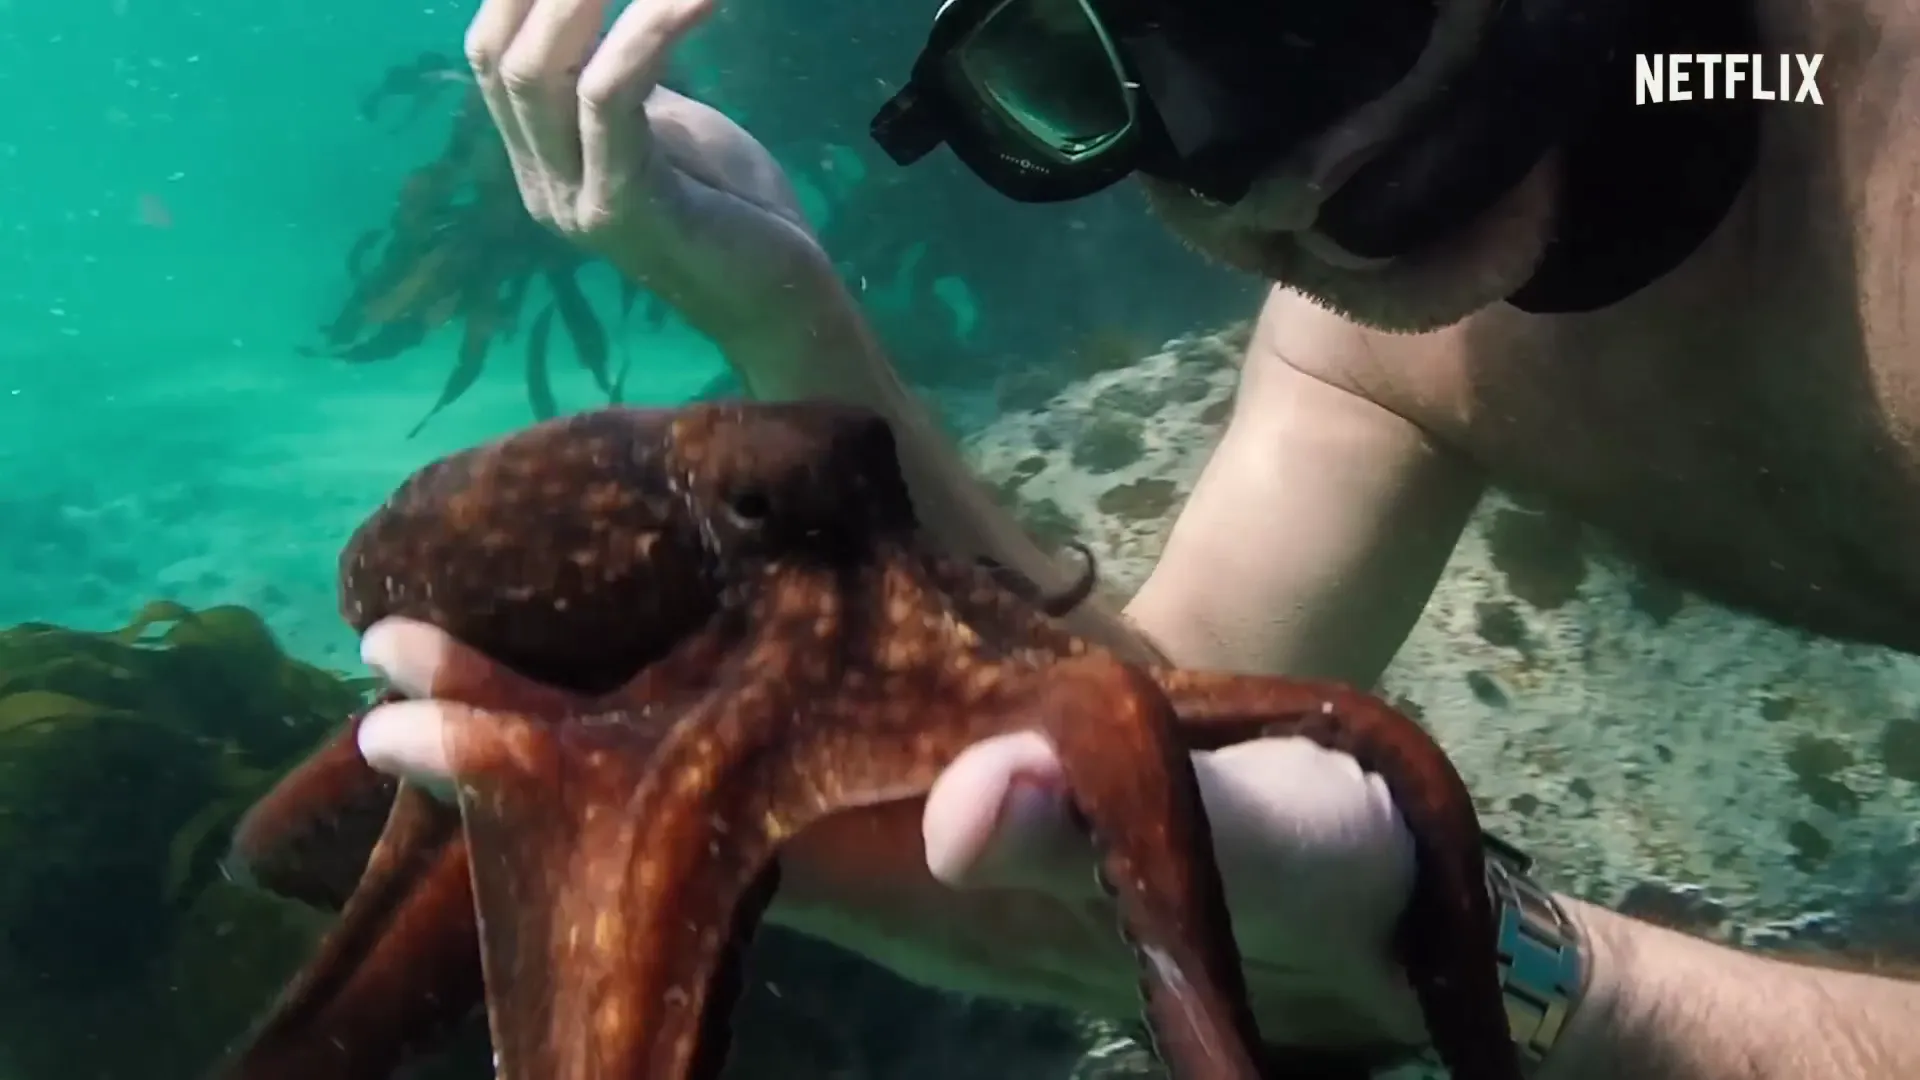
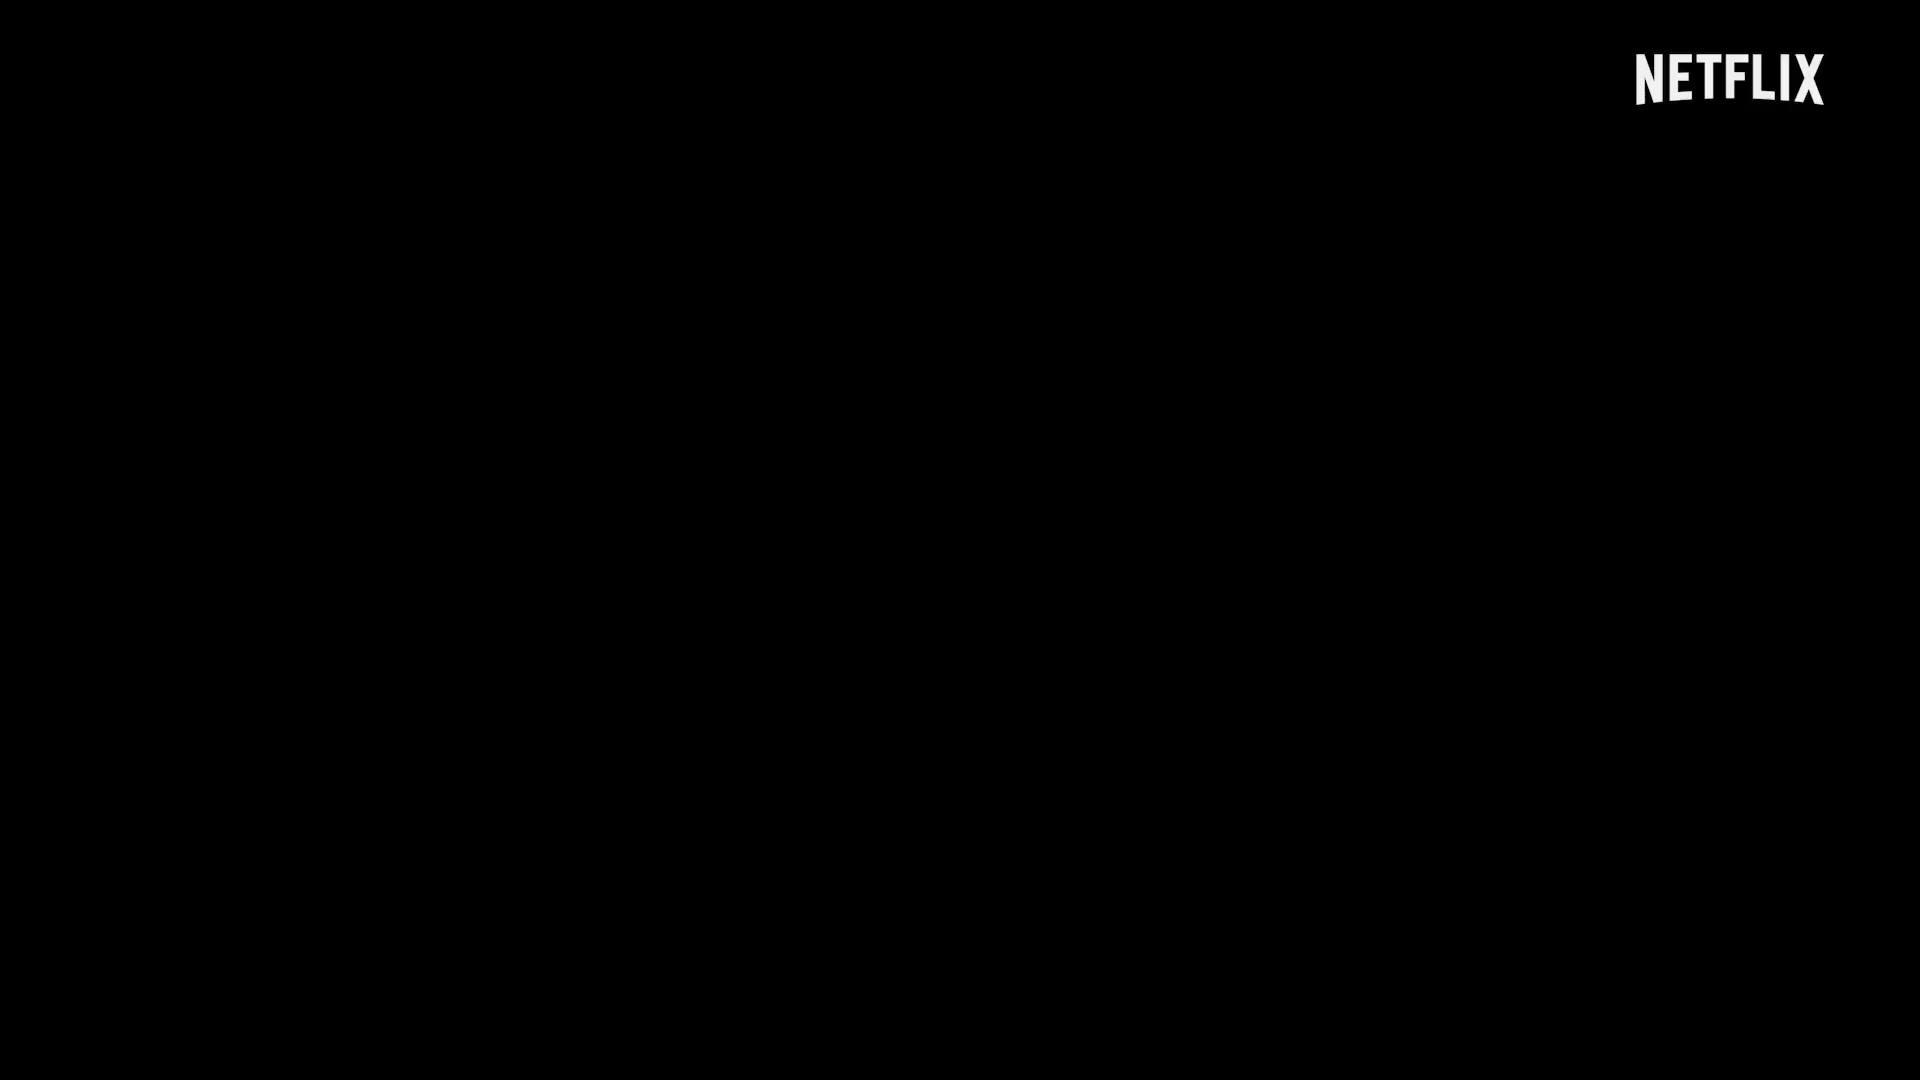
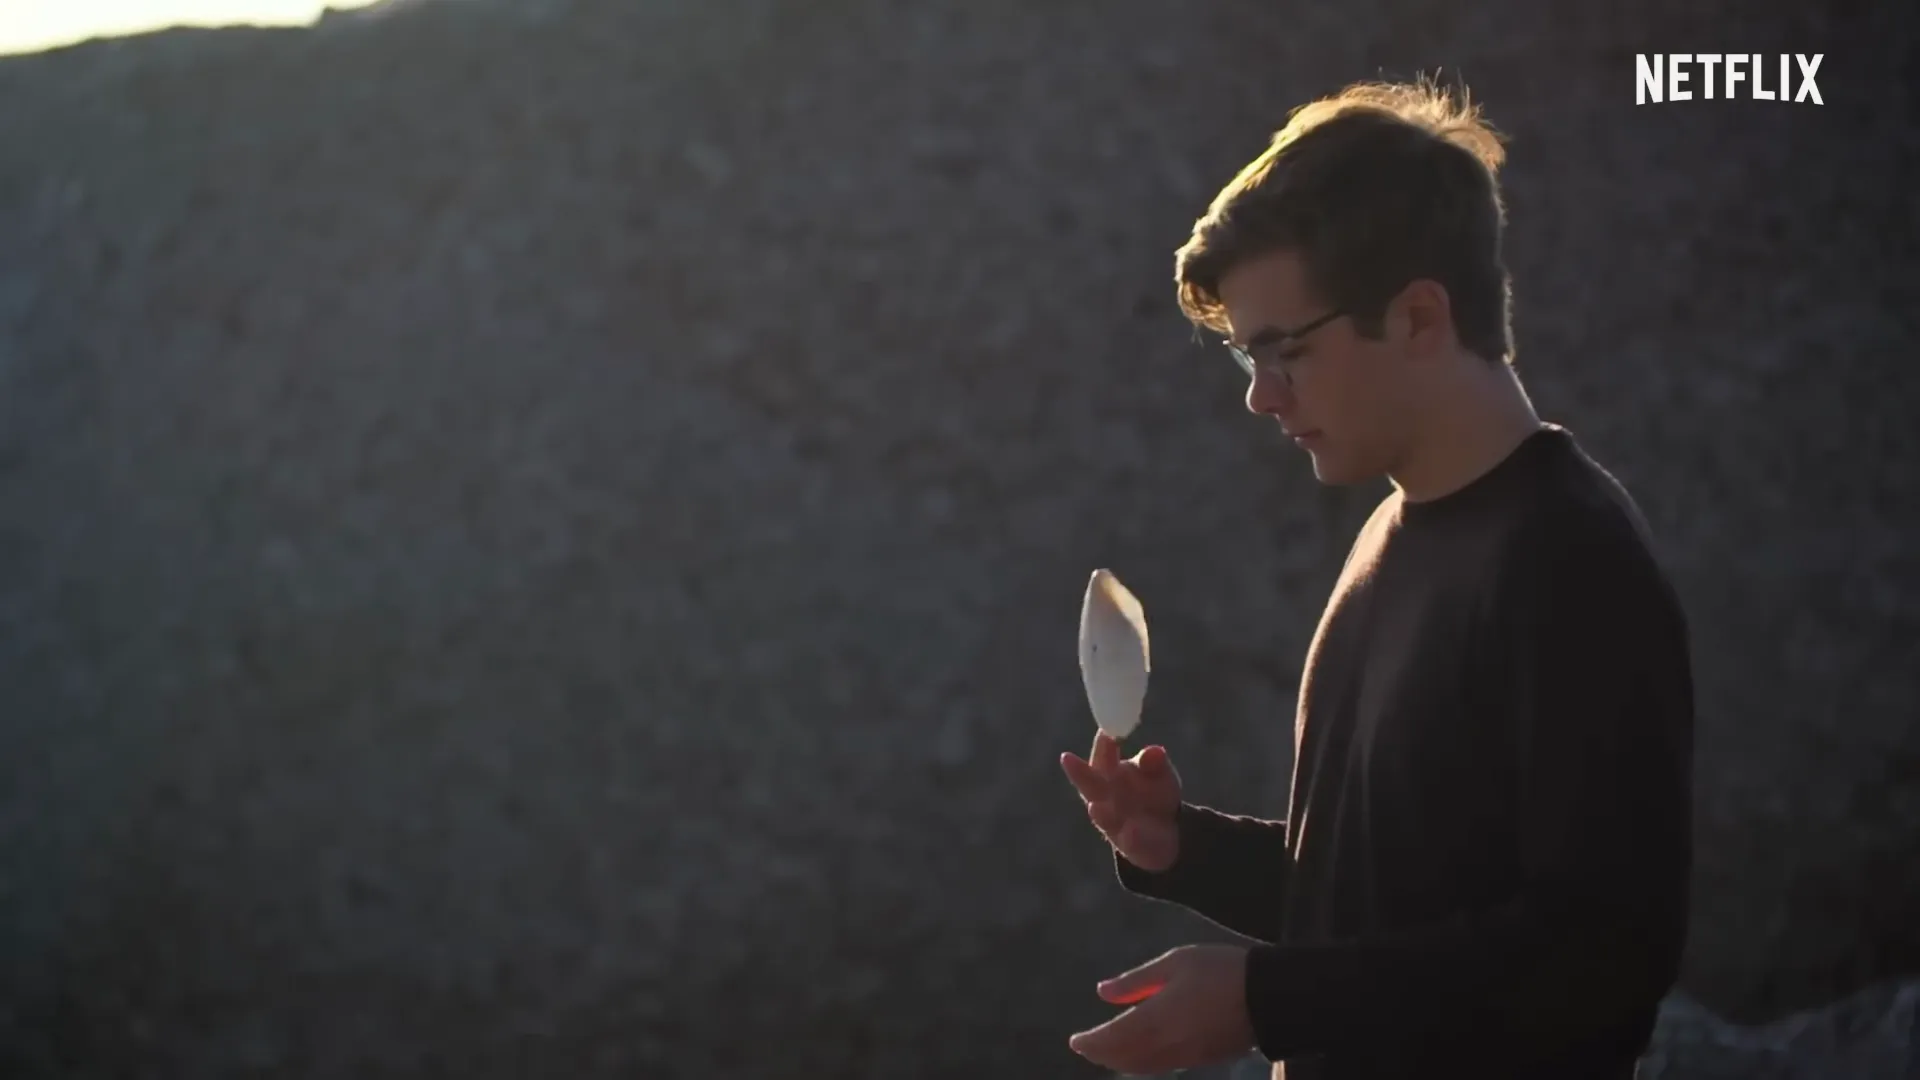
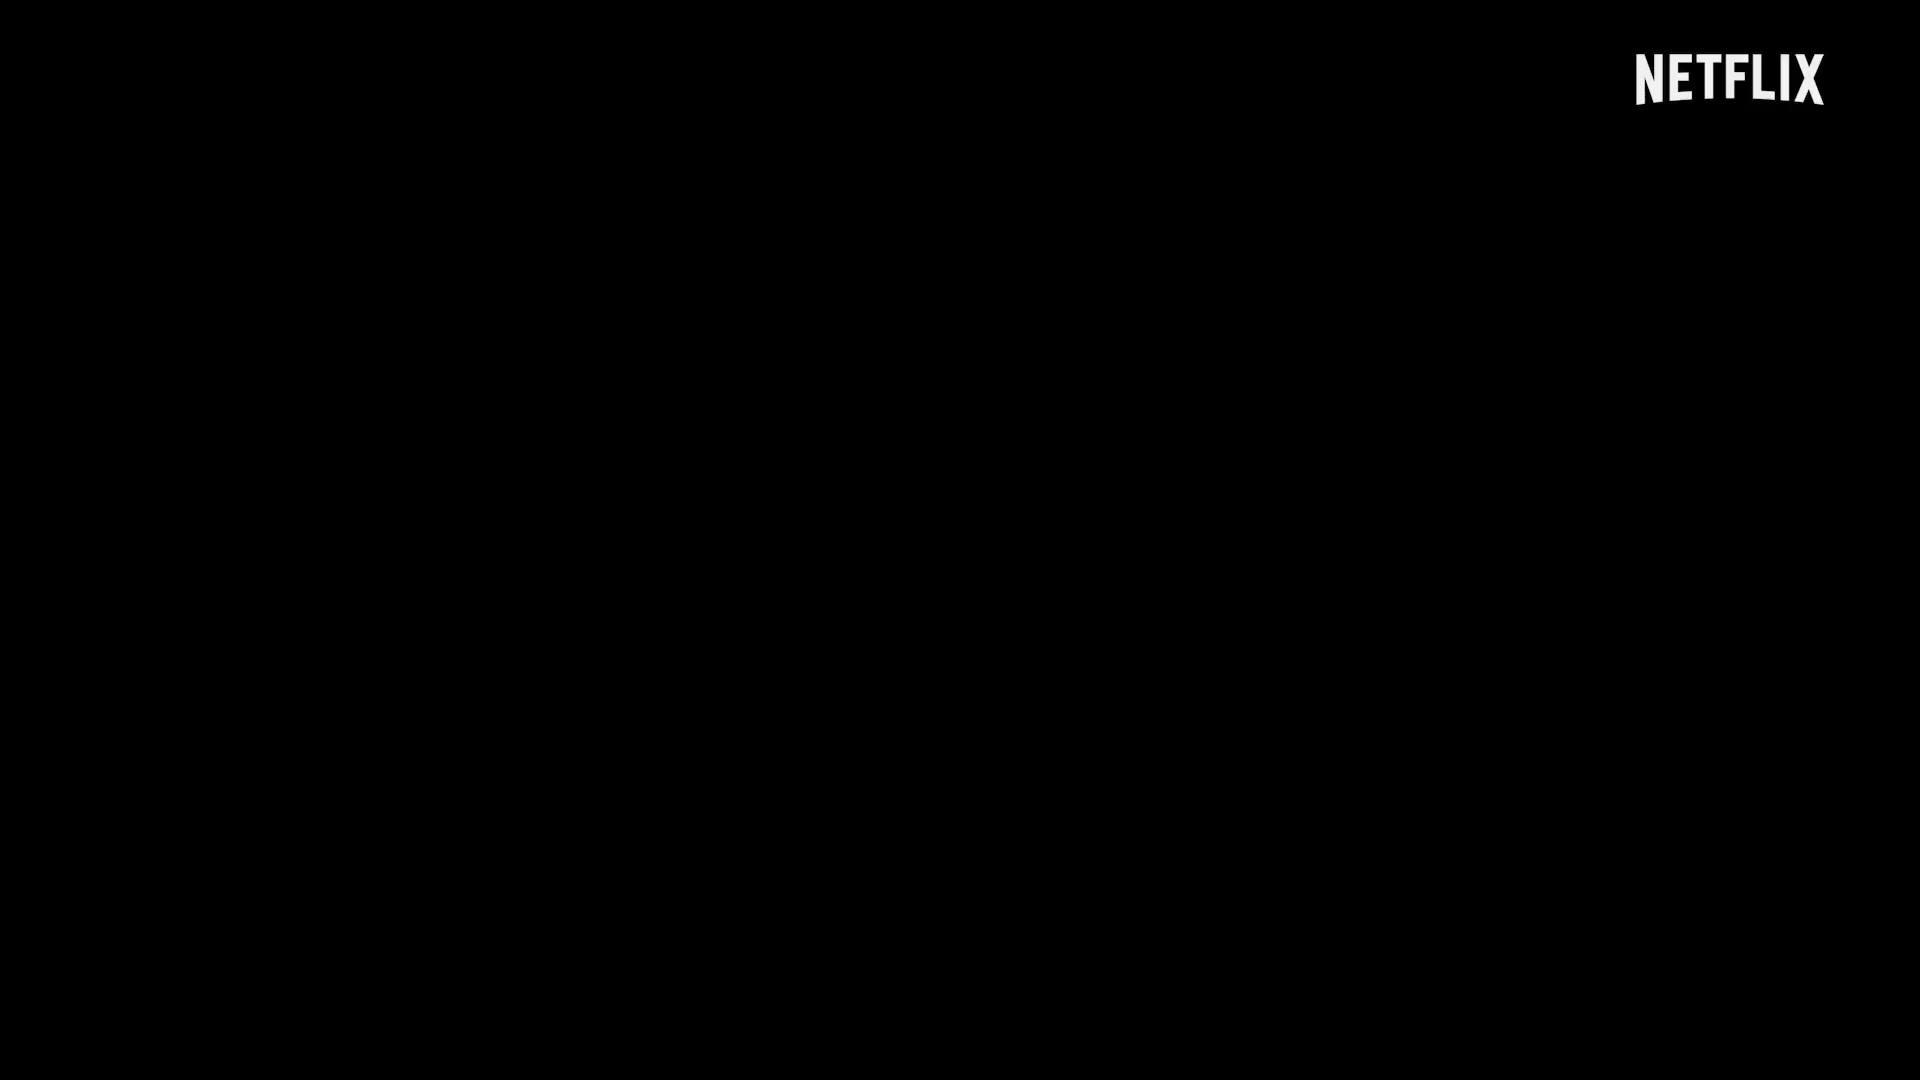
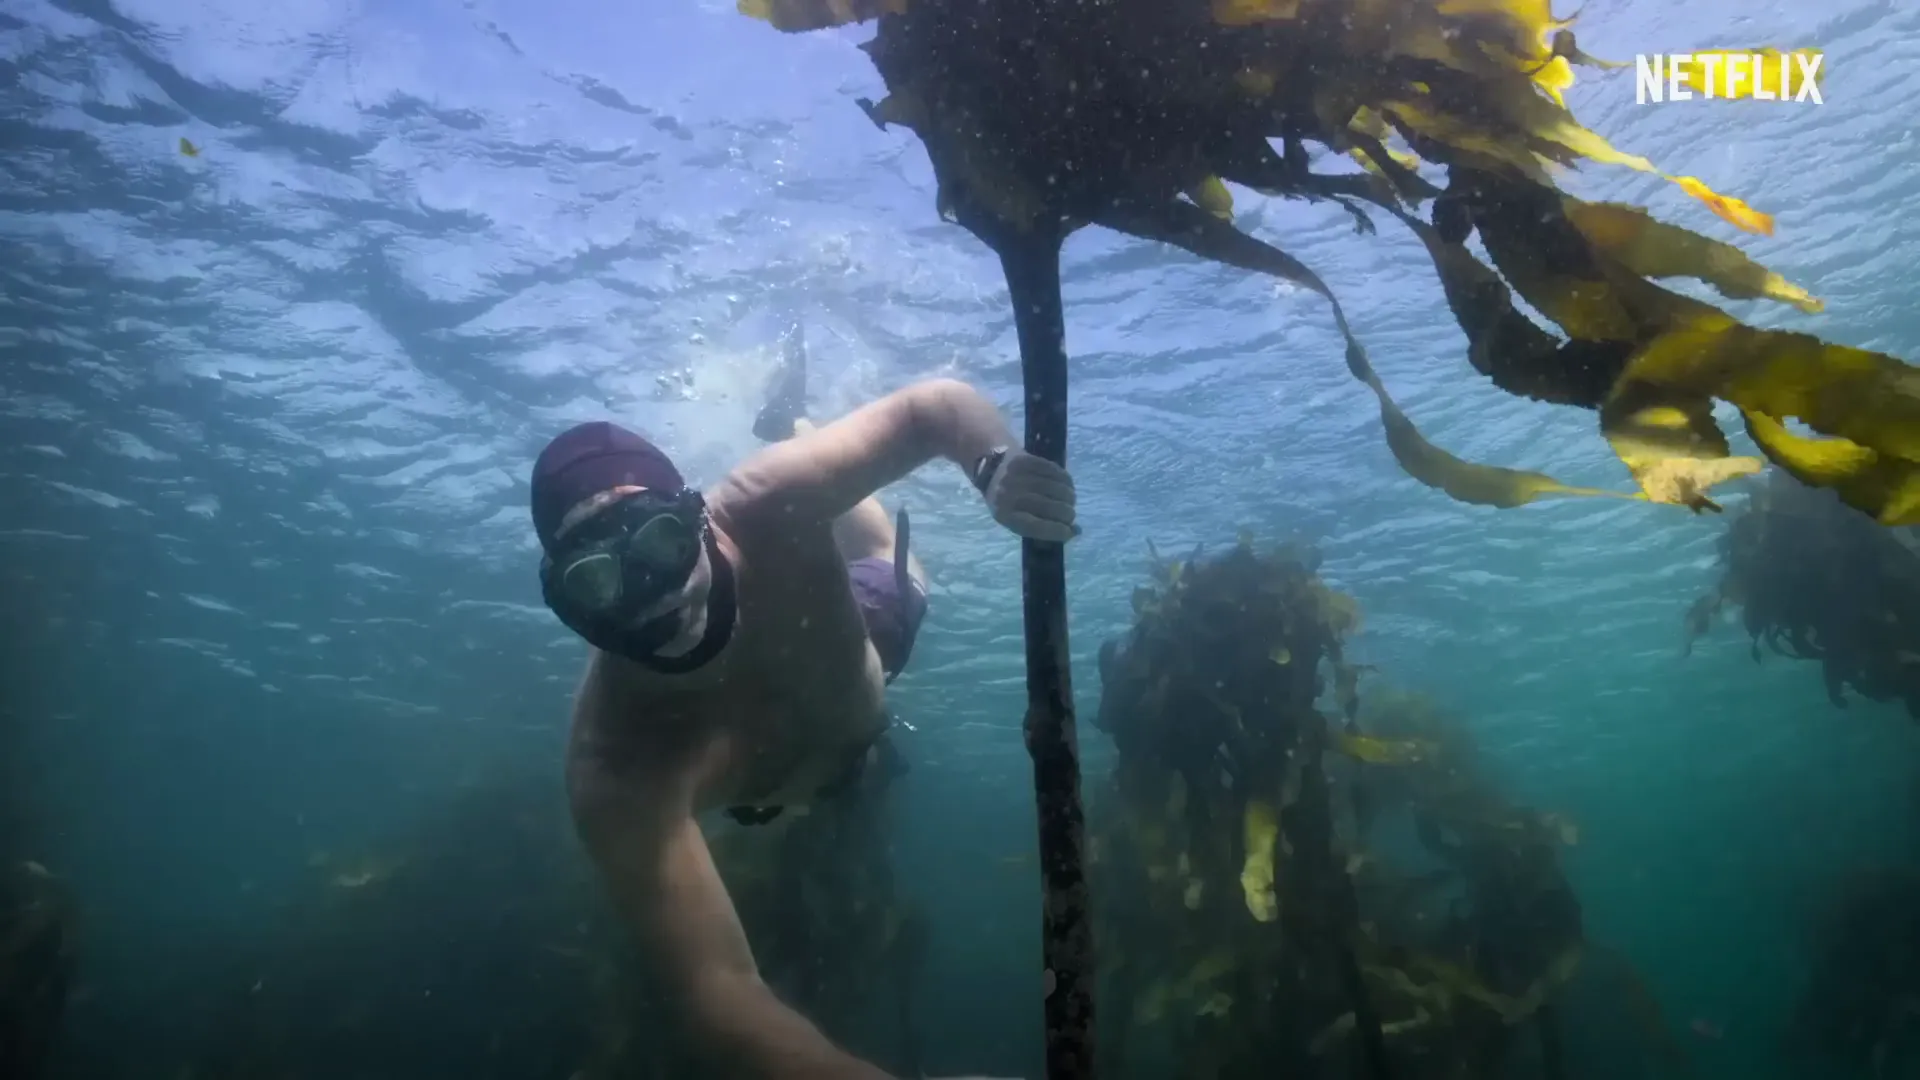
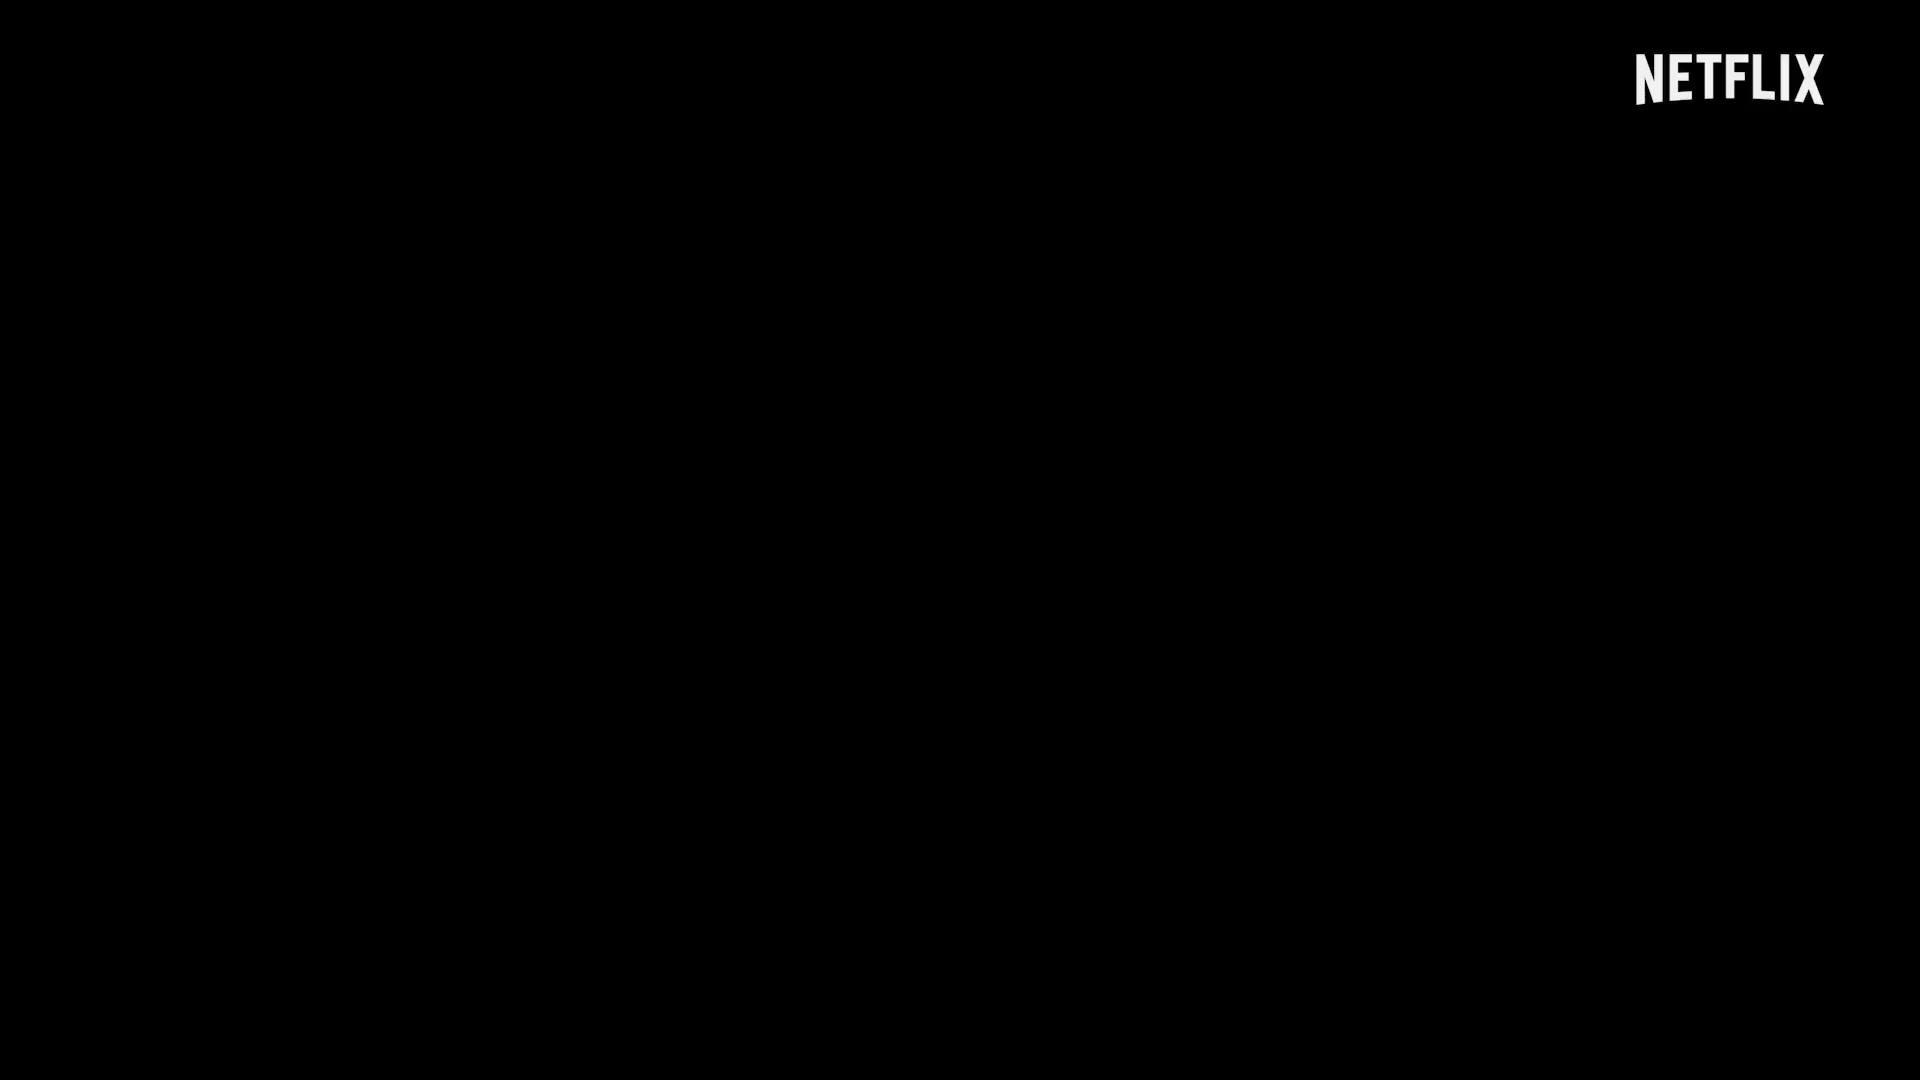
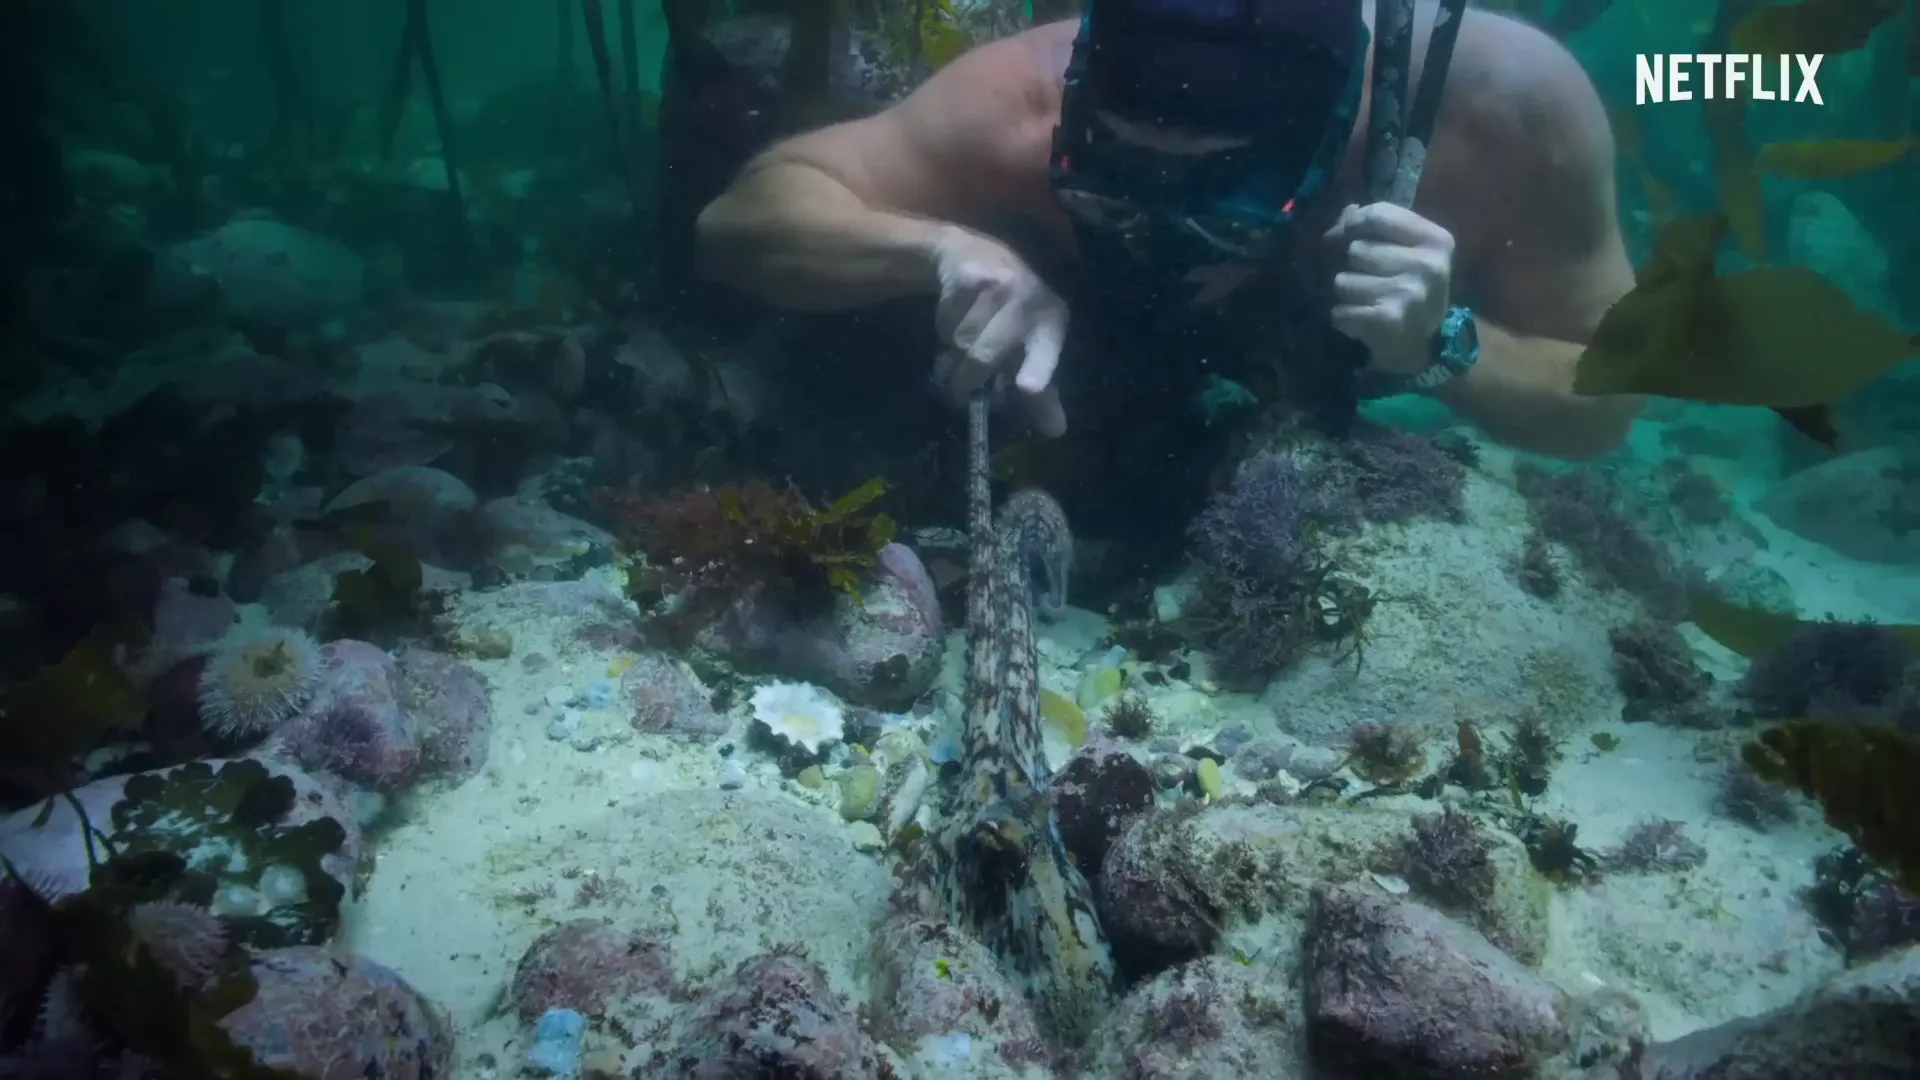
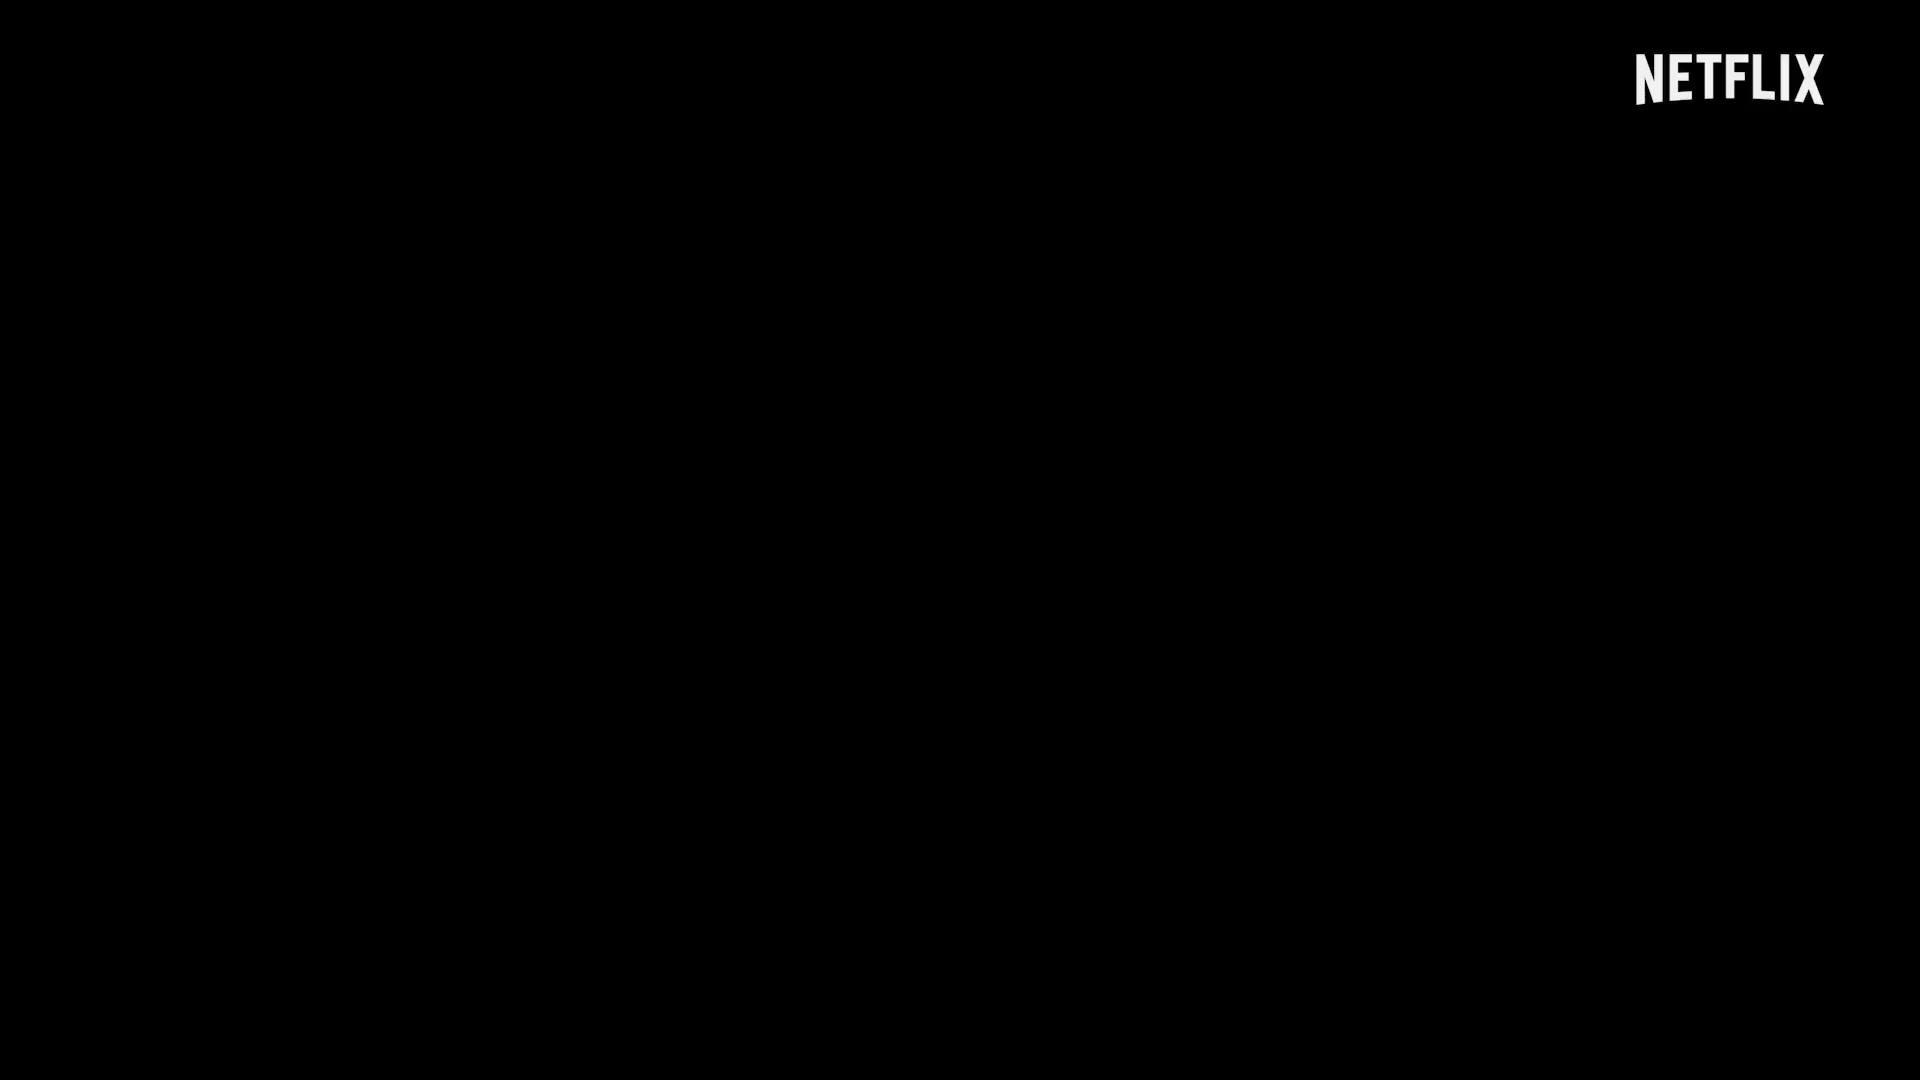
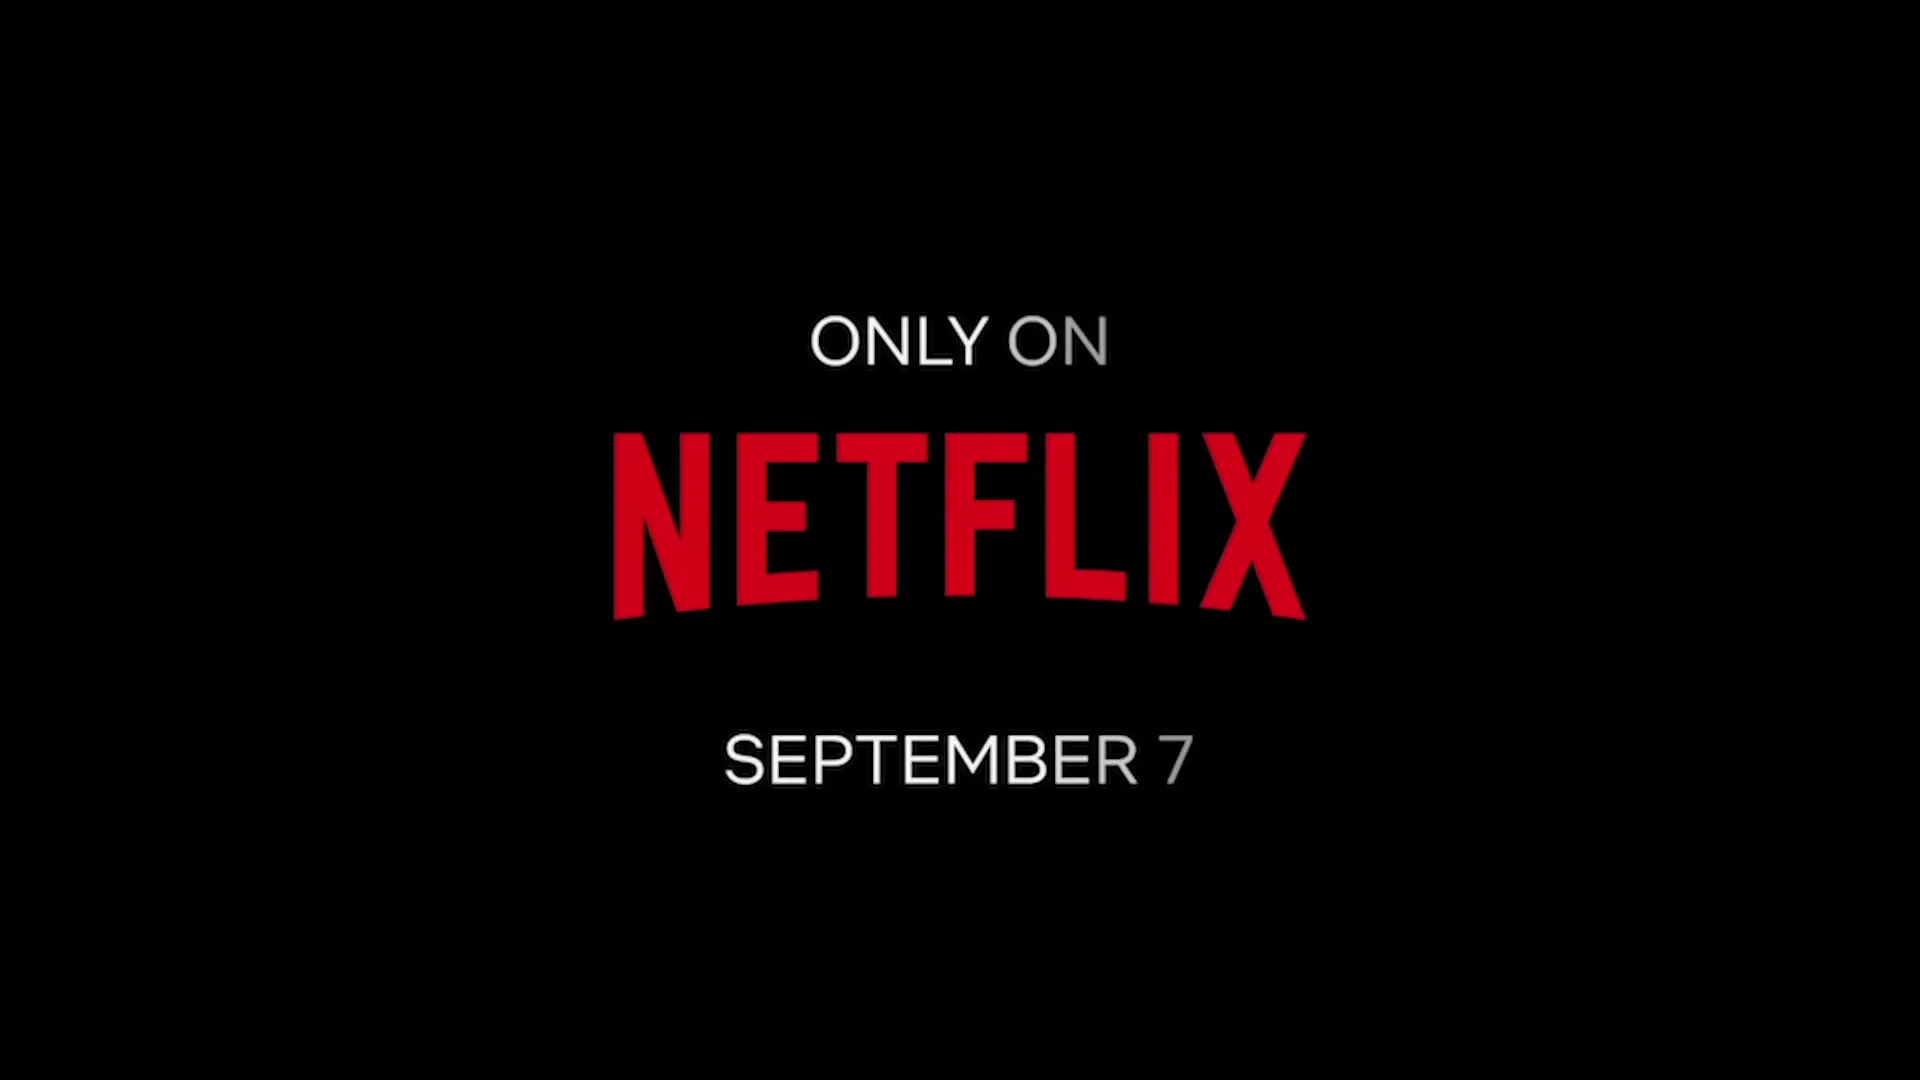
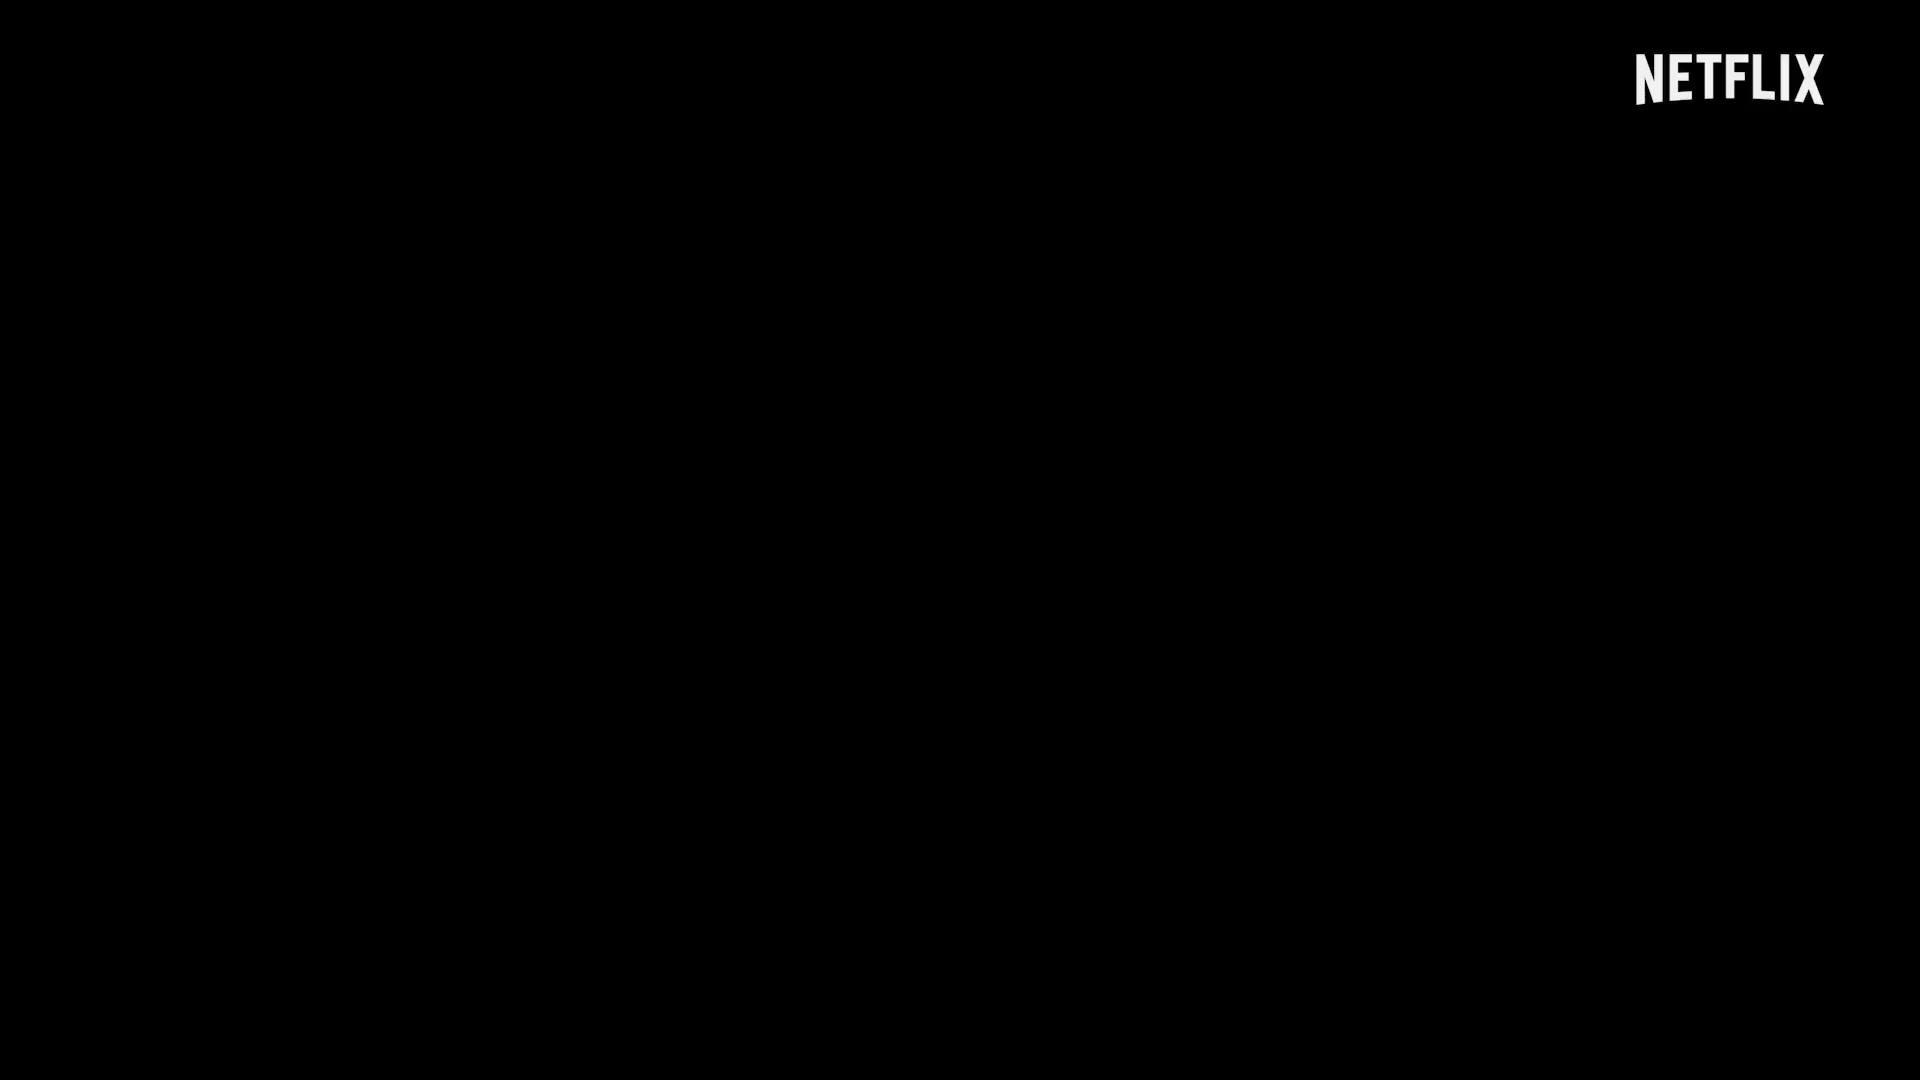

In [8]:
octo_frames_v.head()

### Convert frames to grayscale and store in Backblaze B2

Convert each frame to grayscale using Pixeltable's built-in `.convert()` method and store the results in Backblaze B2. This demonstrates how Pixeltable makes image transformations as simple as adding computed columns.

Use the `https://` URL format so Pixeltable automatically detects the B2 endpoint. The destination will use your bucket name that you entered during setup. The pattern is:
```
https://s3.{region}.backblazeb2.com/{your-bucket-name}/your-path/
```

For example: `https://s3.us-west-004.backblazeb2.com/{B2_BUCKET}/output/frames/`

**This is the power of declarative infrastructure:** Instead of writing upload code, managing file paths, and handling errors, you just specify where data should go. Pixeltable orchestrates everything.


In [14]:
import sys, boto3
print(sys.executable)          # should be .../.venv/bin/python
print("boto3:", boto3.__version__)


/Users/jdeleon/Documents/oss/b2-pixeltable/.venv/bin/python
boto3: 1.41.0


In [15]:
# Convert frames to grayscale and store in B2 - Pixeltable handles upload, versioning, and URL generation
octo_frames_v.add_computed_column(
    frame_bw=octo_frames_v.frame.convert('L'),
    destination=f"{B2_ENDPOINT}/{B2_BUCKET}/output/frames/"
)

Added 10 column values with 0 errors.


10 rows updated, 10 values computed.

Let's see what we just created. The `head(5)` method (a shortcut for `limit(5).collect()`) shows the first 5 rows of our view, displaying the grayscale frames from the video.

pos  frame_idx  pos_msec  pos_frame  \
0    0          0       0.0          0   
1    1          1   15000.0        375   
2    2          2   30000.0        750   
3    3          3   44960.0       1124   
4    4          4   59960.0       1499   

                                               frame  \
0  <PIL.Image.Image image mode=RGB size=1920x1080...   
1  <PIL.Image.Image image mode=RGB size=1920x1080...   
2  <PIL.Image.Image image mode=RGB size=1920x1080...   
3  <PIL.Image.Image image mode=RGB size=1920x1080...   
4  <PIL.Image.Image image mode=RGB size=1920x1080...   

                                            frame_bw  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                               video  
0  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
1  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
2  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
3  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
4  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...
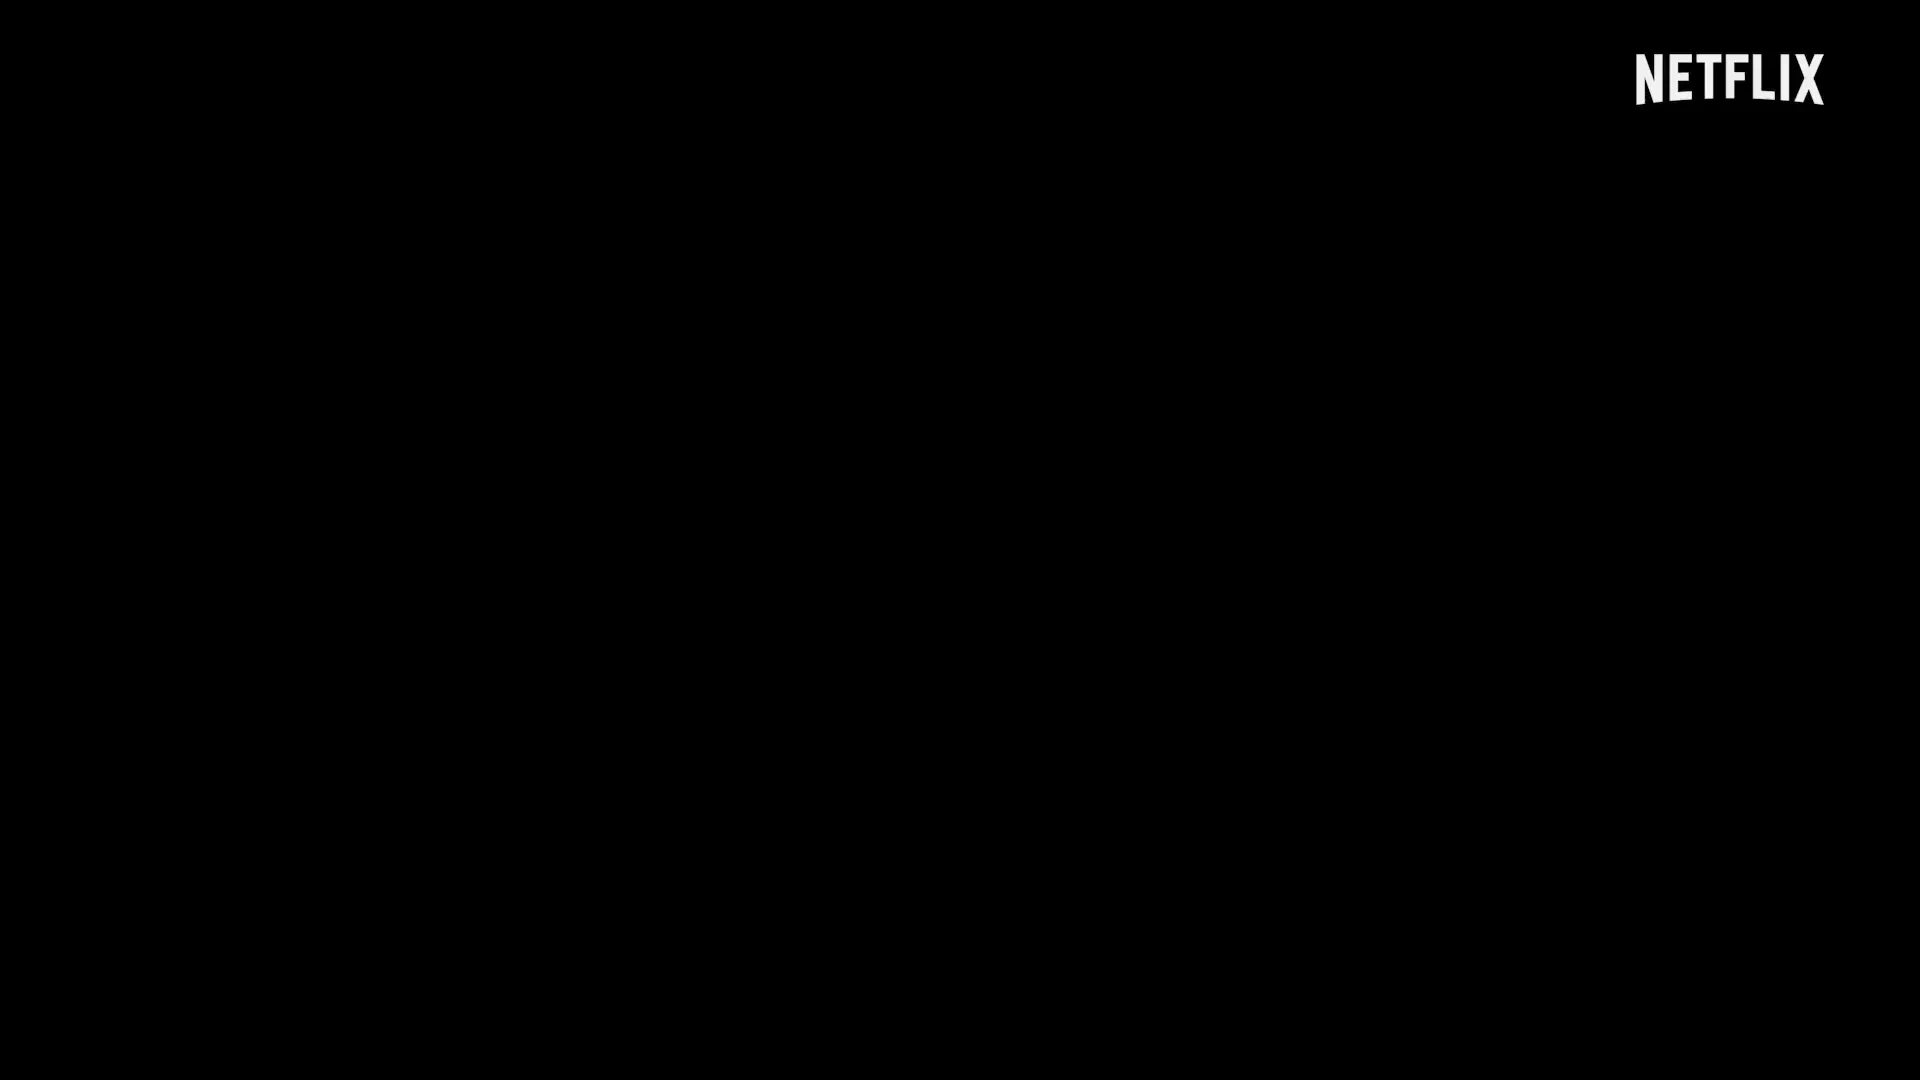
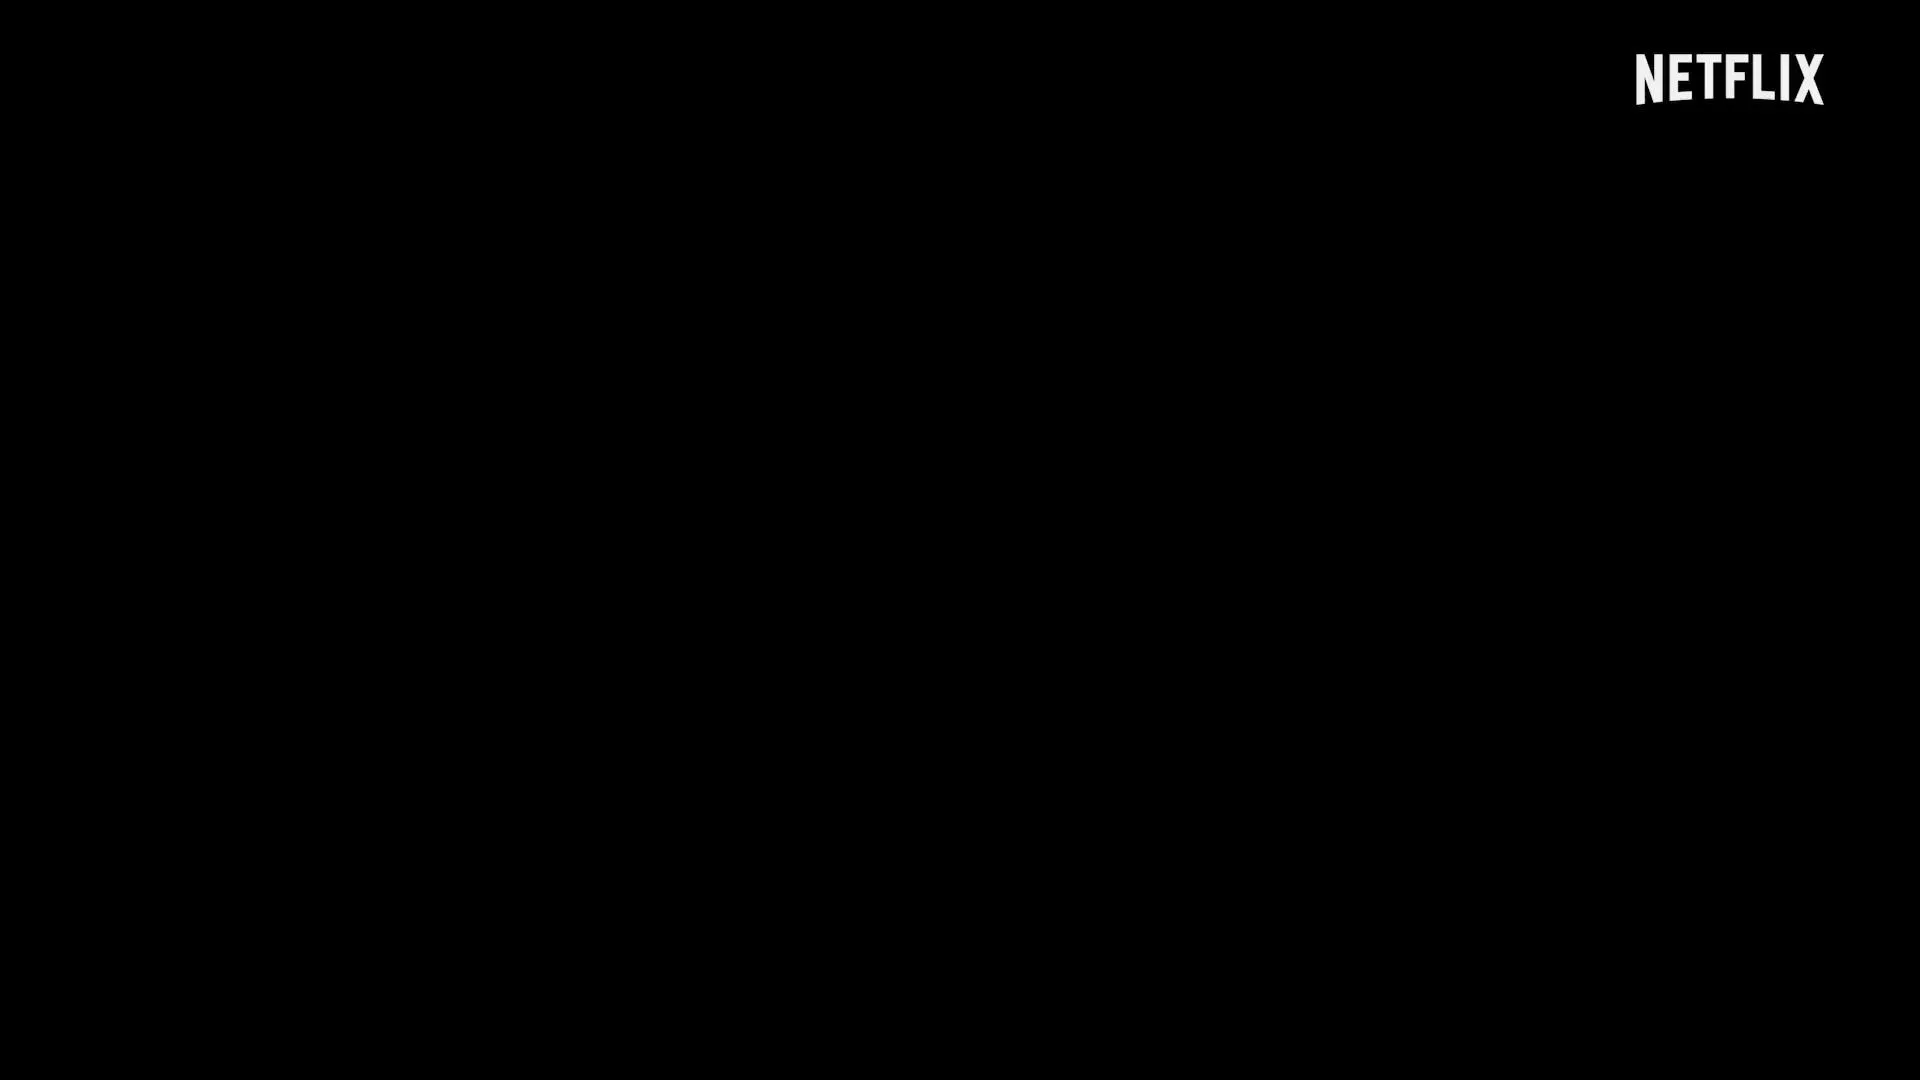
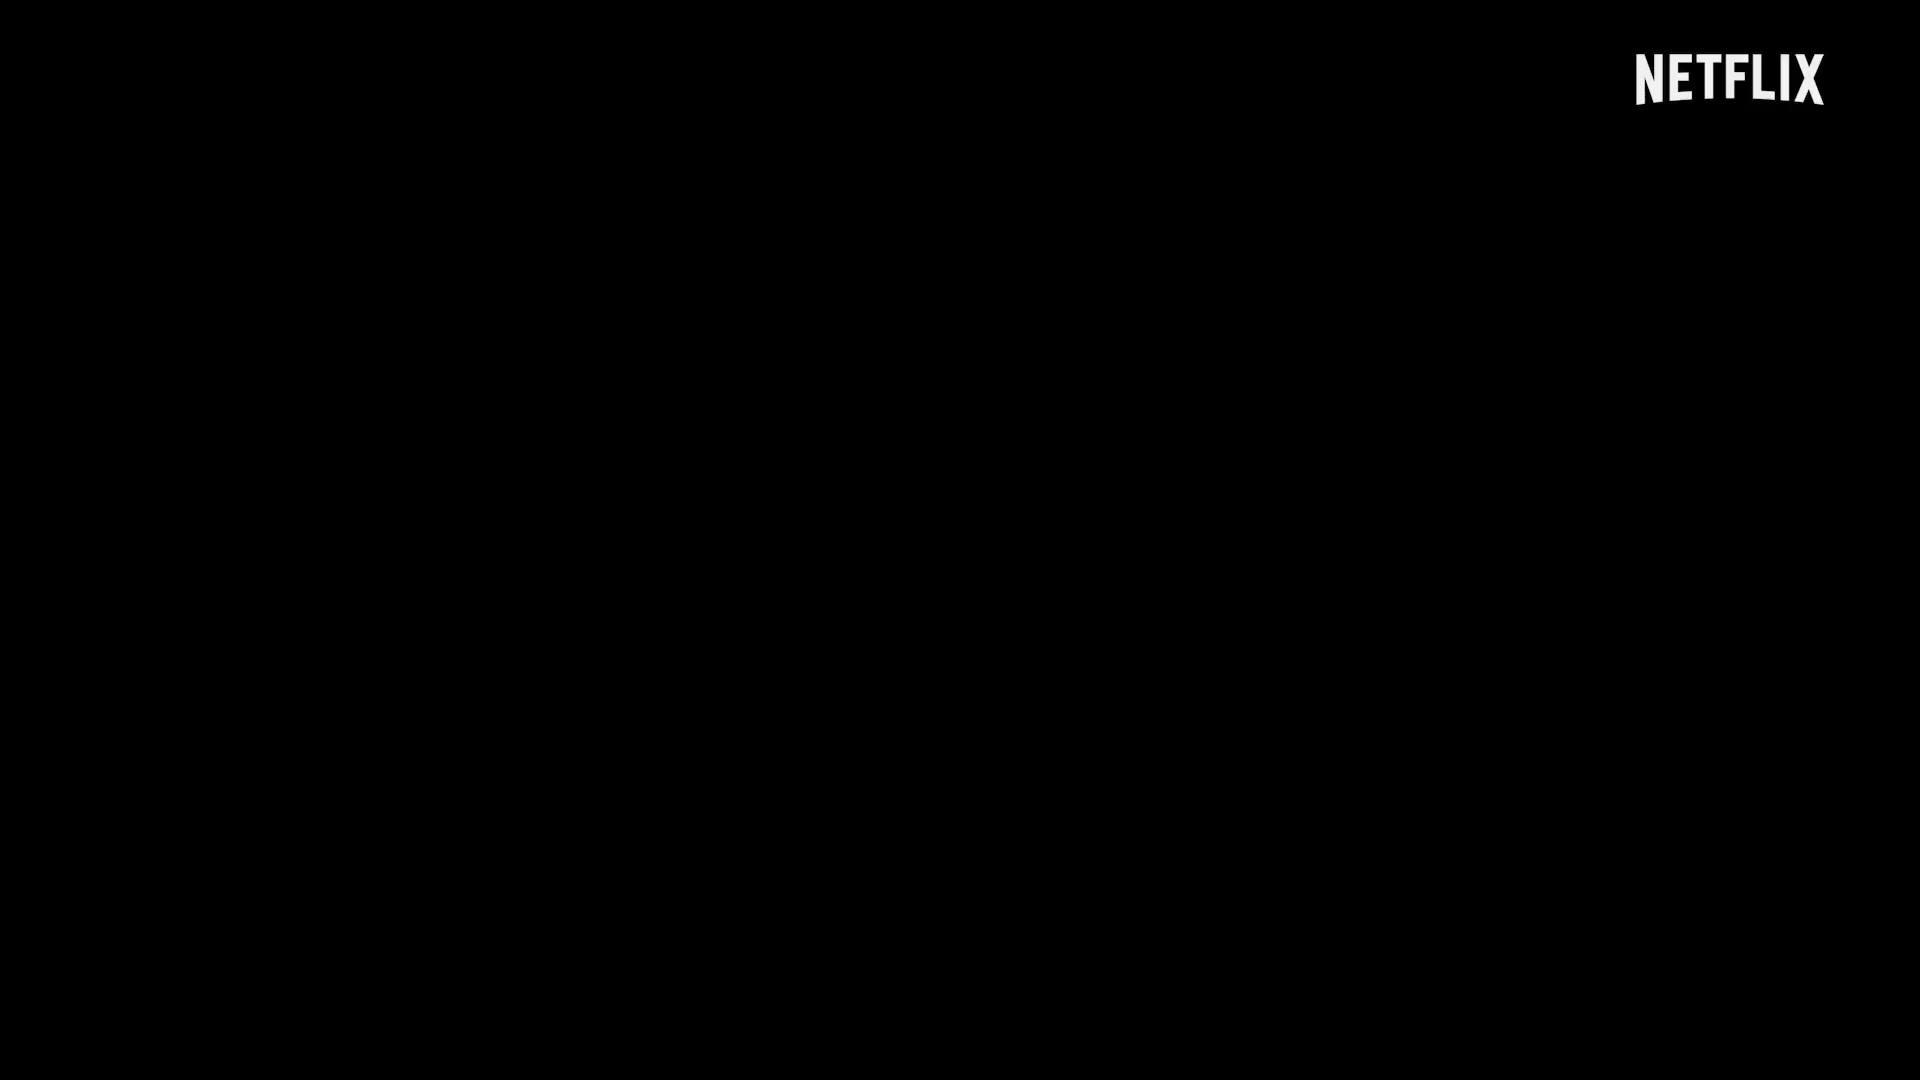
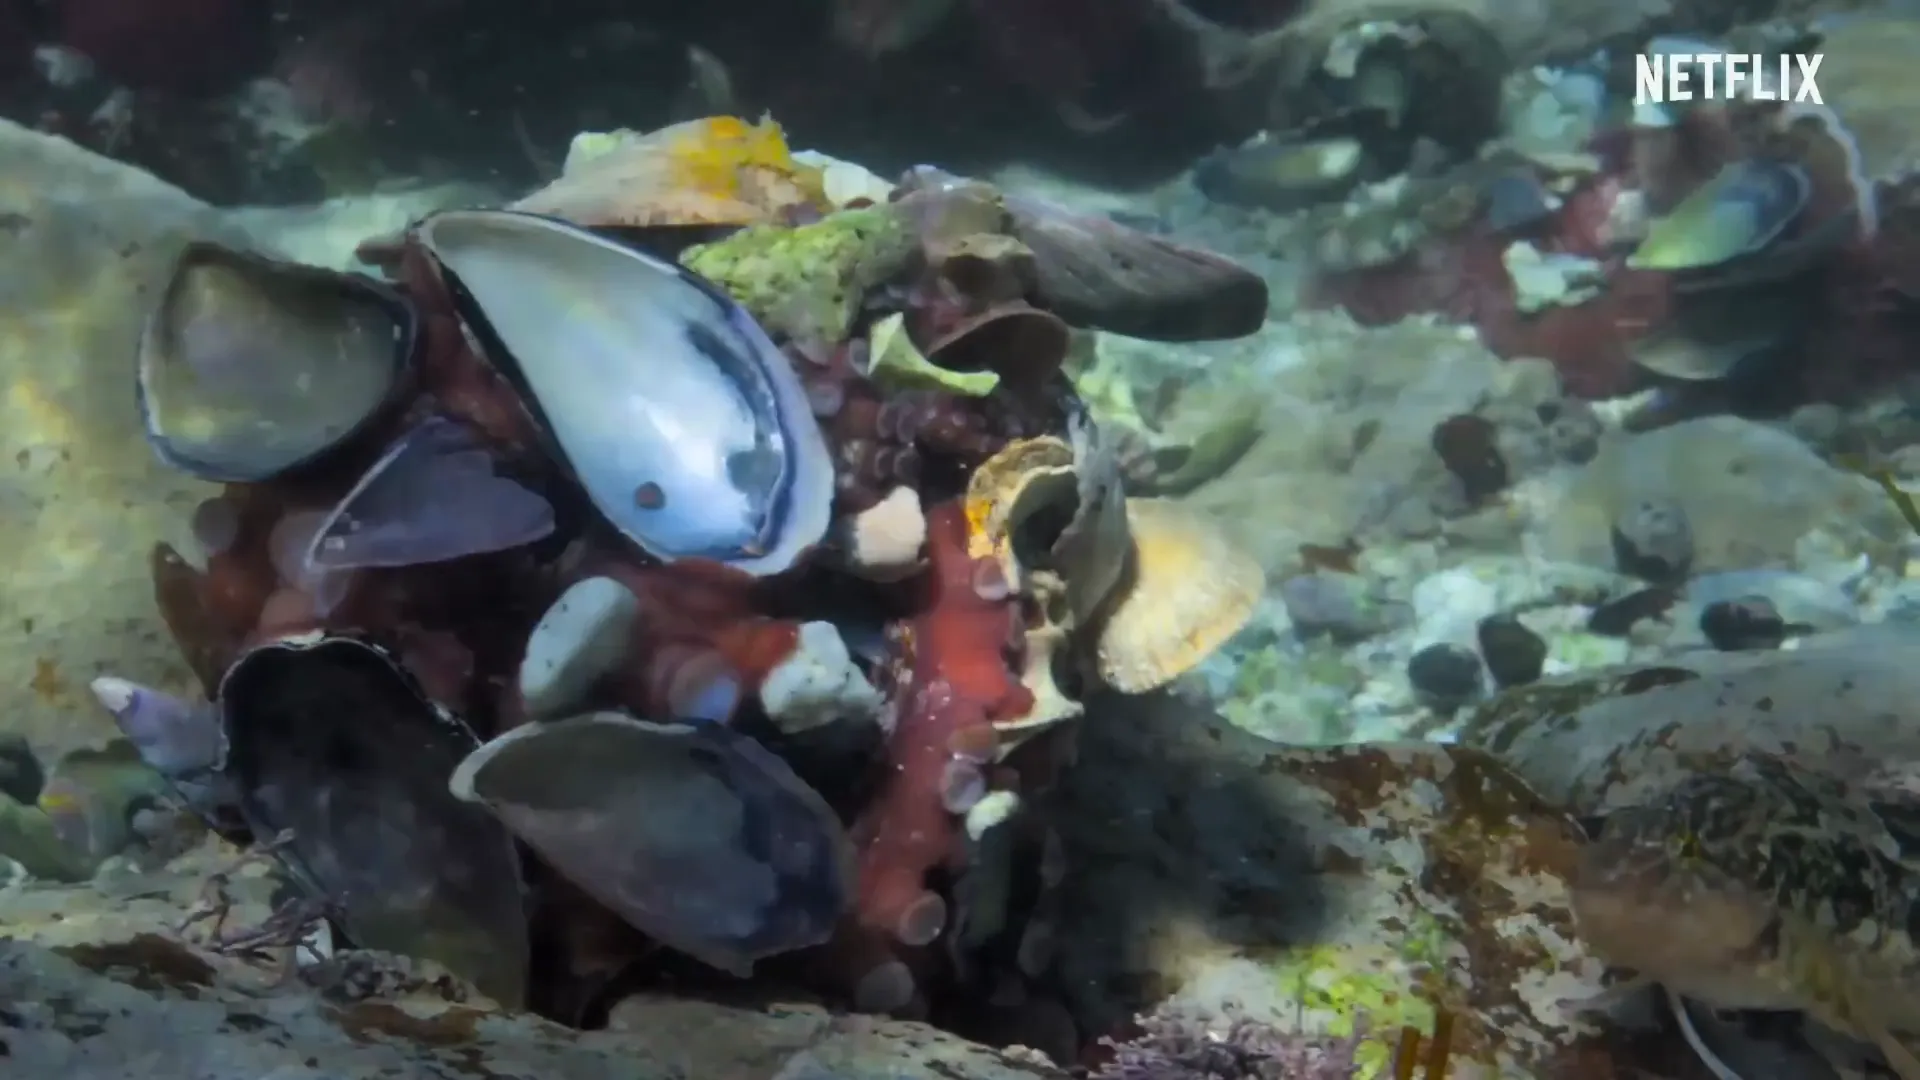
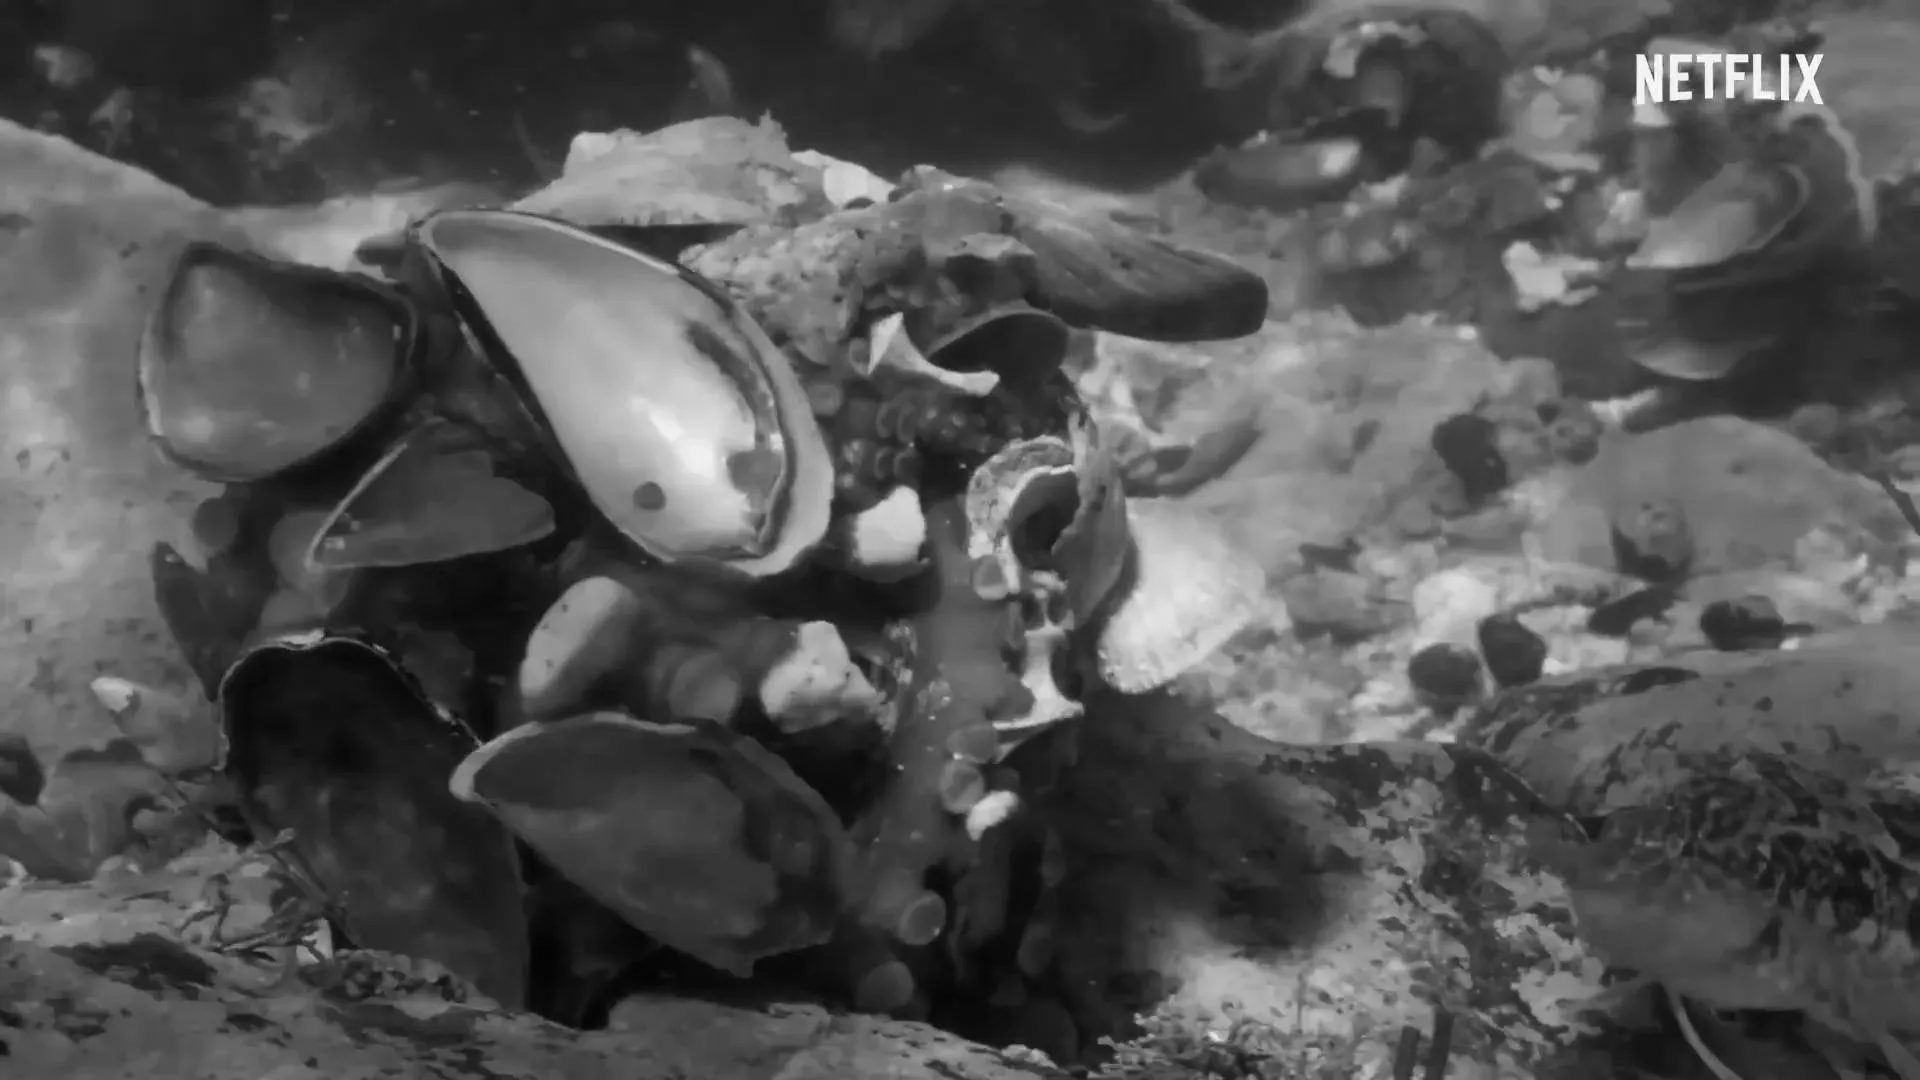
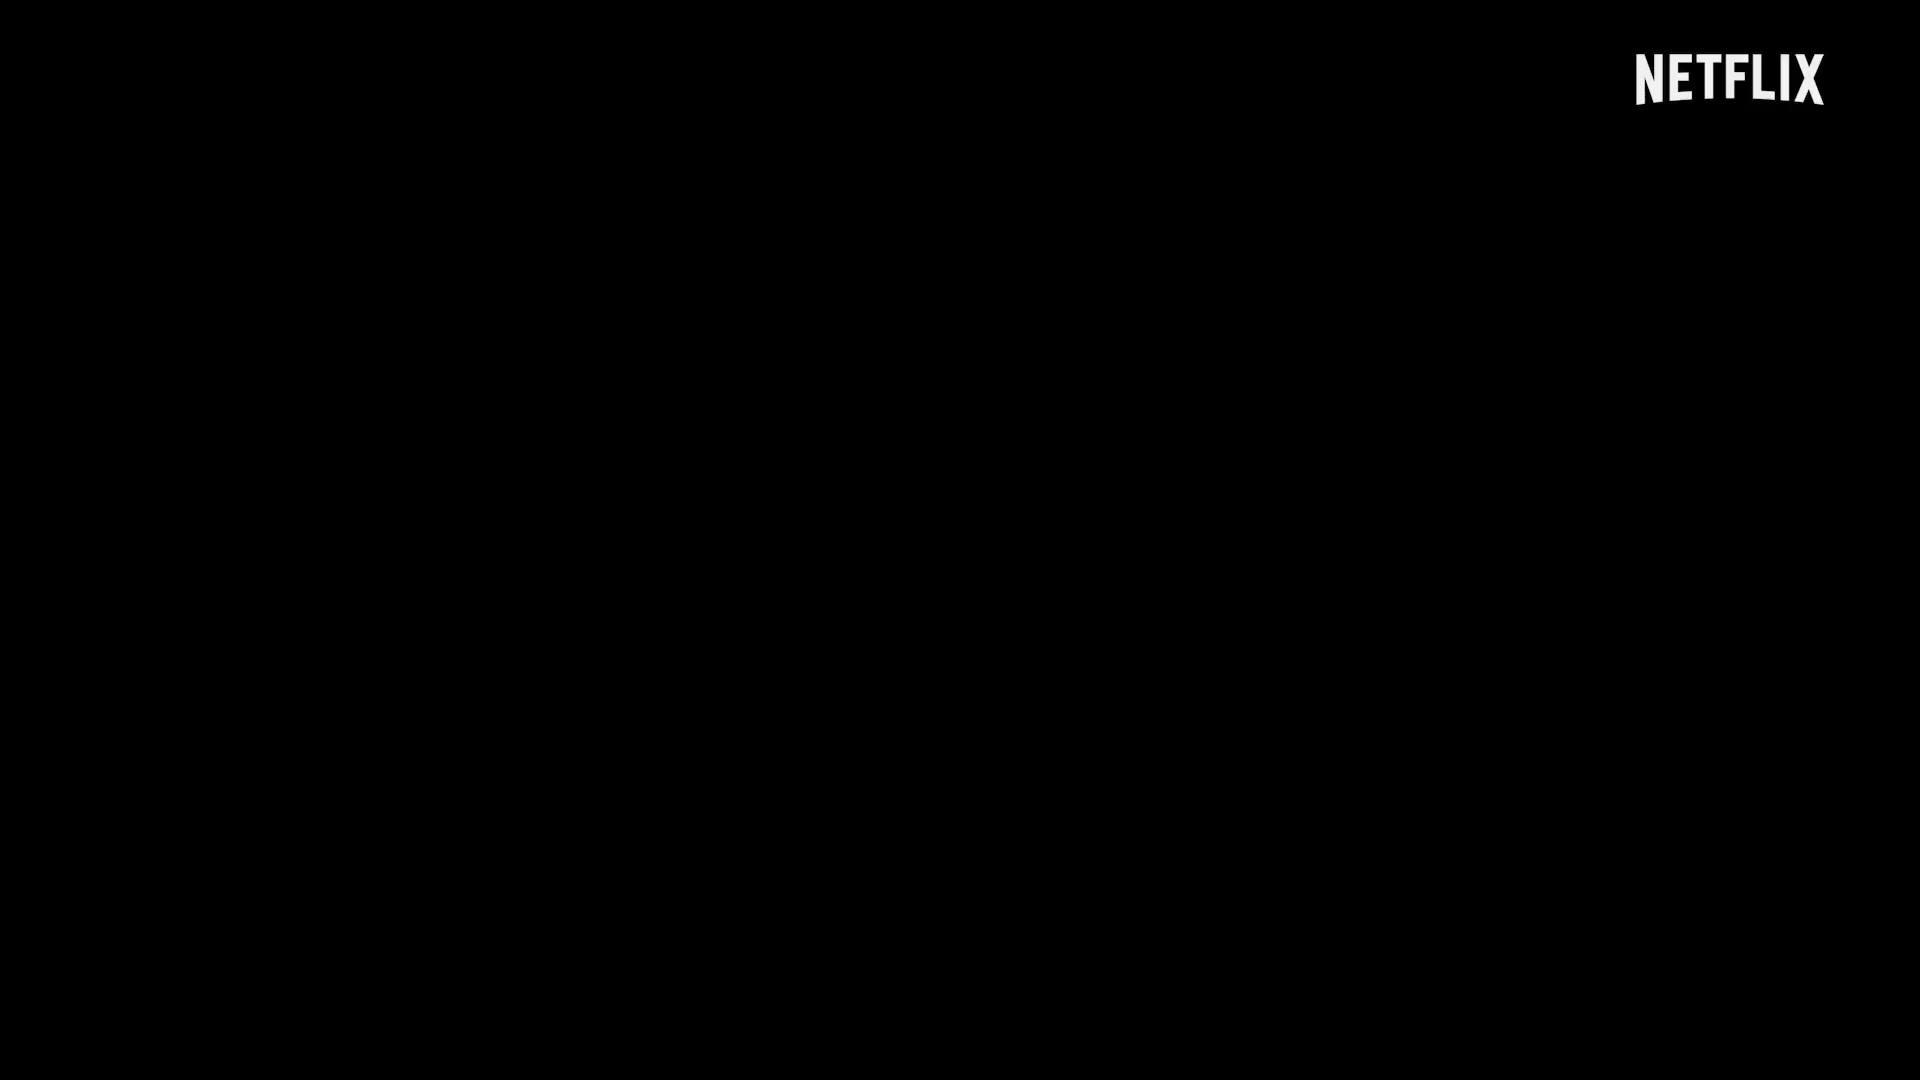
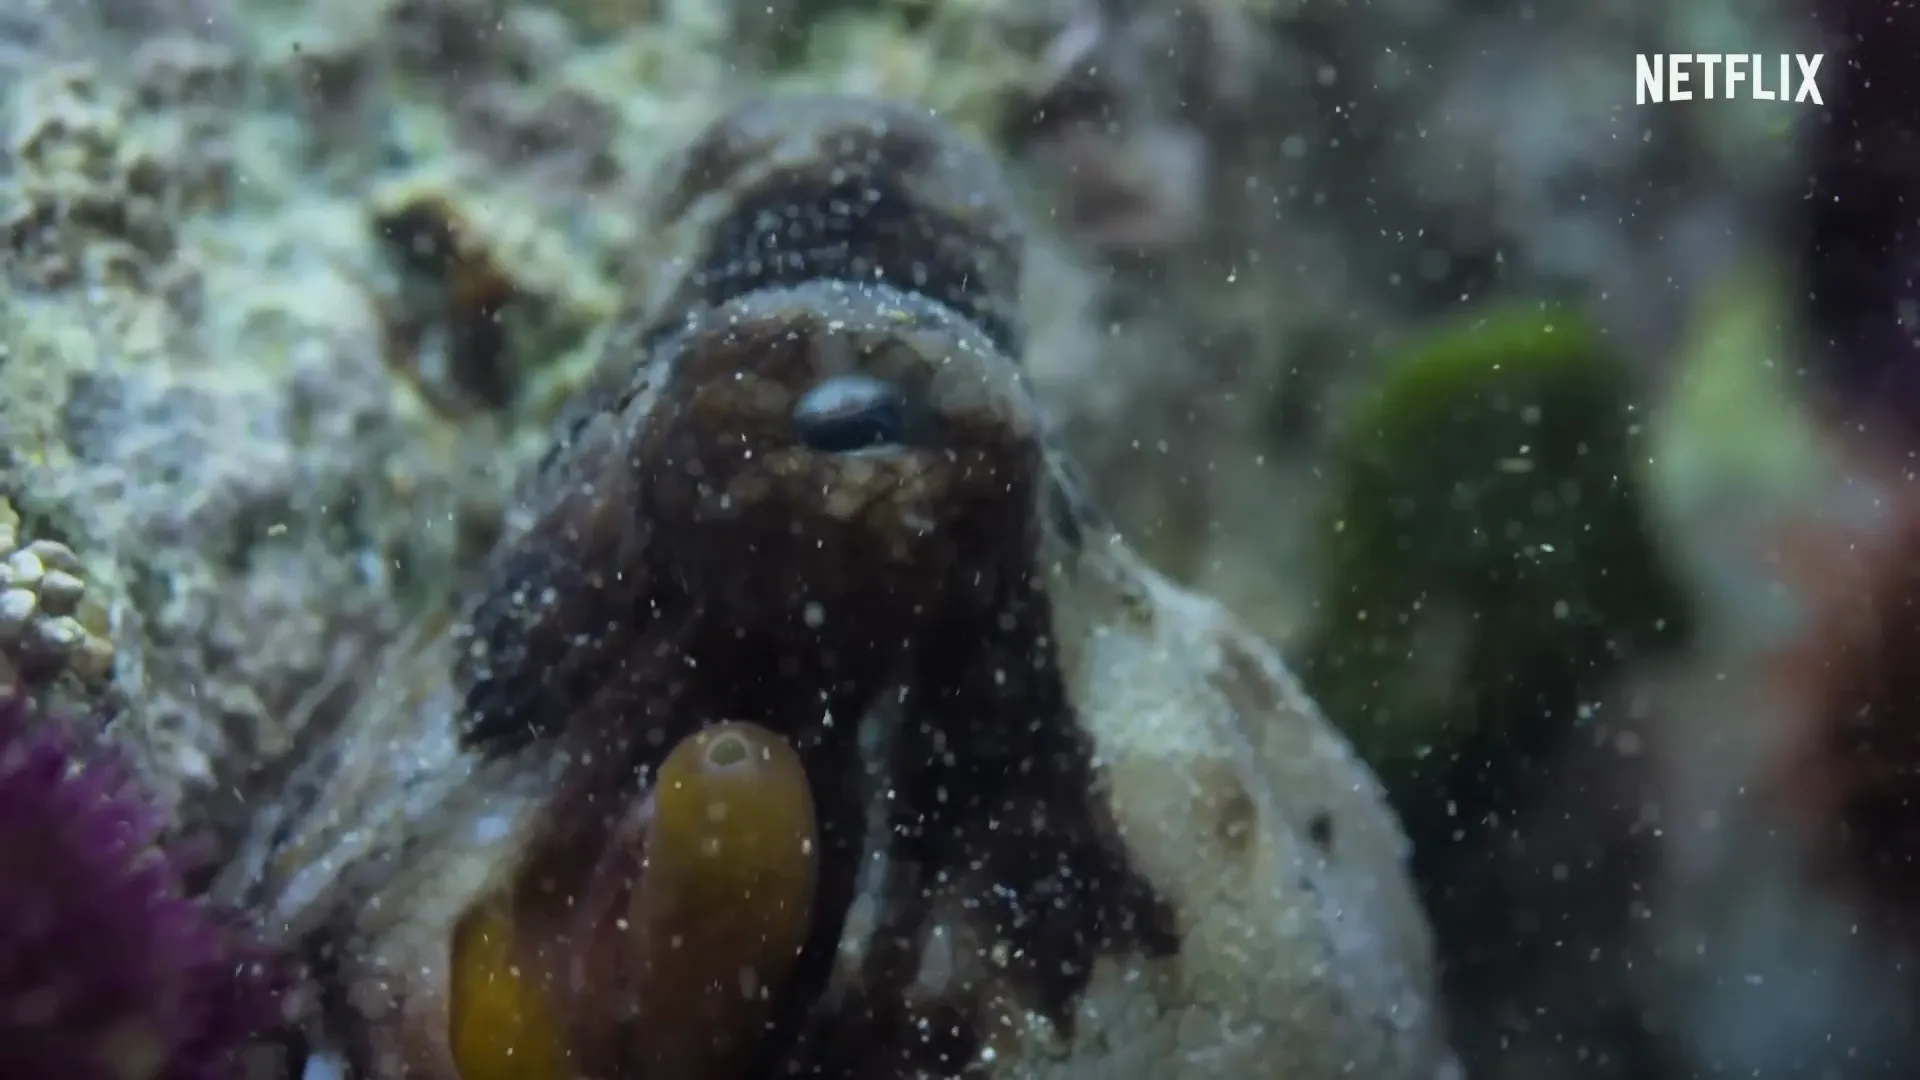
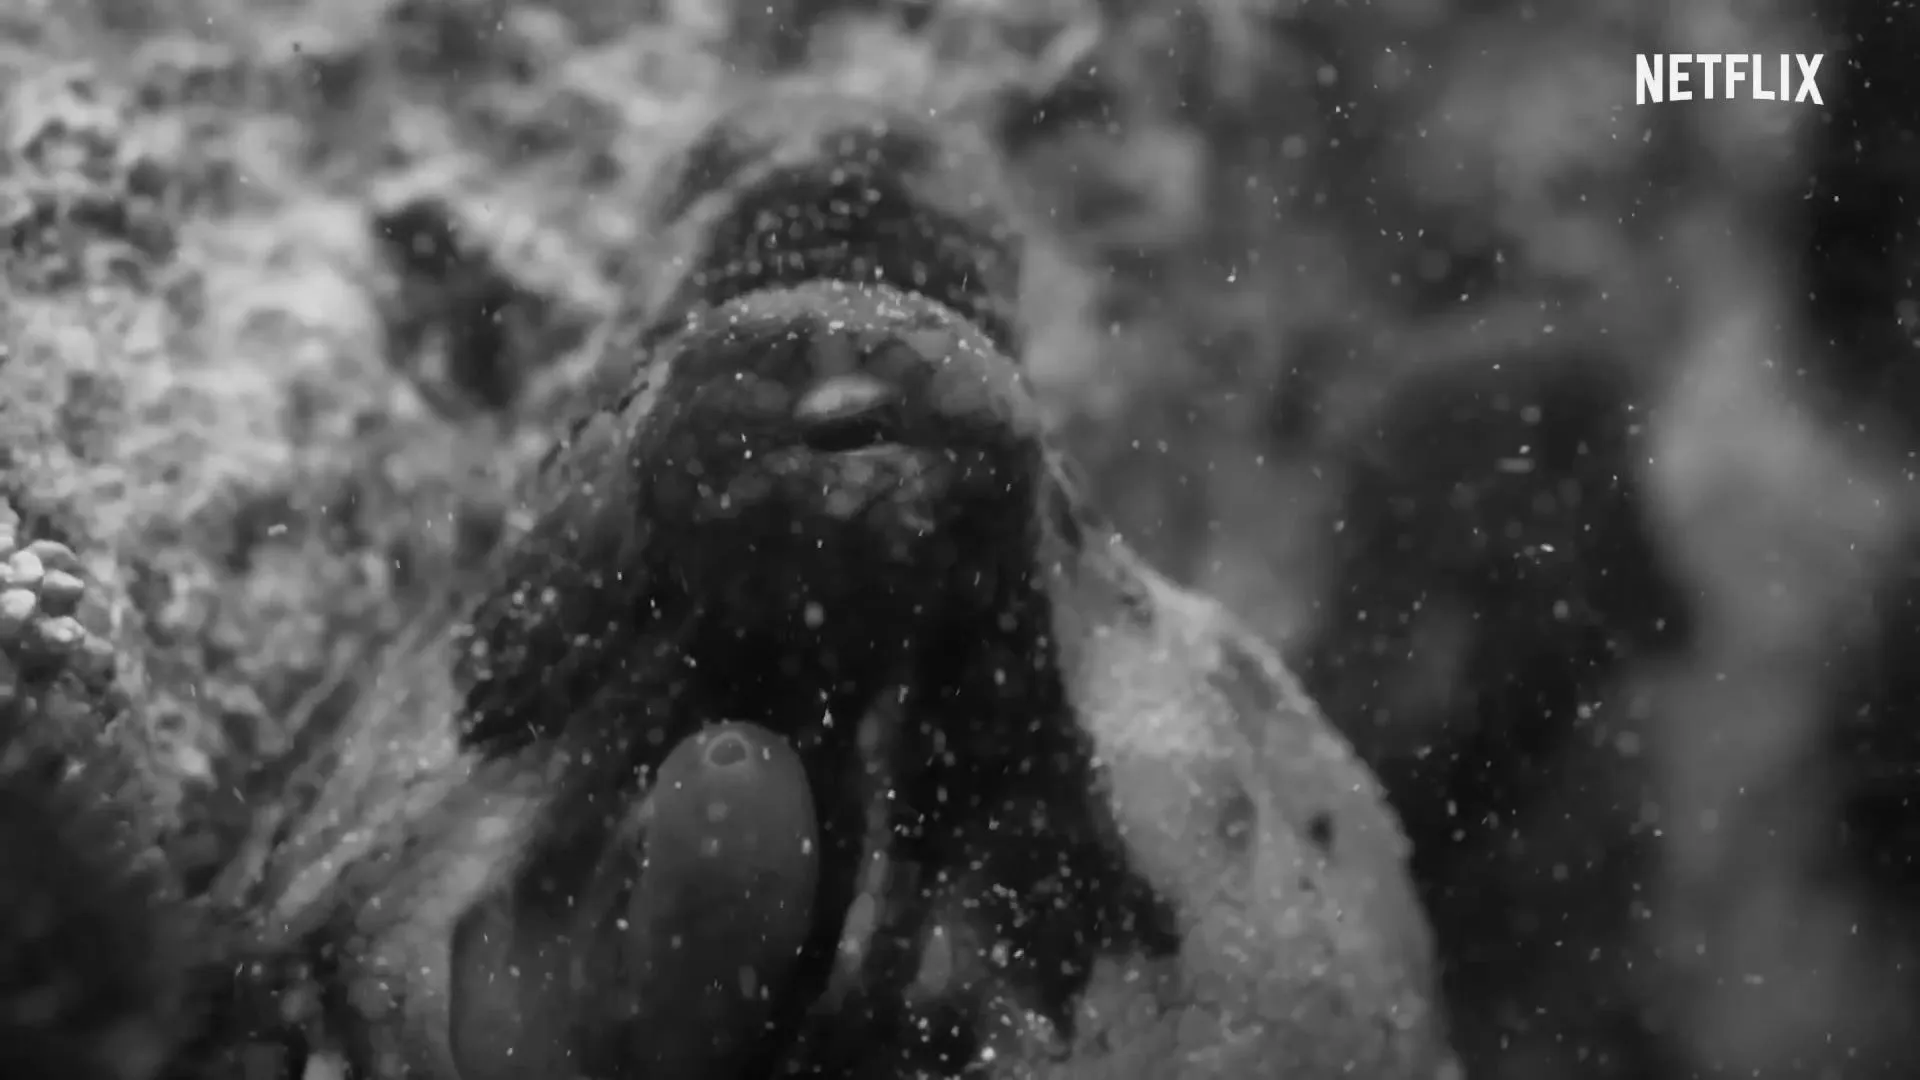
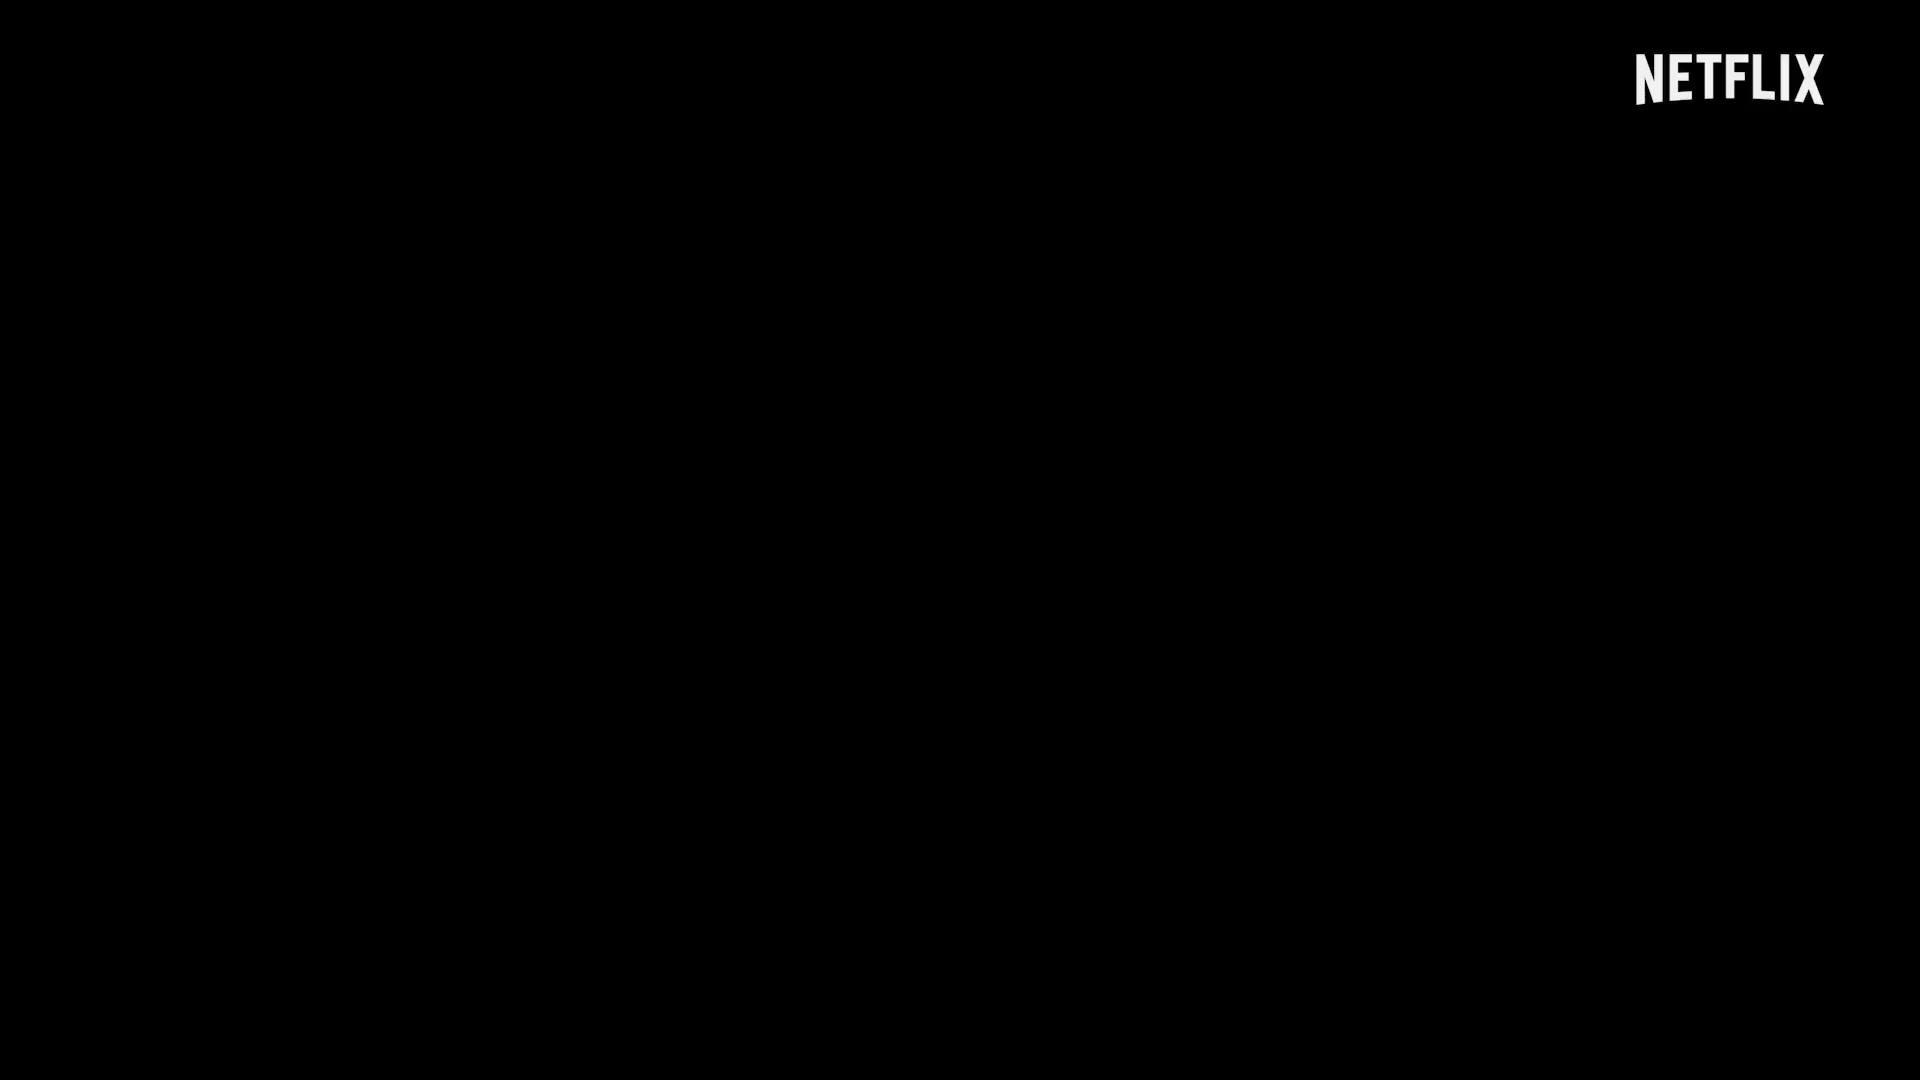
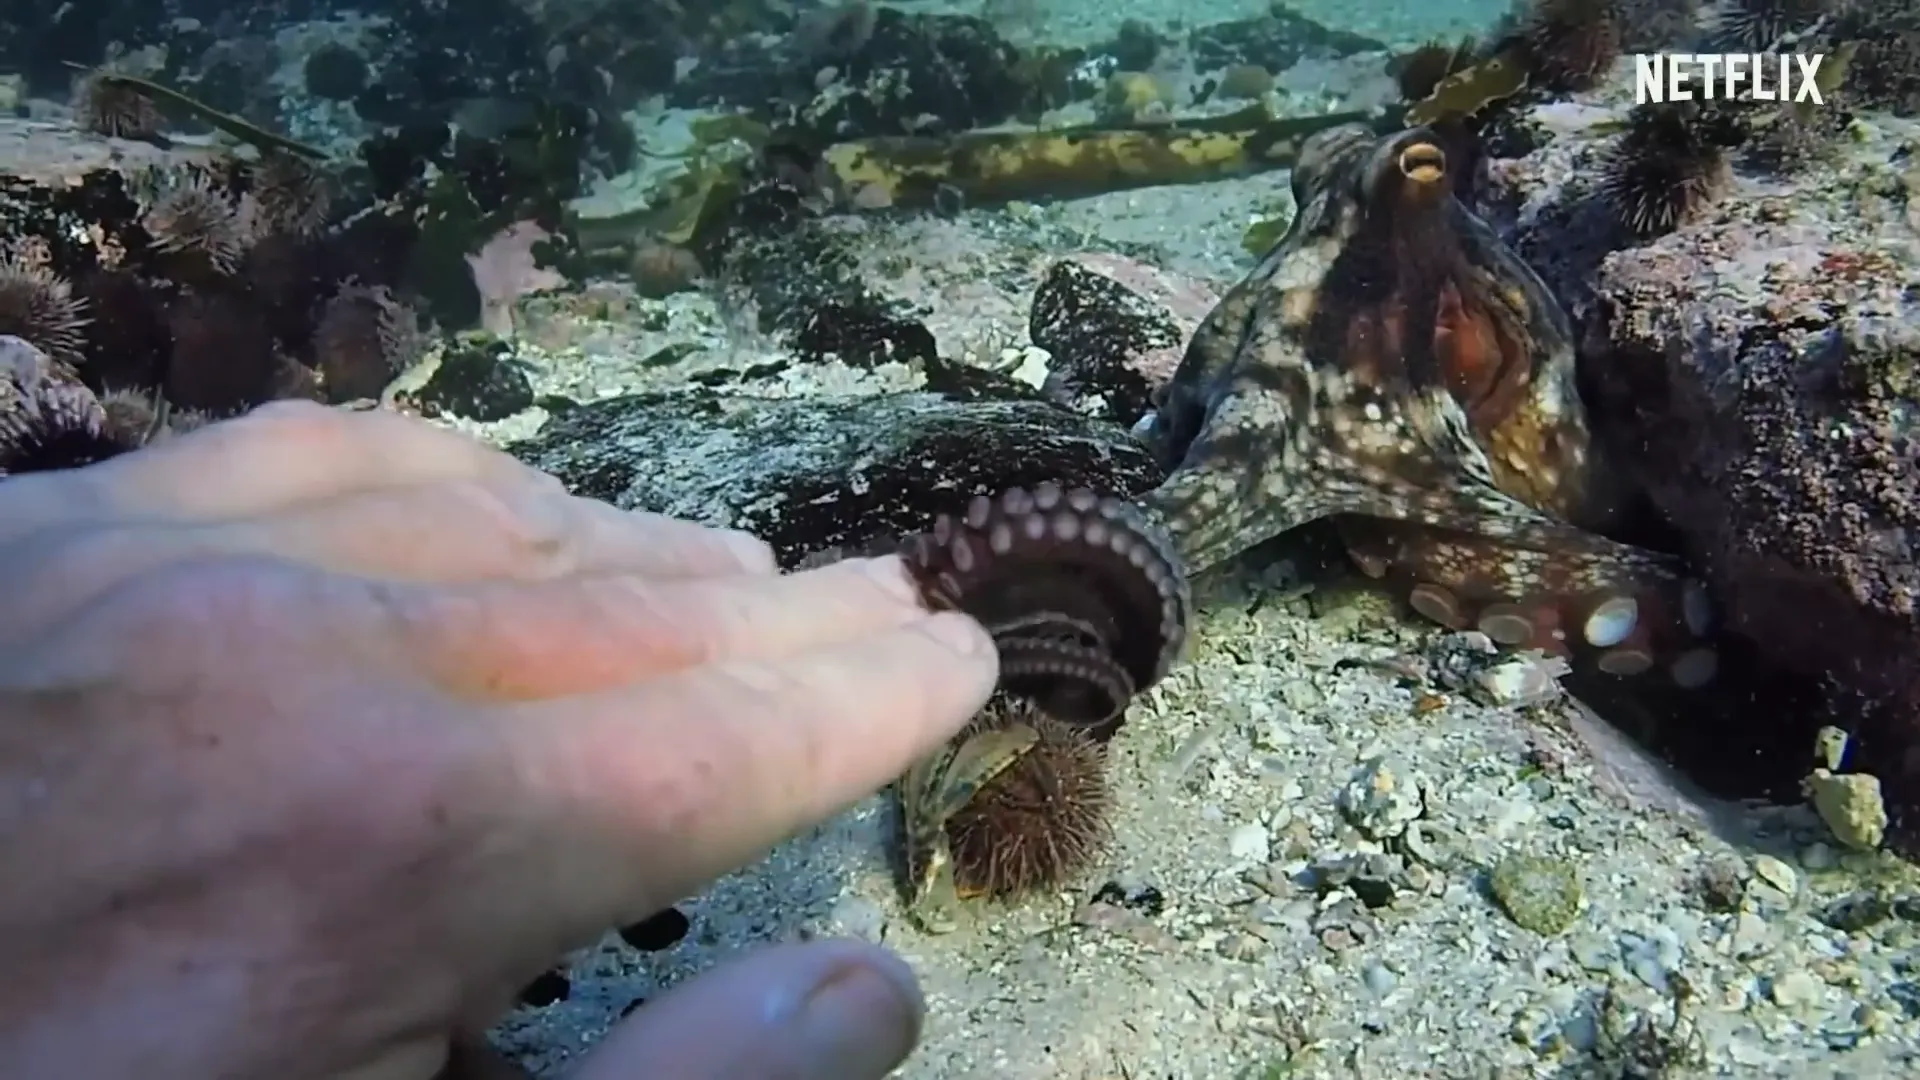
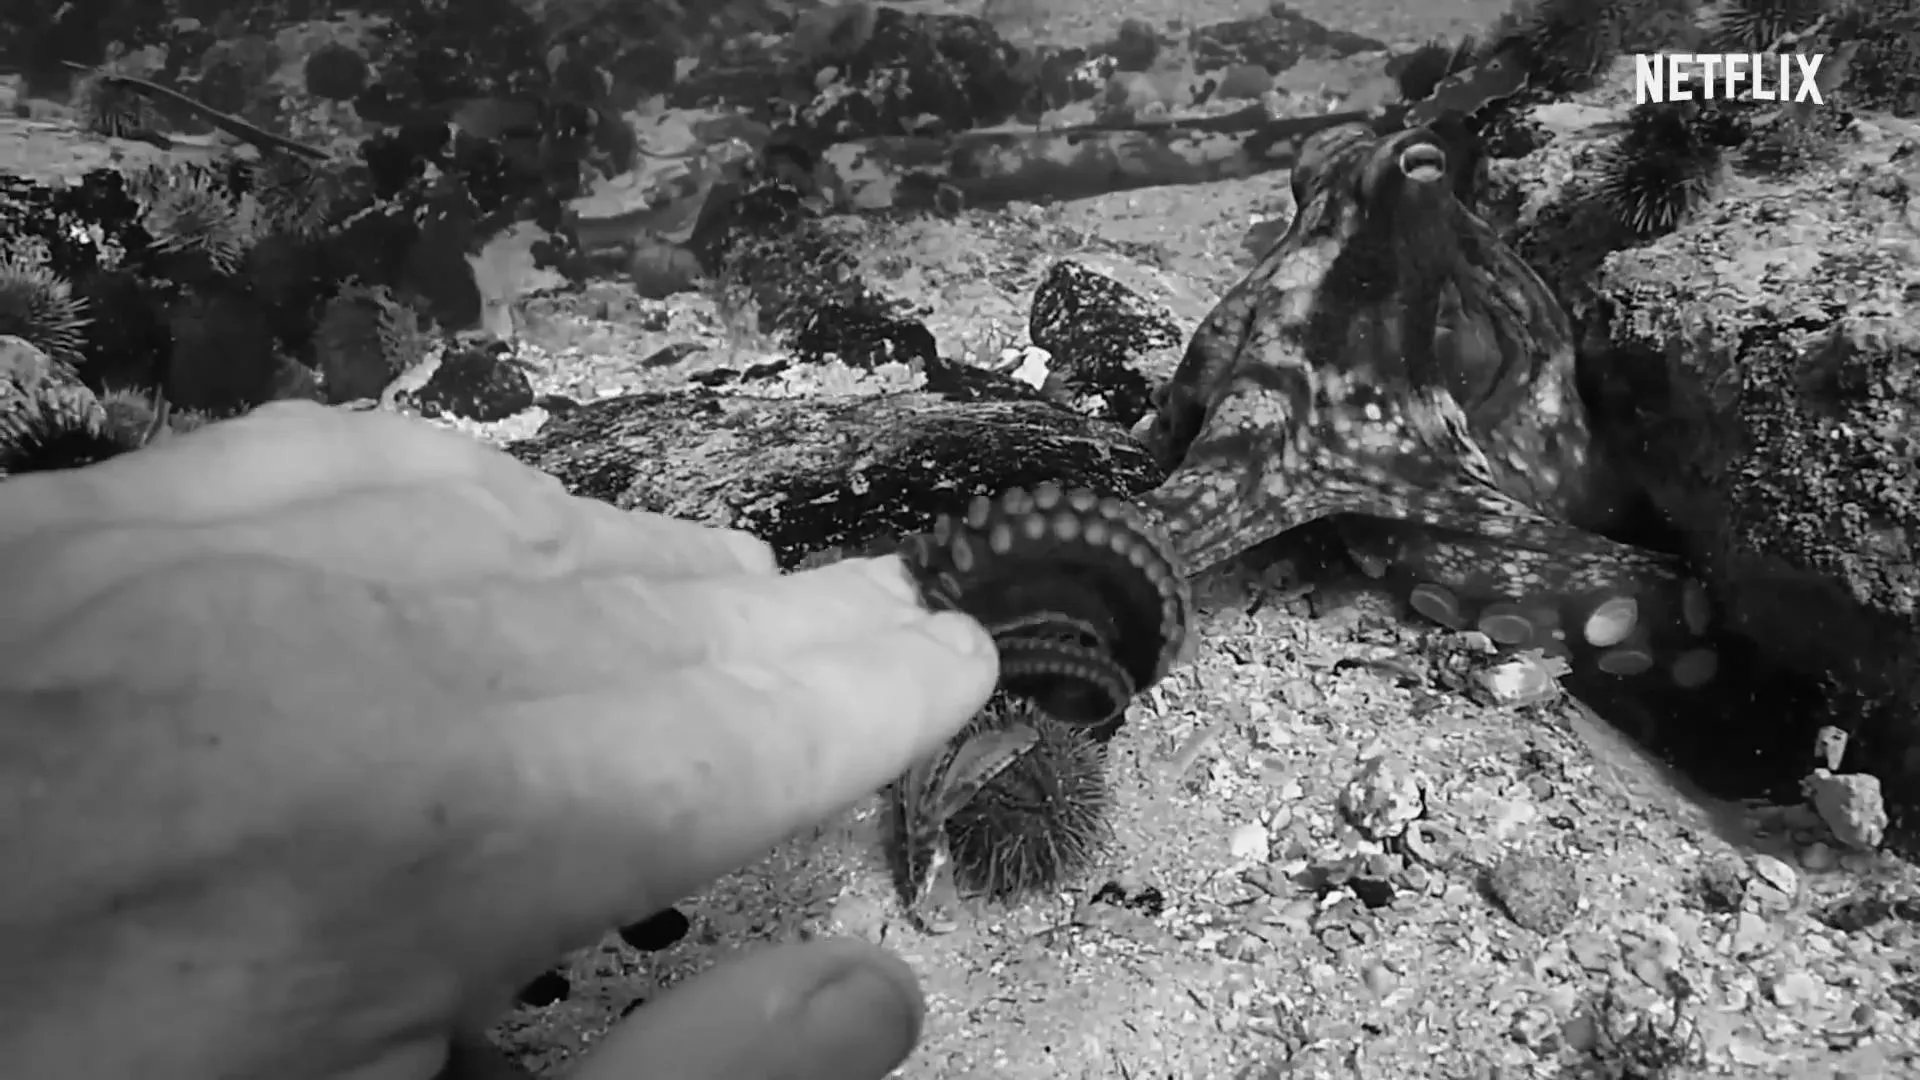
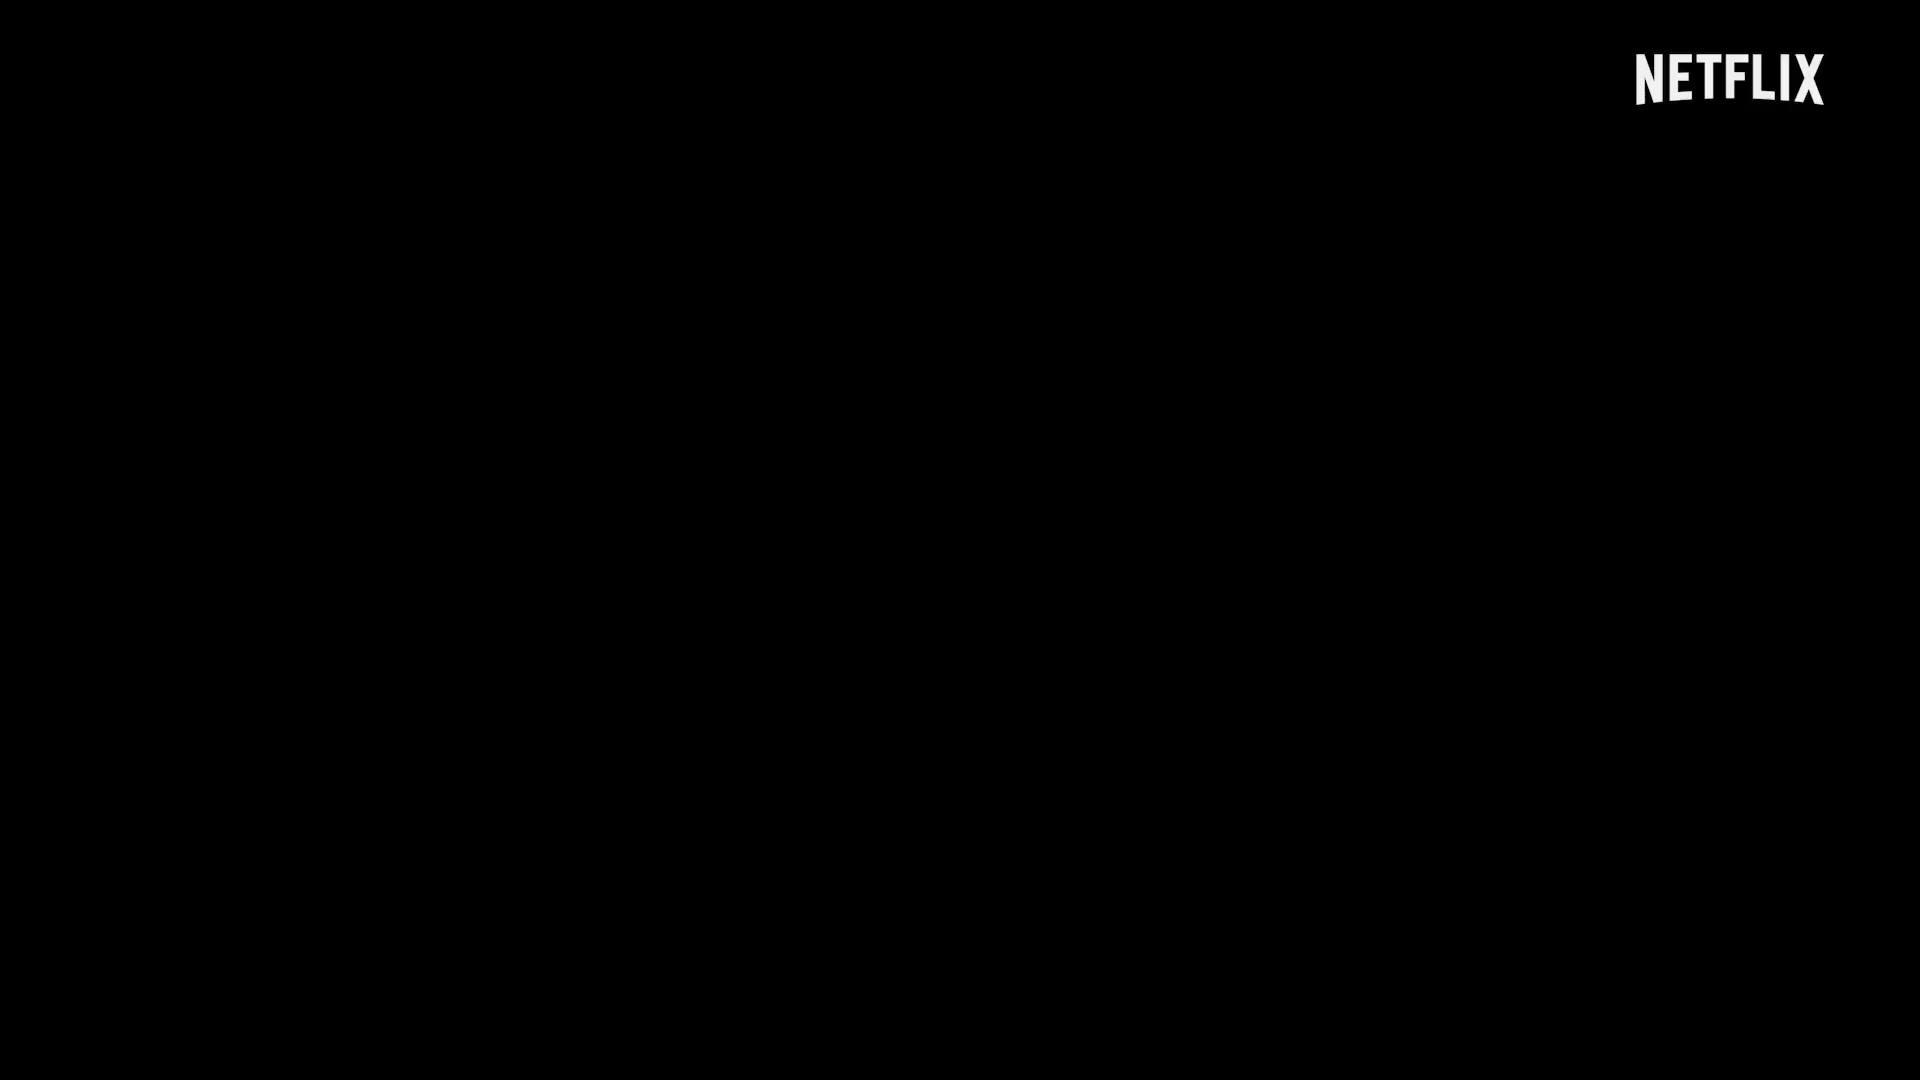
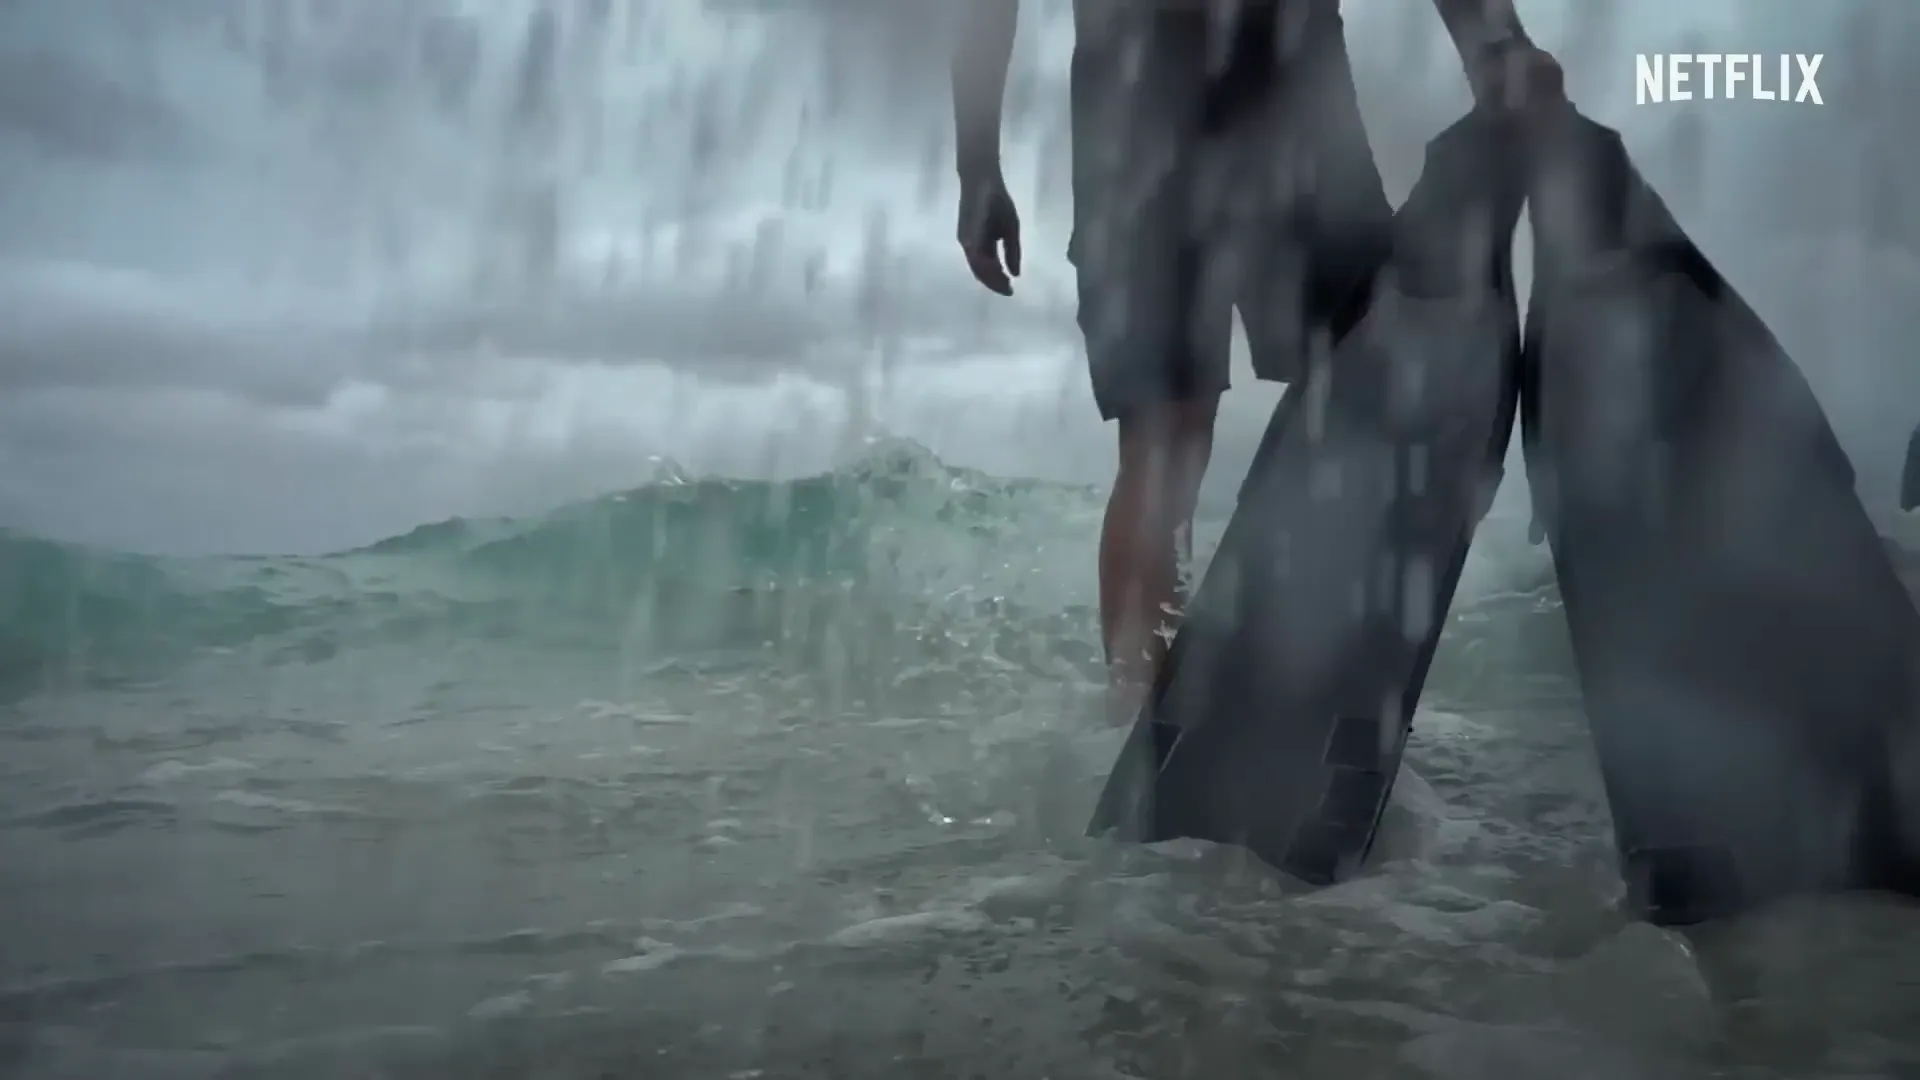
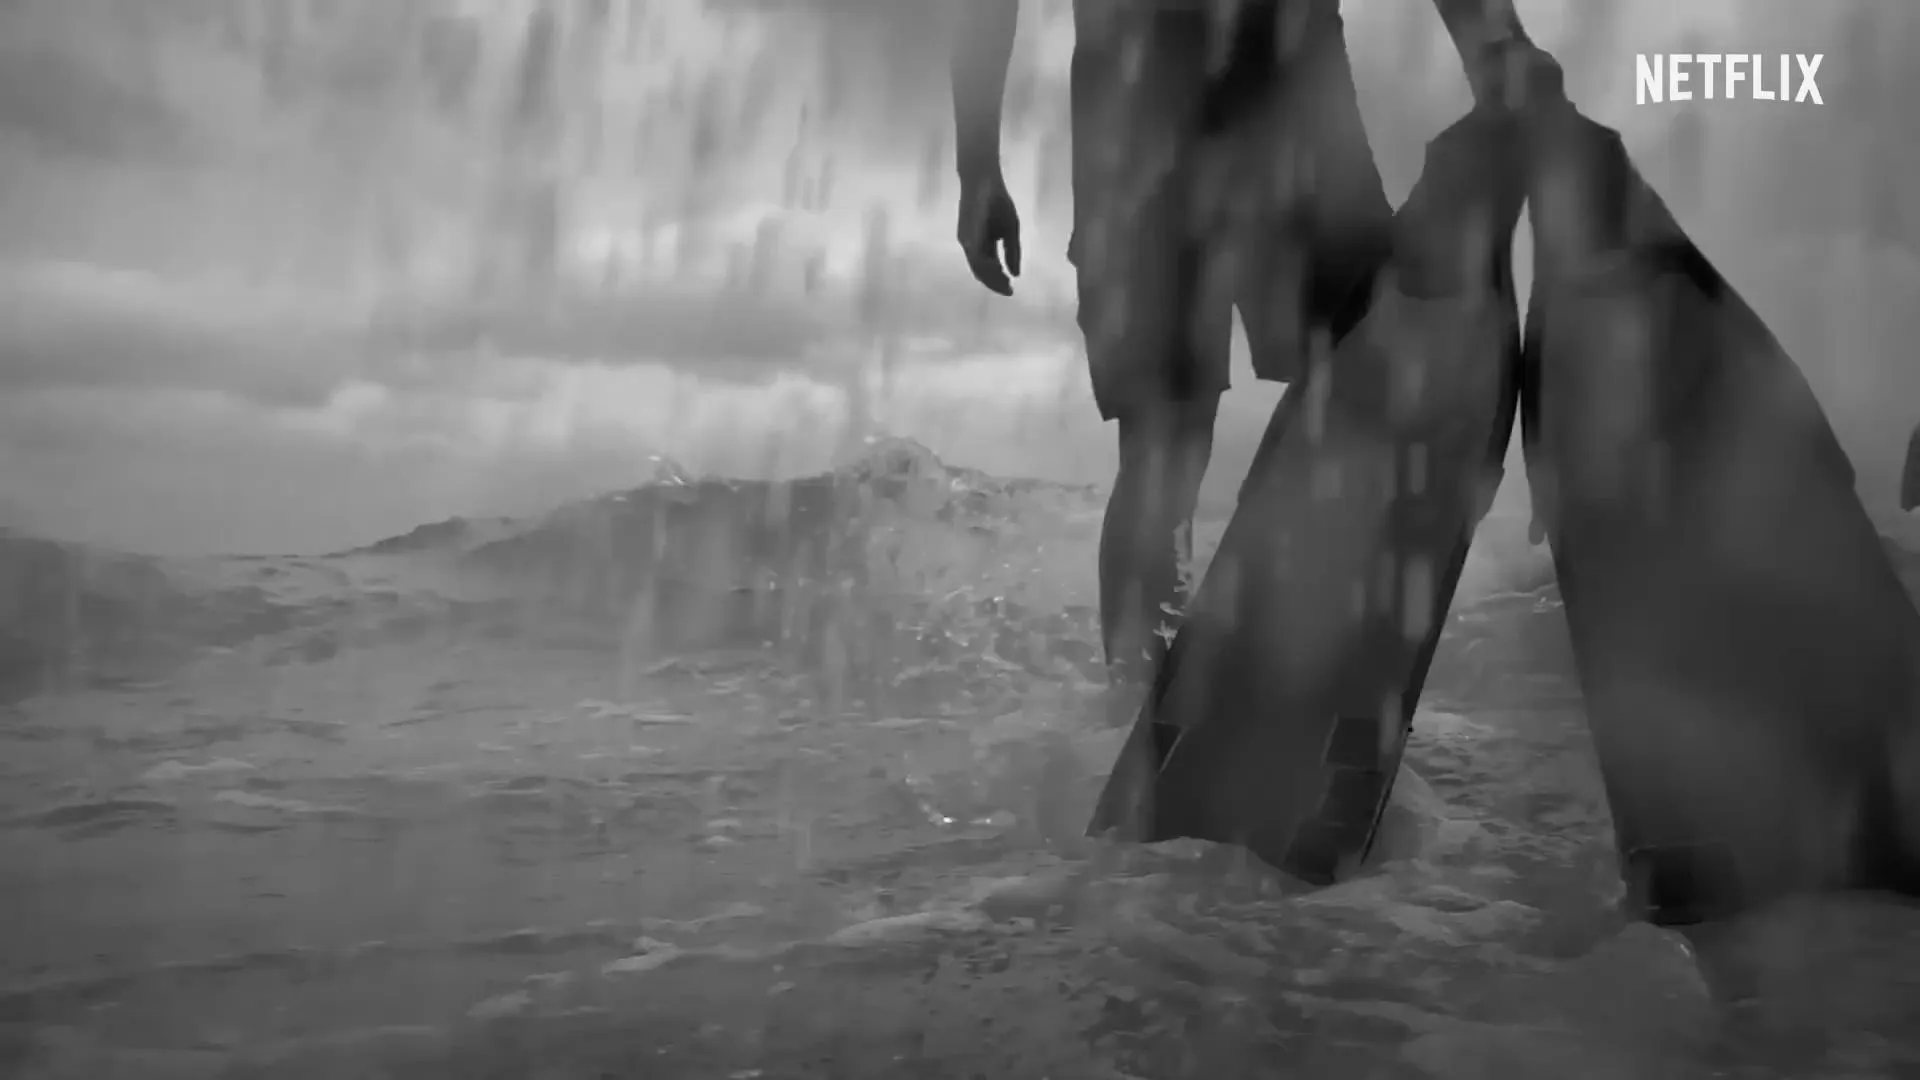
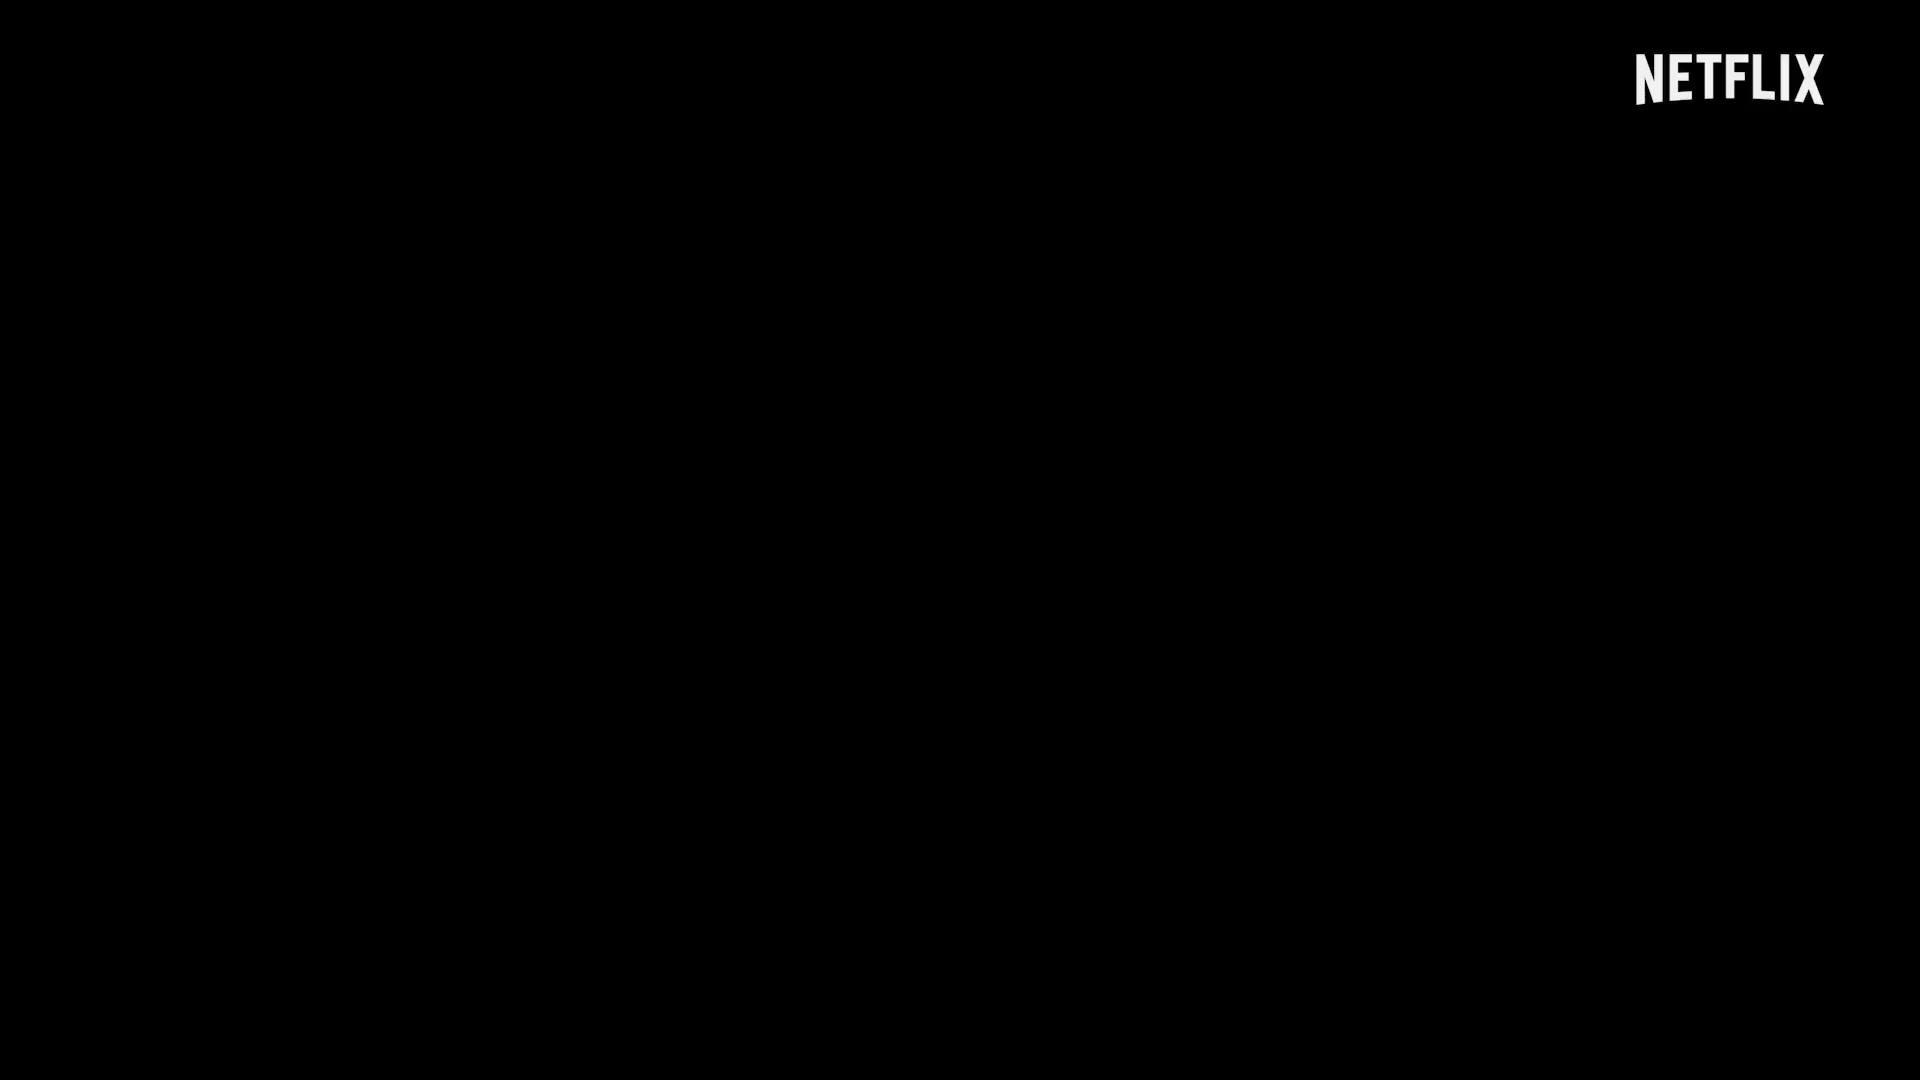

In [16]:
octo_frames_v.head(5)

### View the grayscale frames

Let's see the grayscale frames we just created and stored in B2.

pos  frame_idx  pos_msec  pos_frame  \
0    0          0       0.0          0   
1    1          1   15000.0        375   
2    2          2   30000.0        750   
3    3          3   44960.0       1124   
4    4          4   59960.0       1499   

                                               frame  \
0  <PIL.Image.Image image mode=RGB size=1920x1080...   
1  <PIL.Image.Image image mode=RGB size=1920x1080...   
2  <PIL.Image.Image image mode=RGB size=1920x1080...   
3  <PIL.Image.Image image mode=RGB size=1920x1080...   
4  <PIL.Image.Image image mode=RGB size=1920x1080...   

                                            frame_bw  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                               video  
0  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
1  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
2  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
3  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...  
4  /Users/jdeleon/Documents/oss/b2-pixeltable/sou...
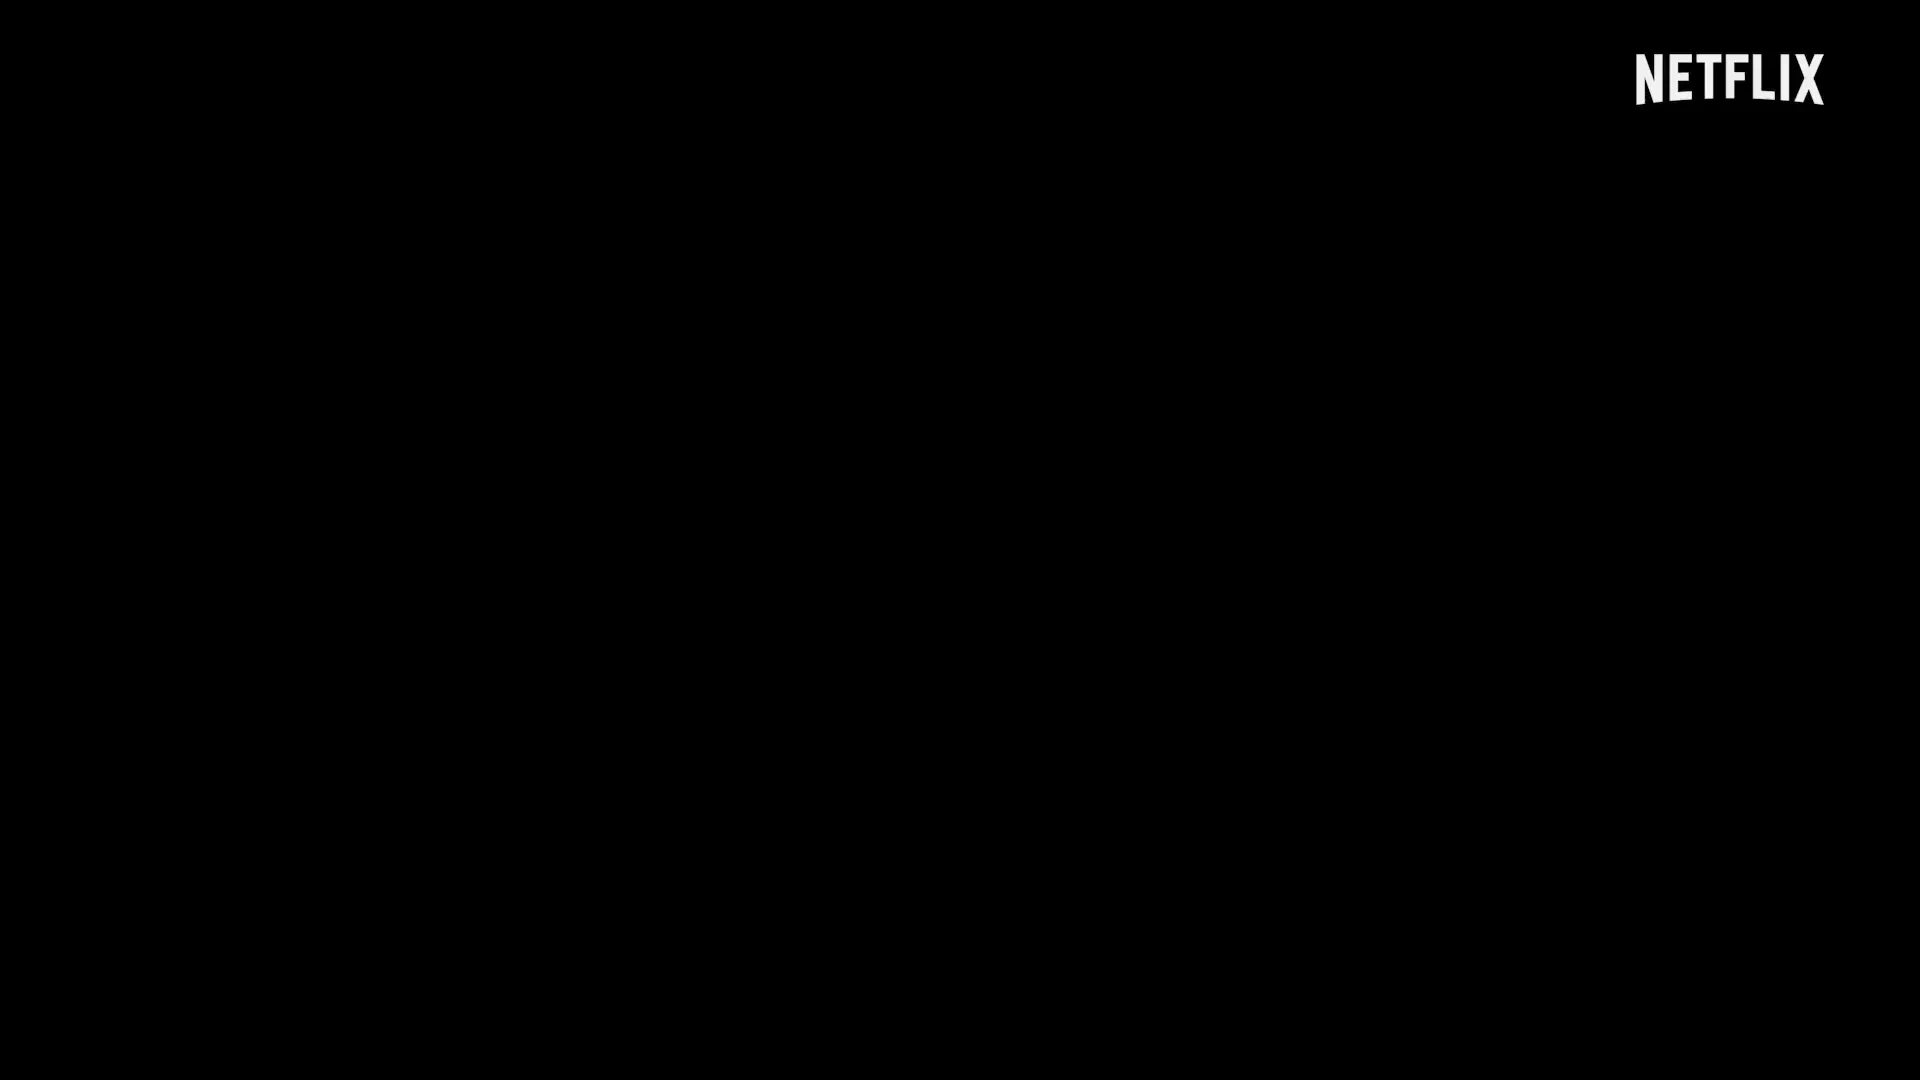
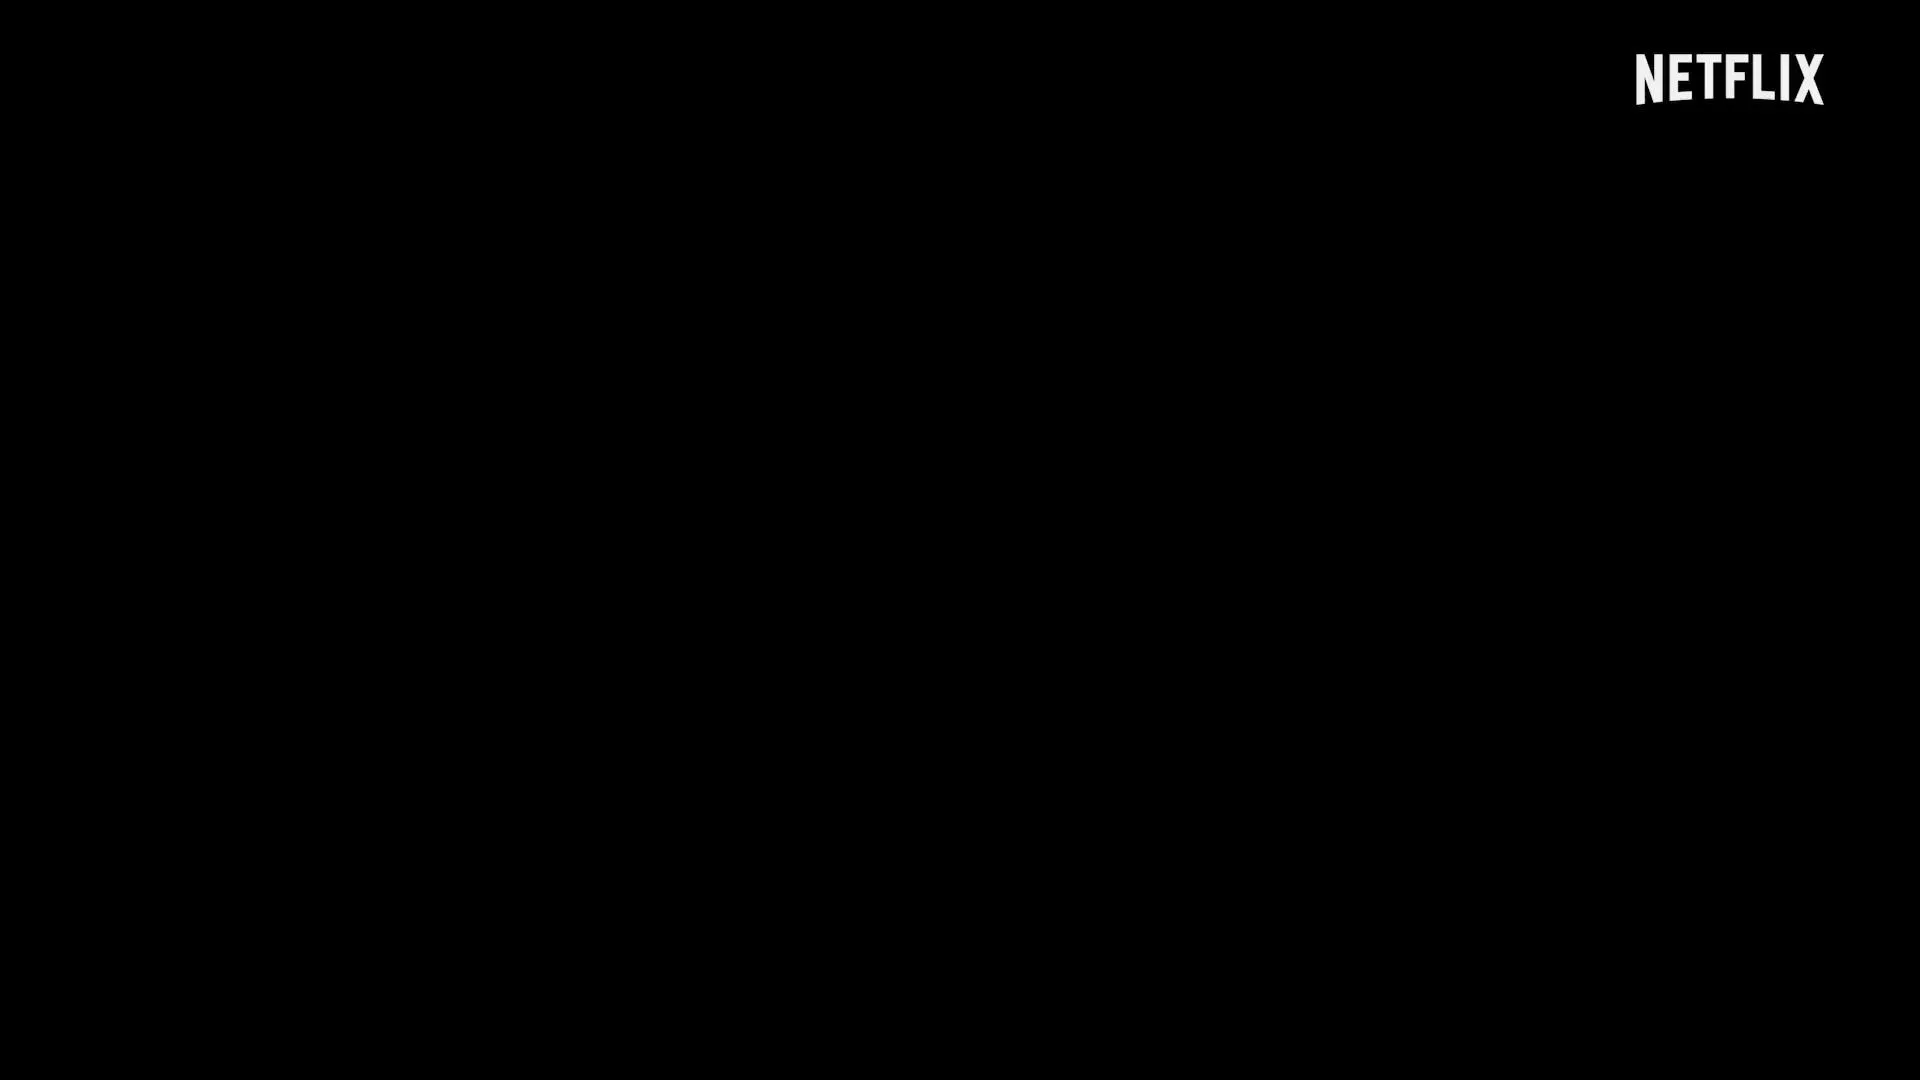
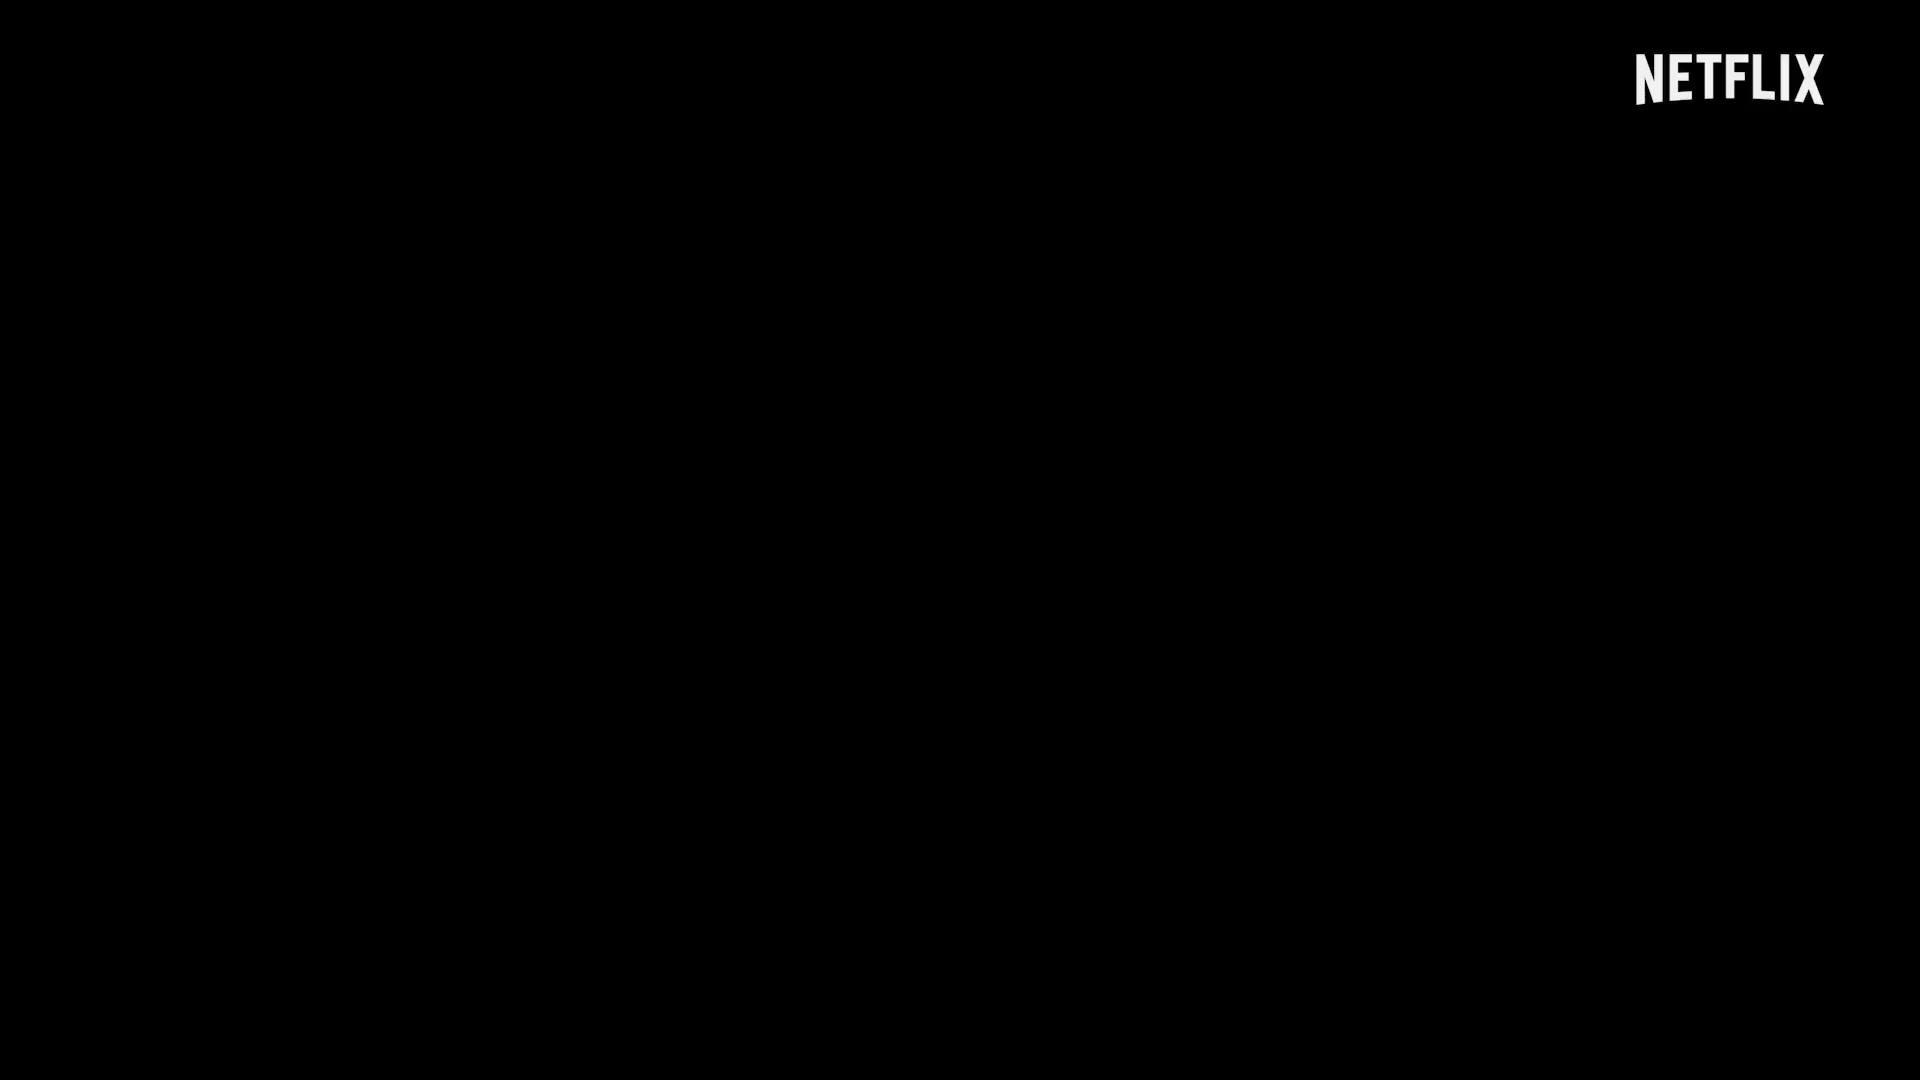
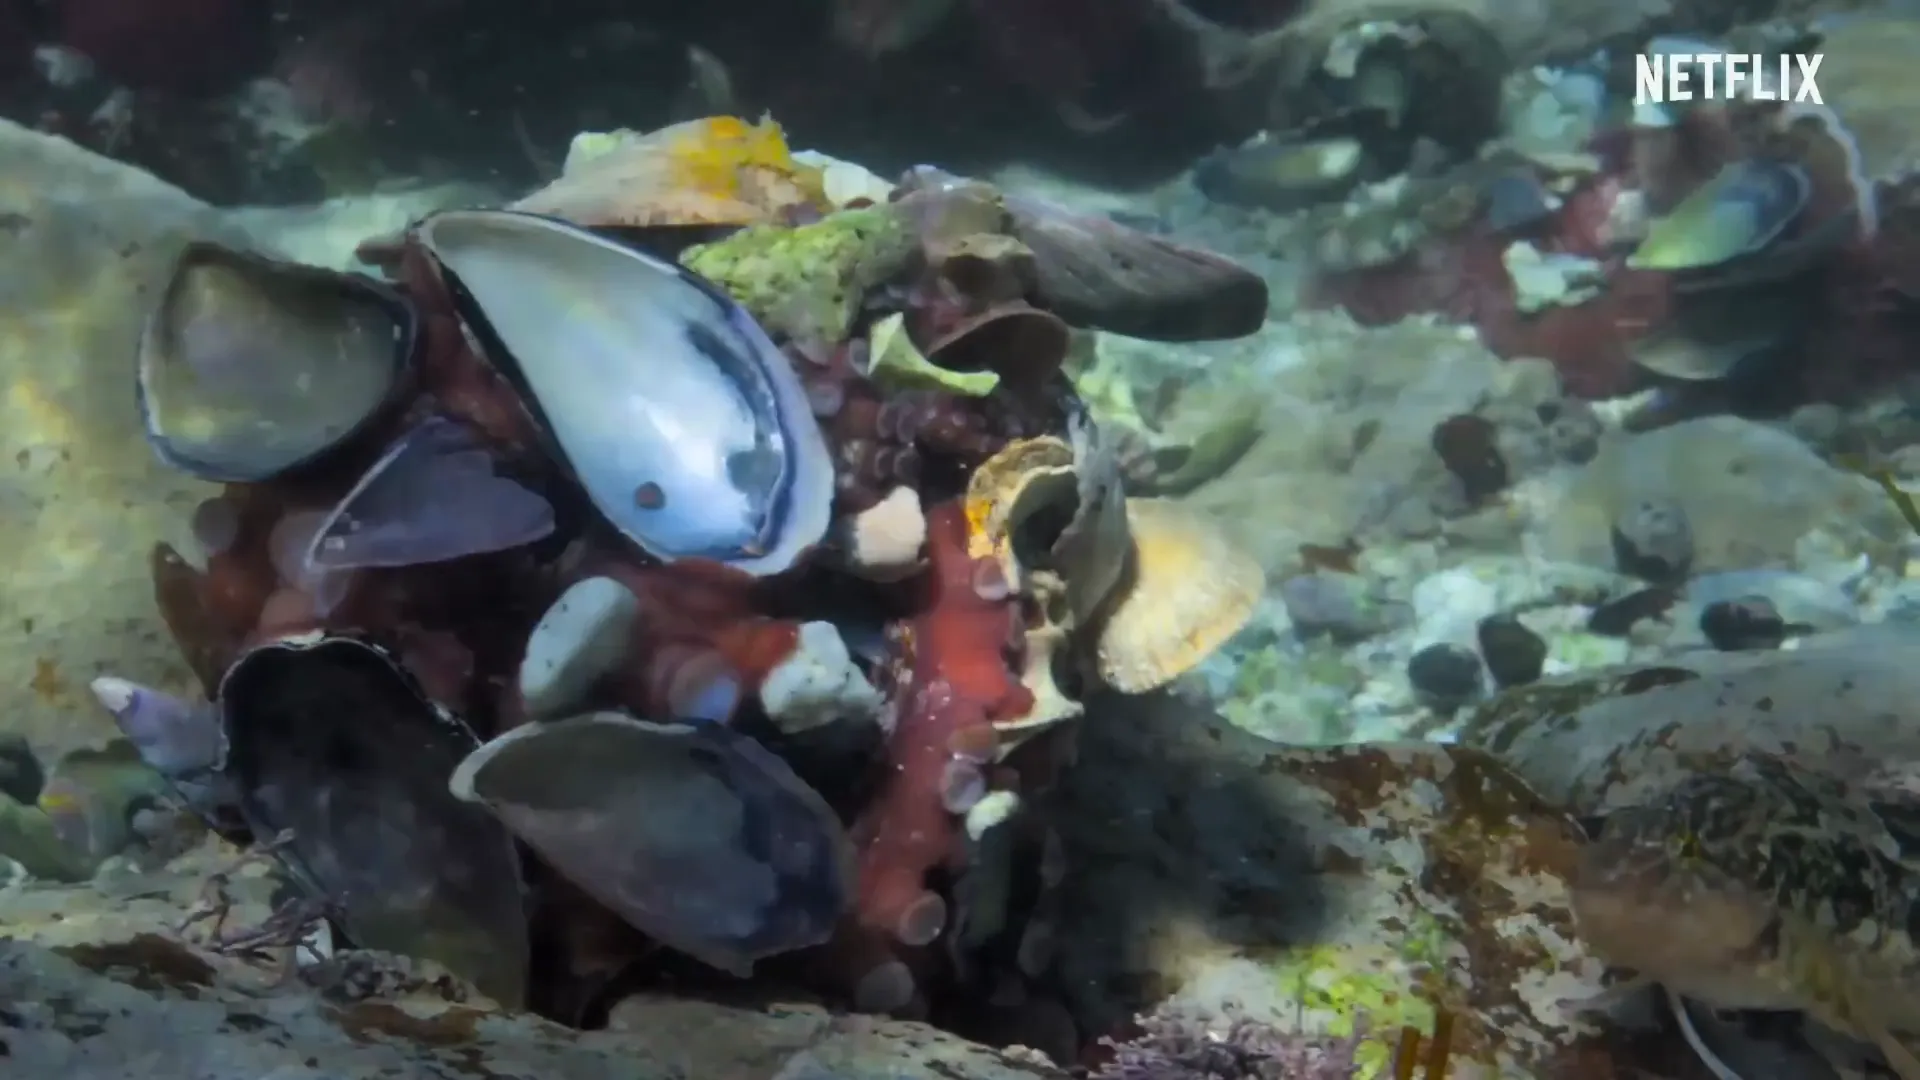
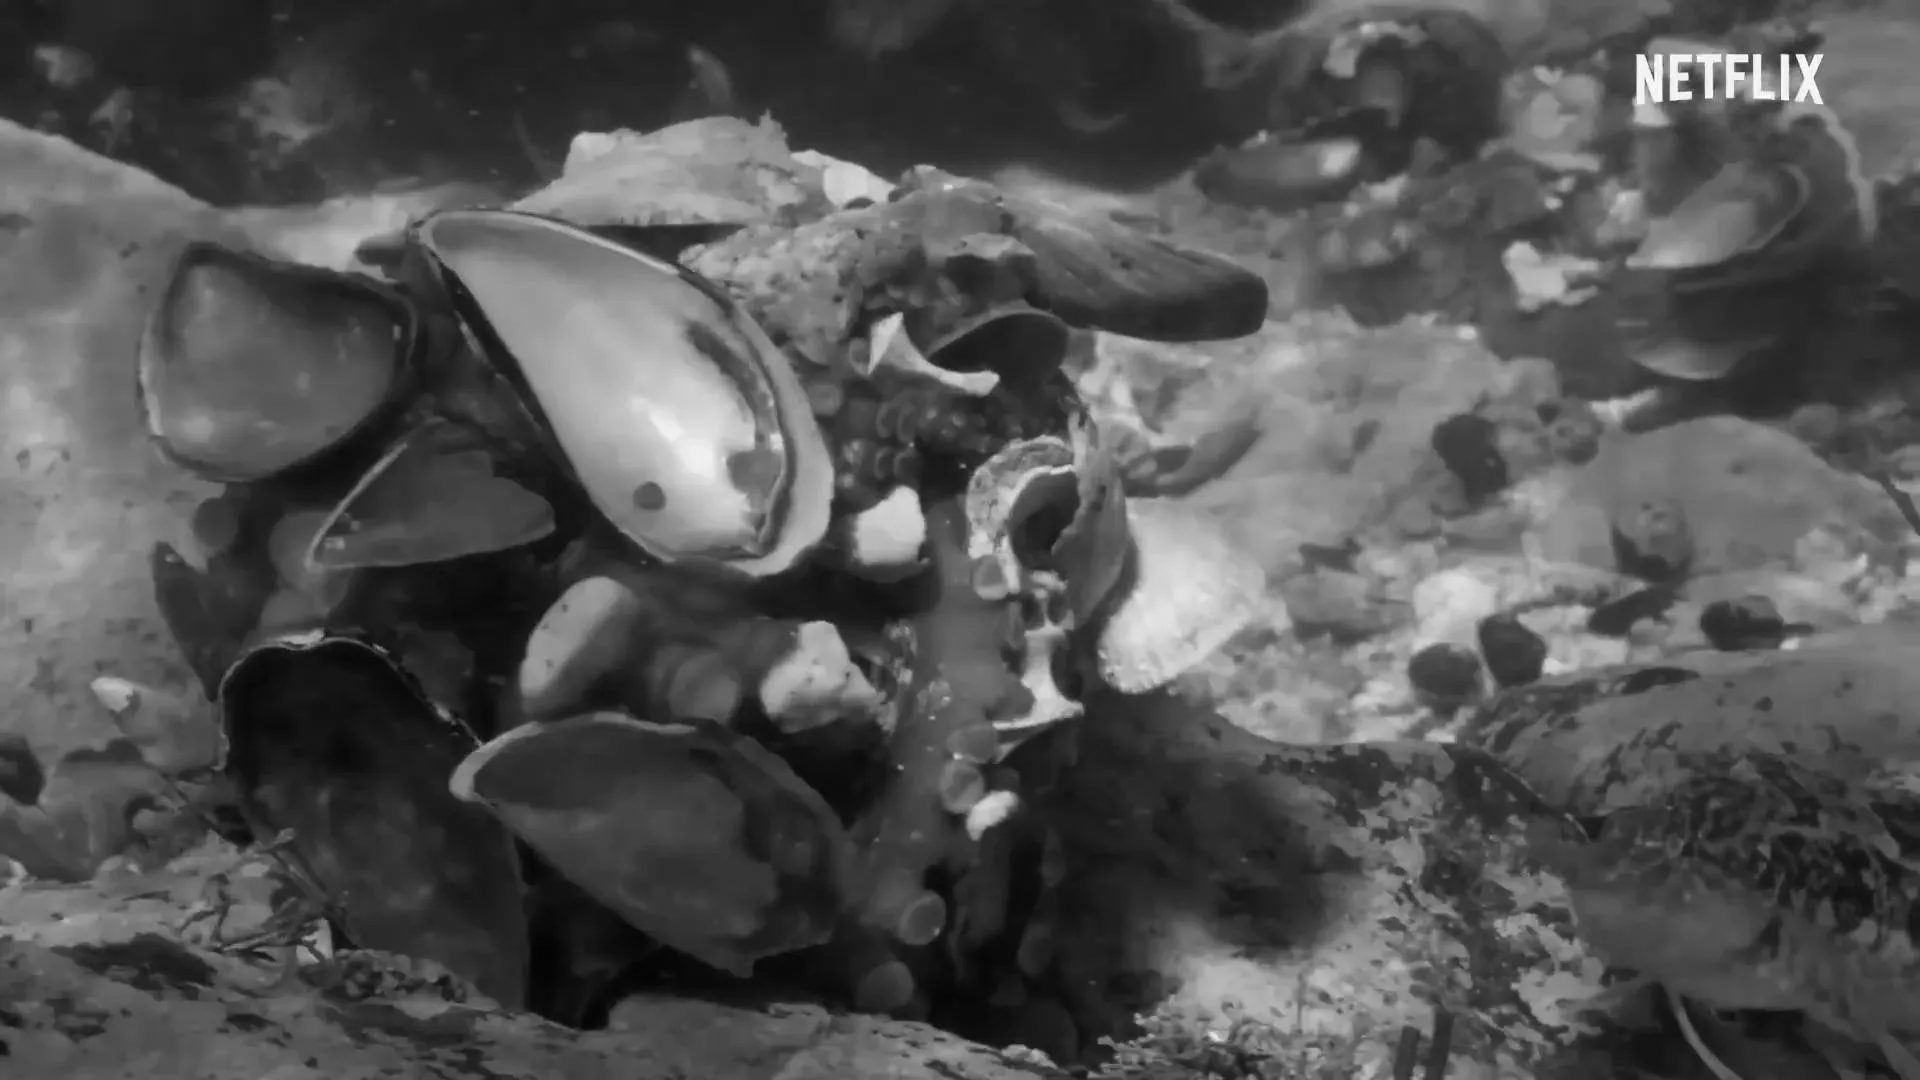
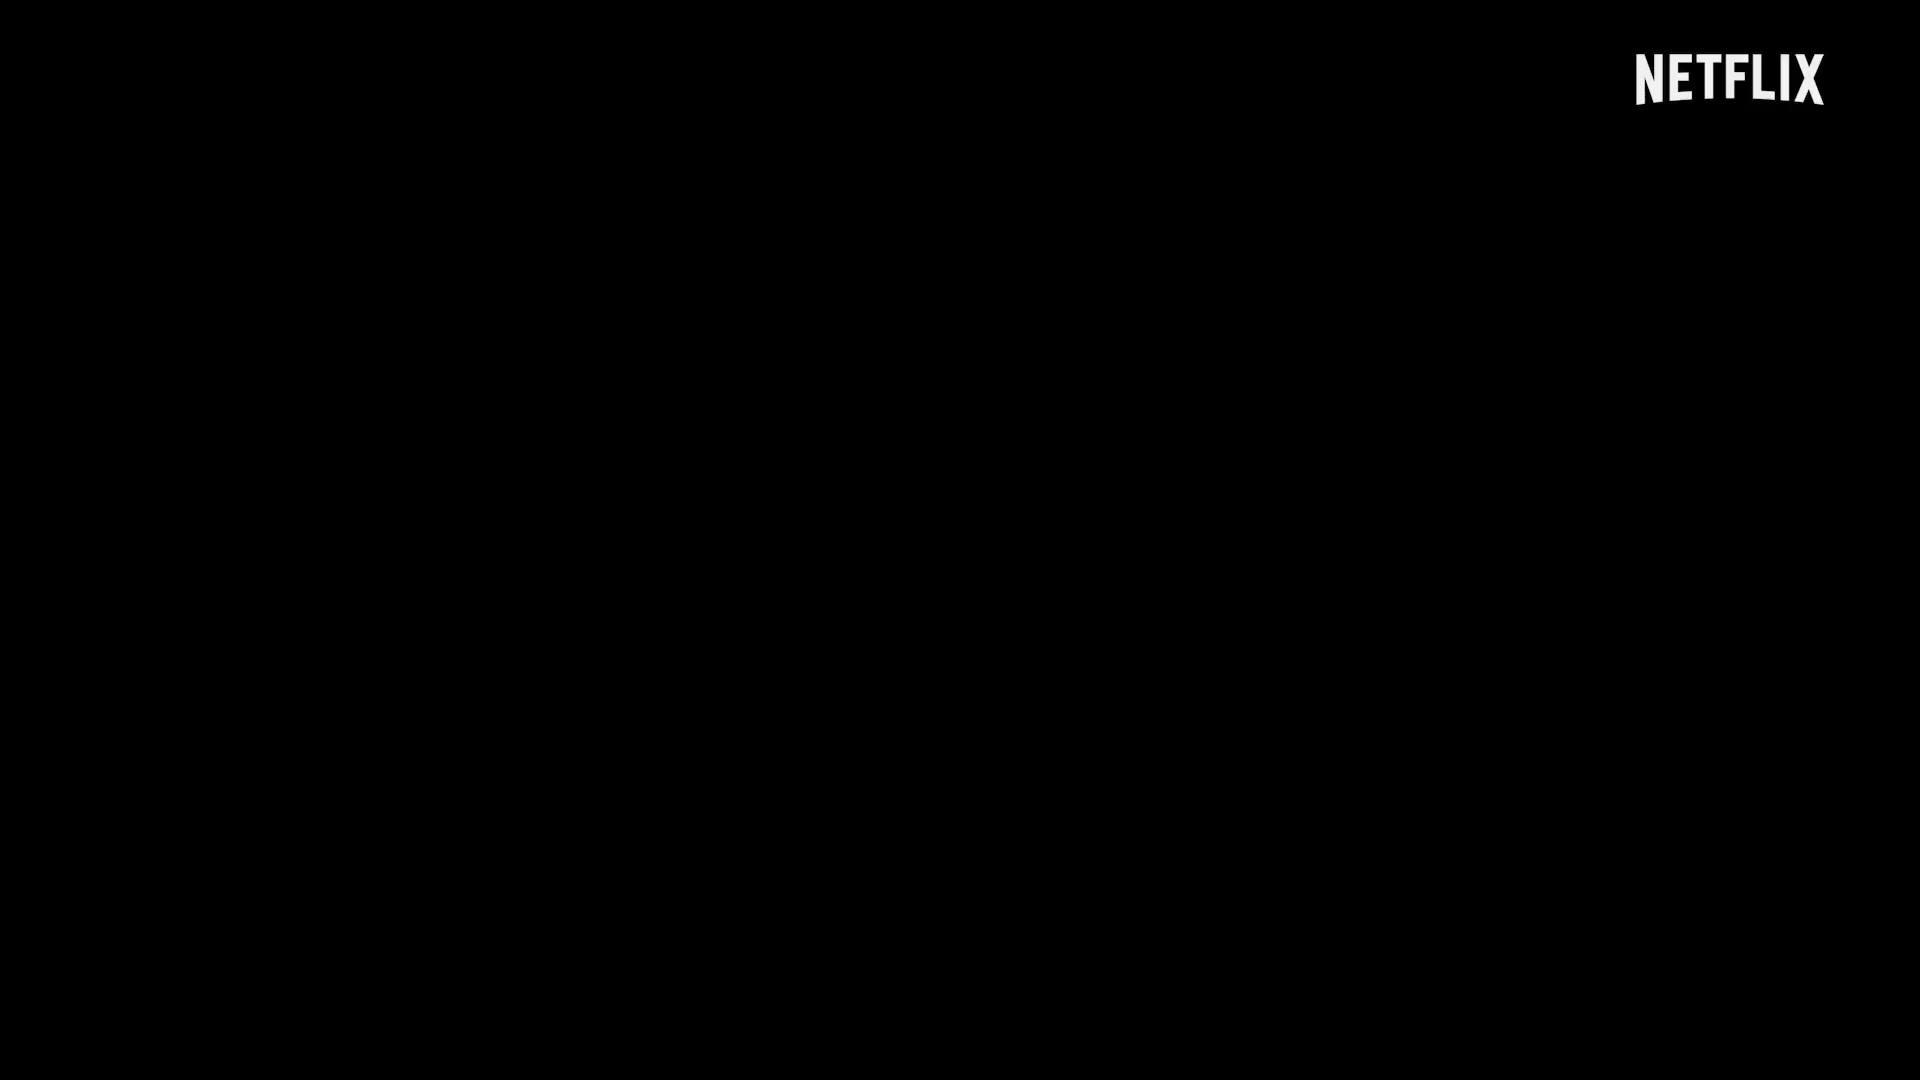
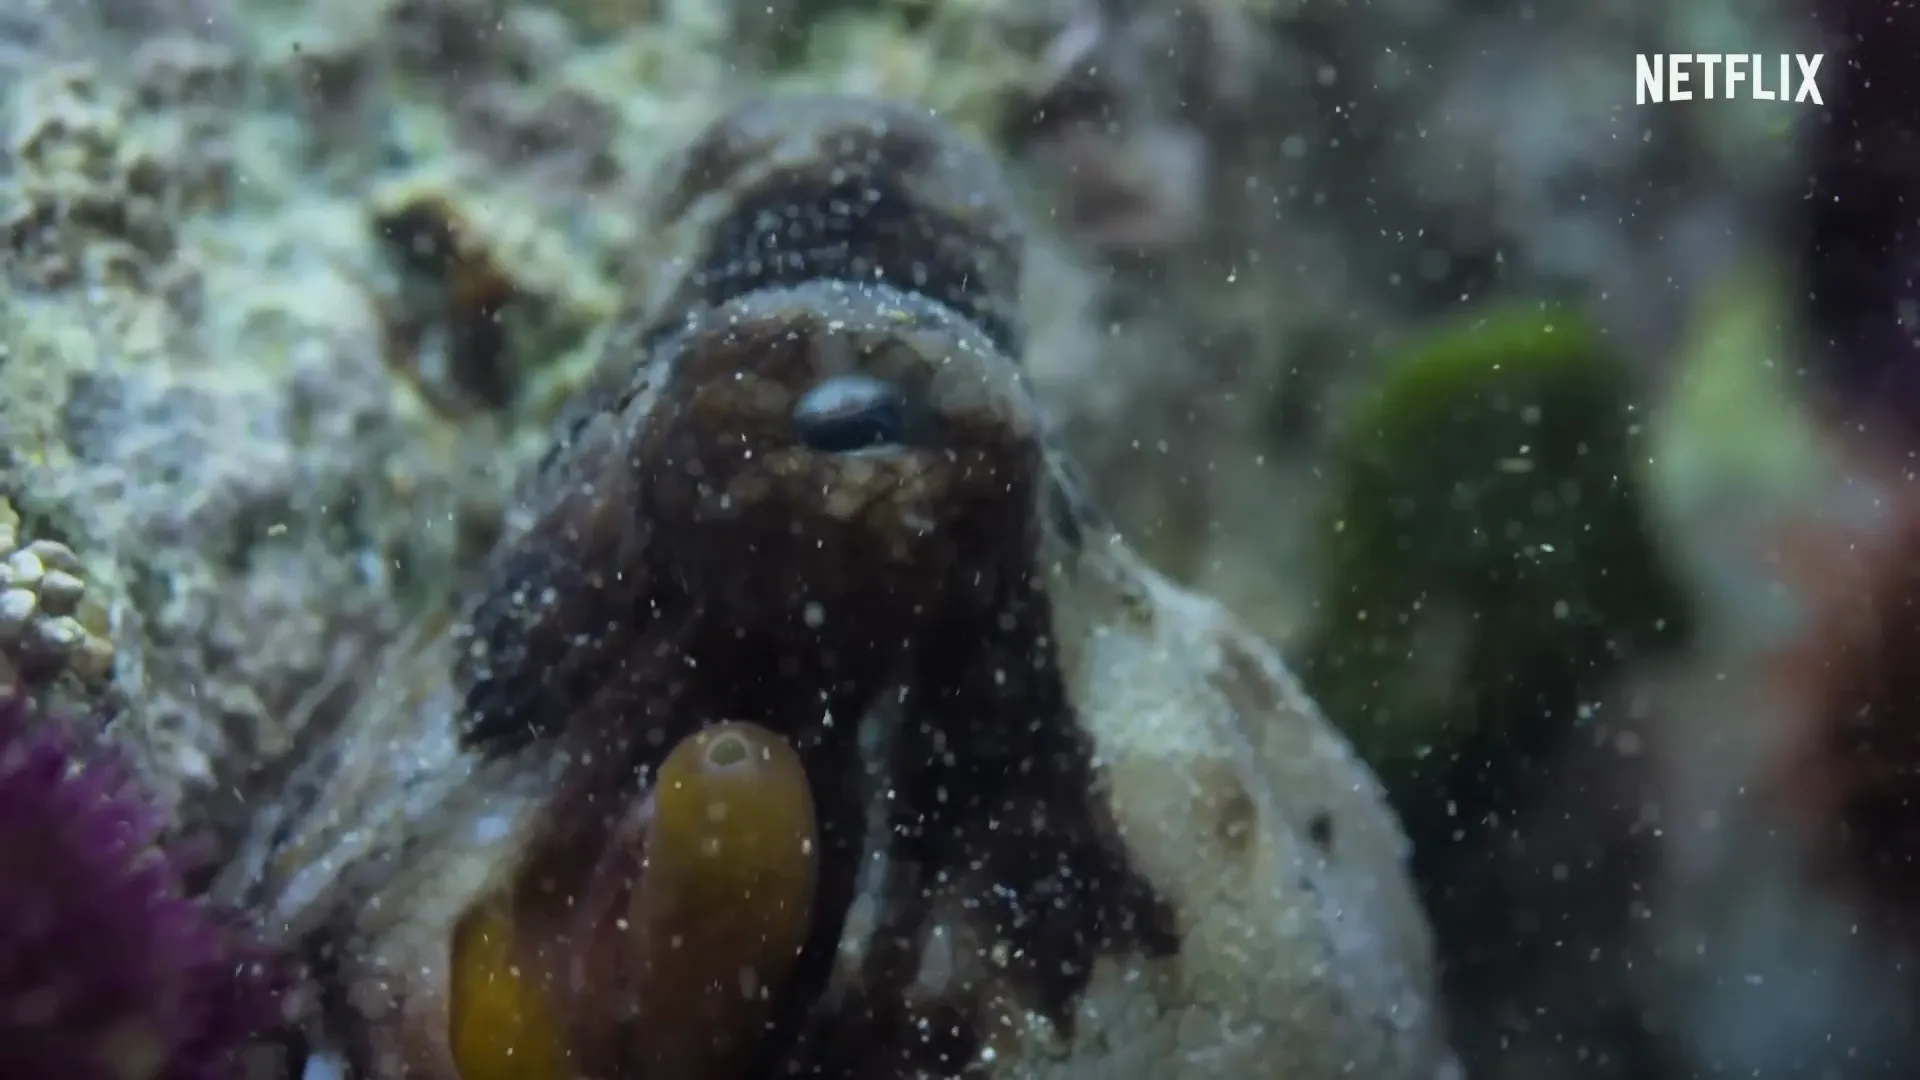
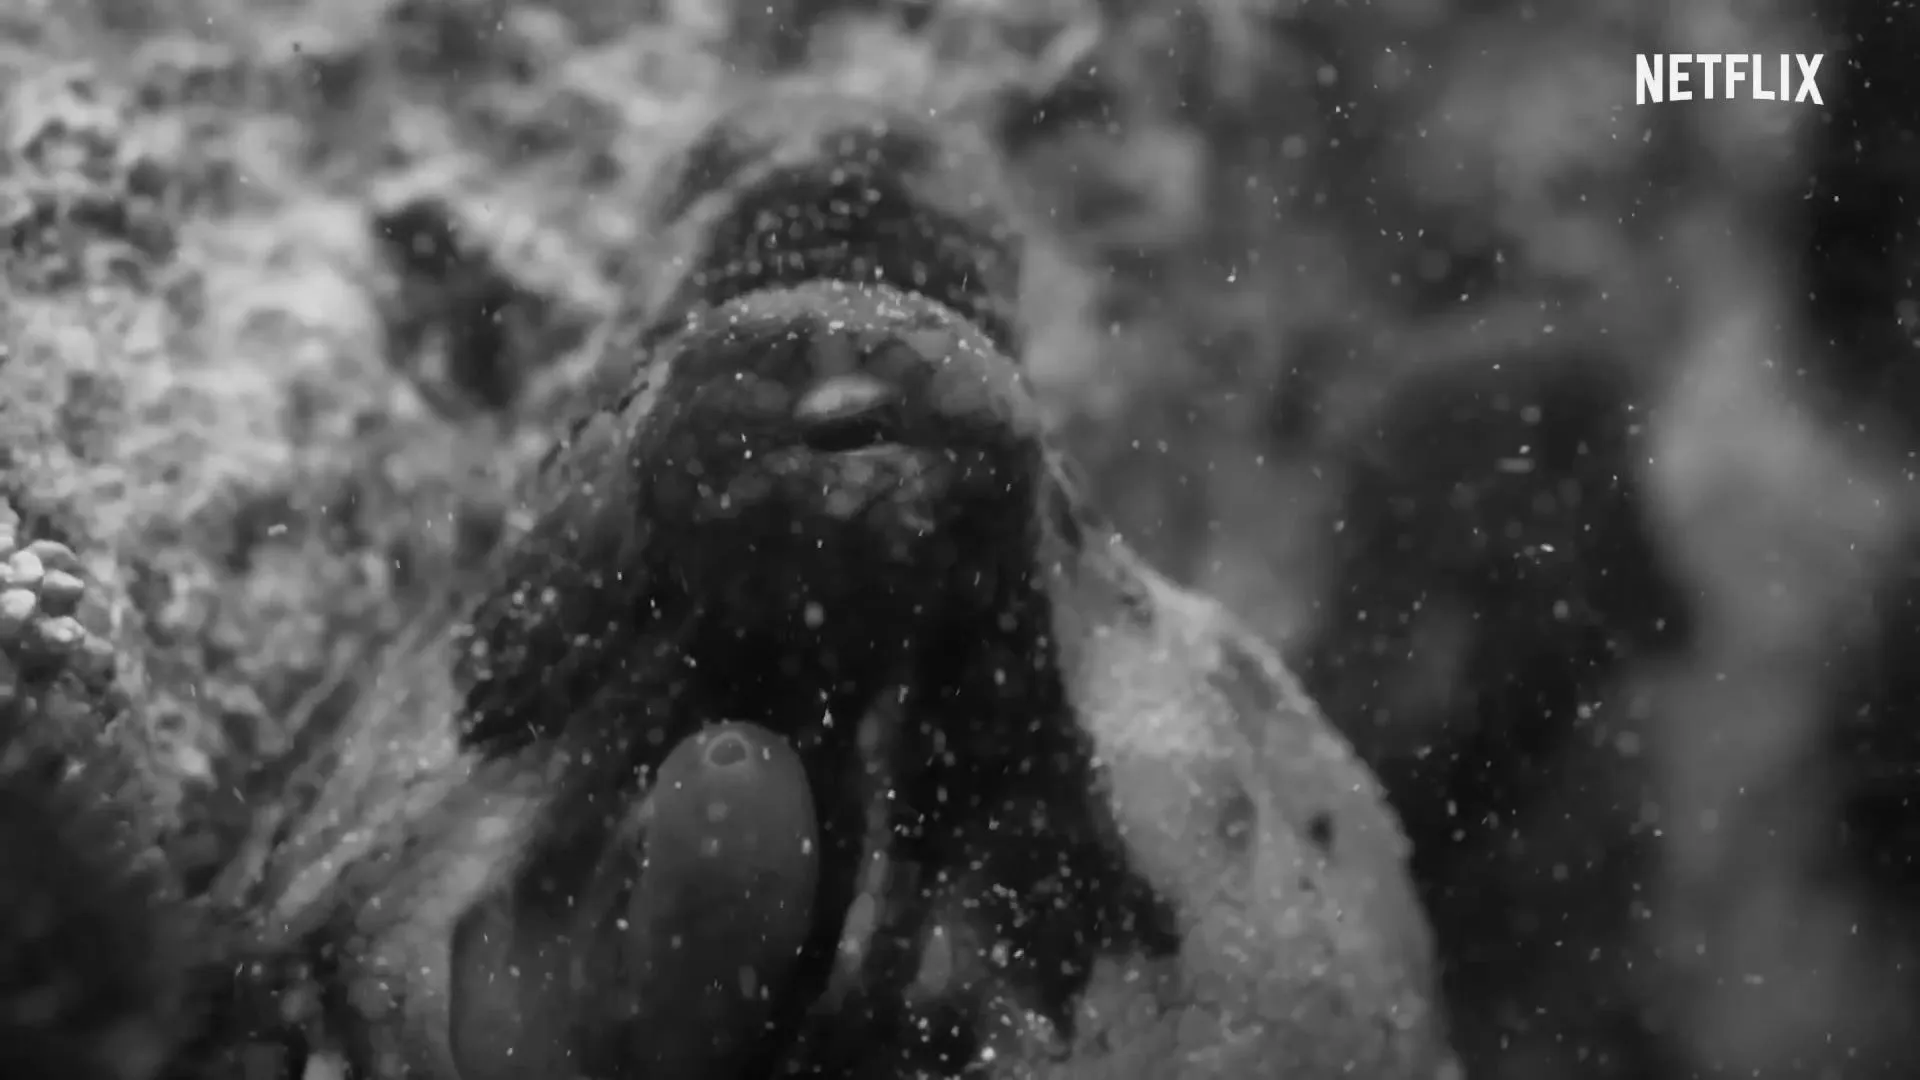
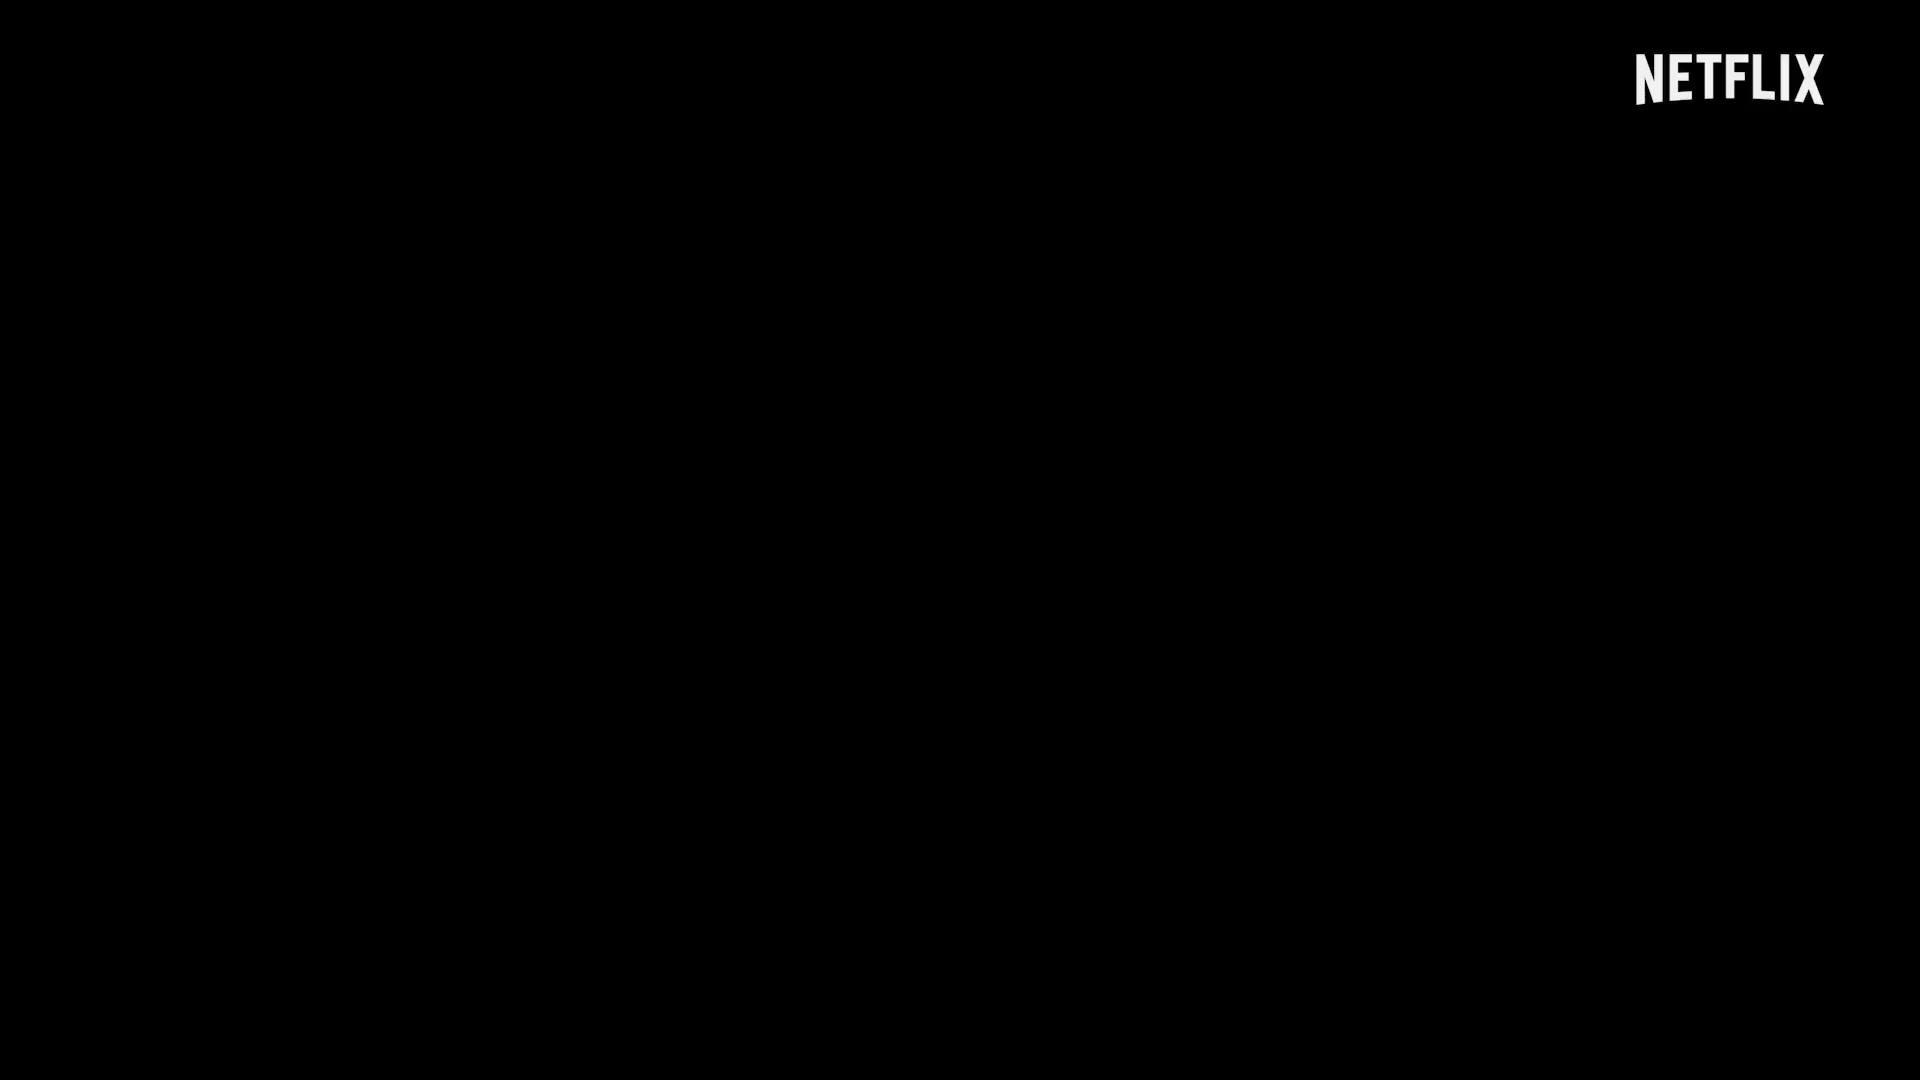
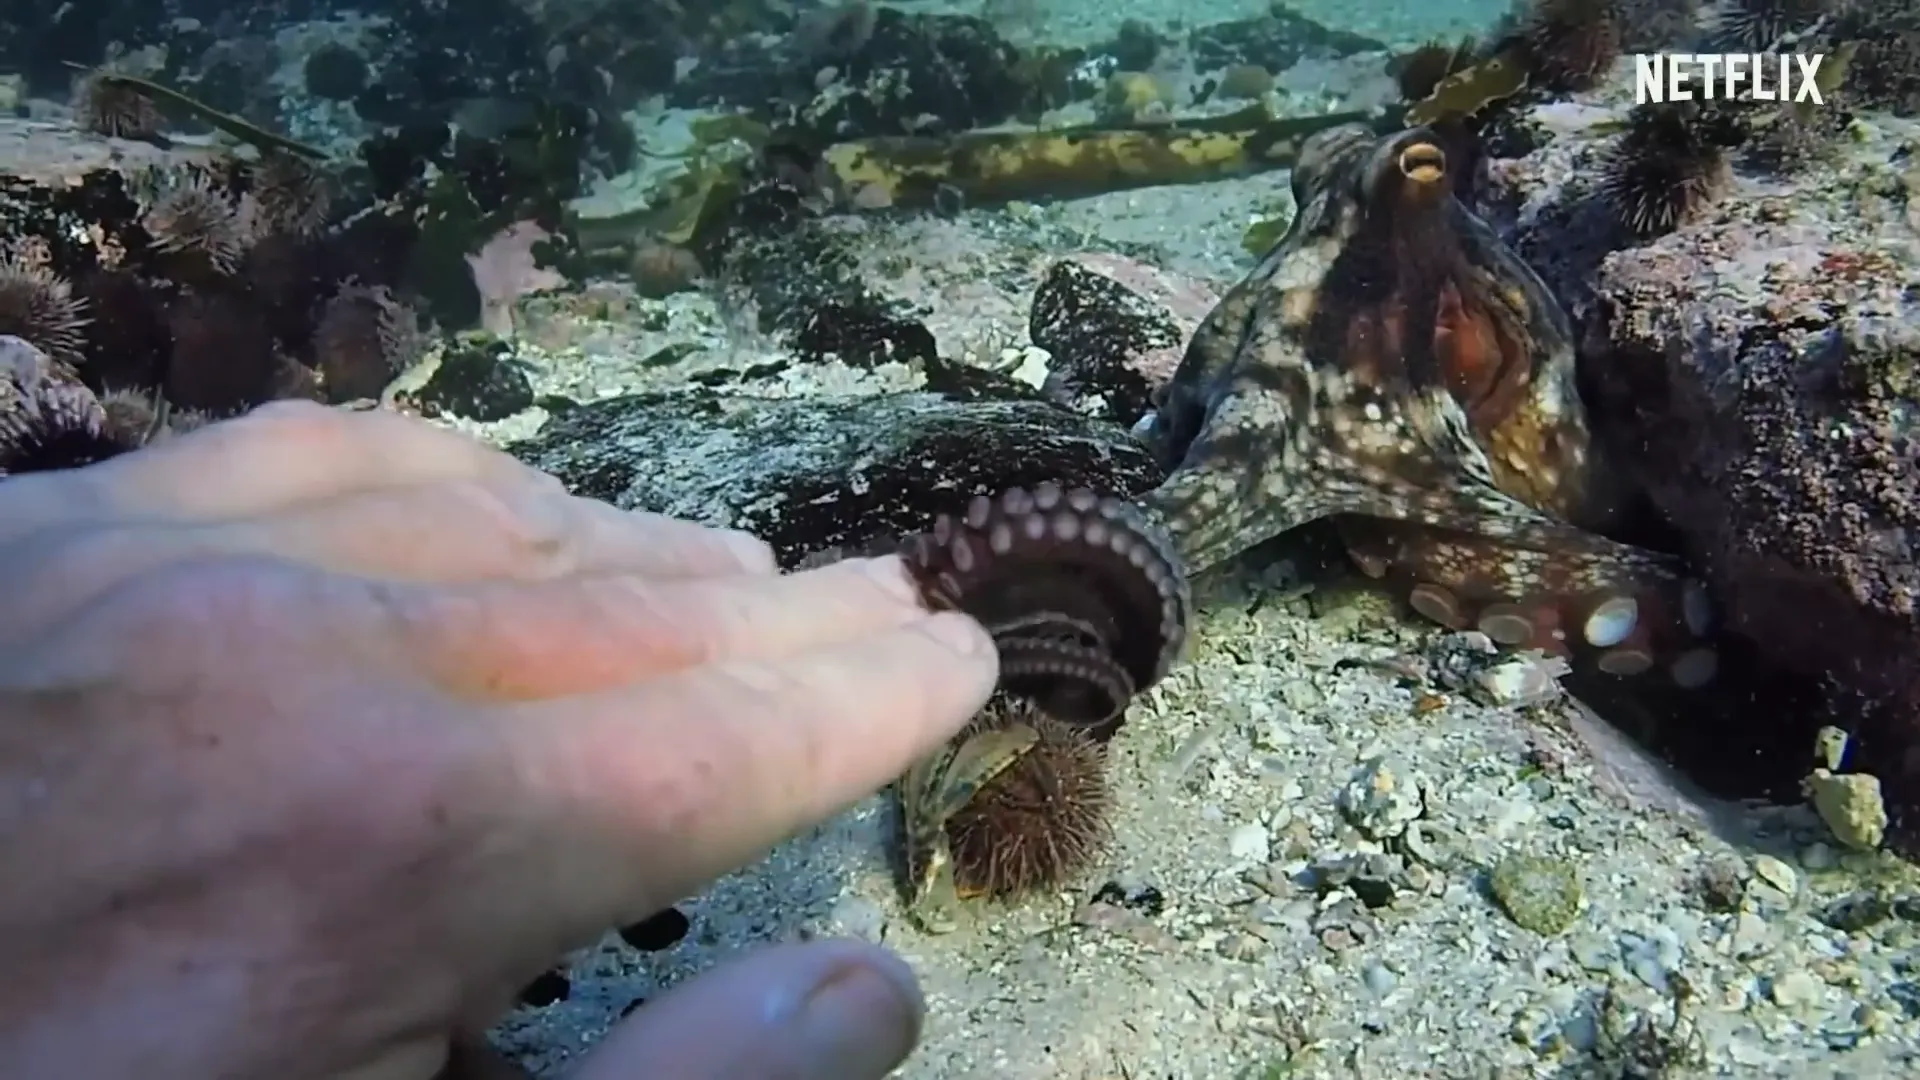
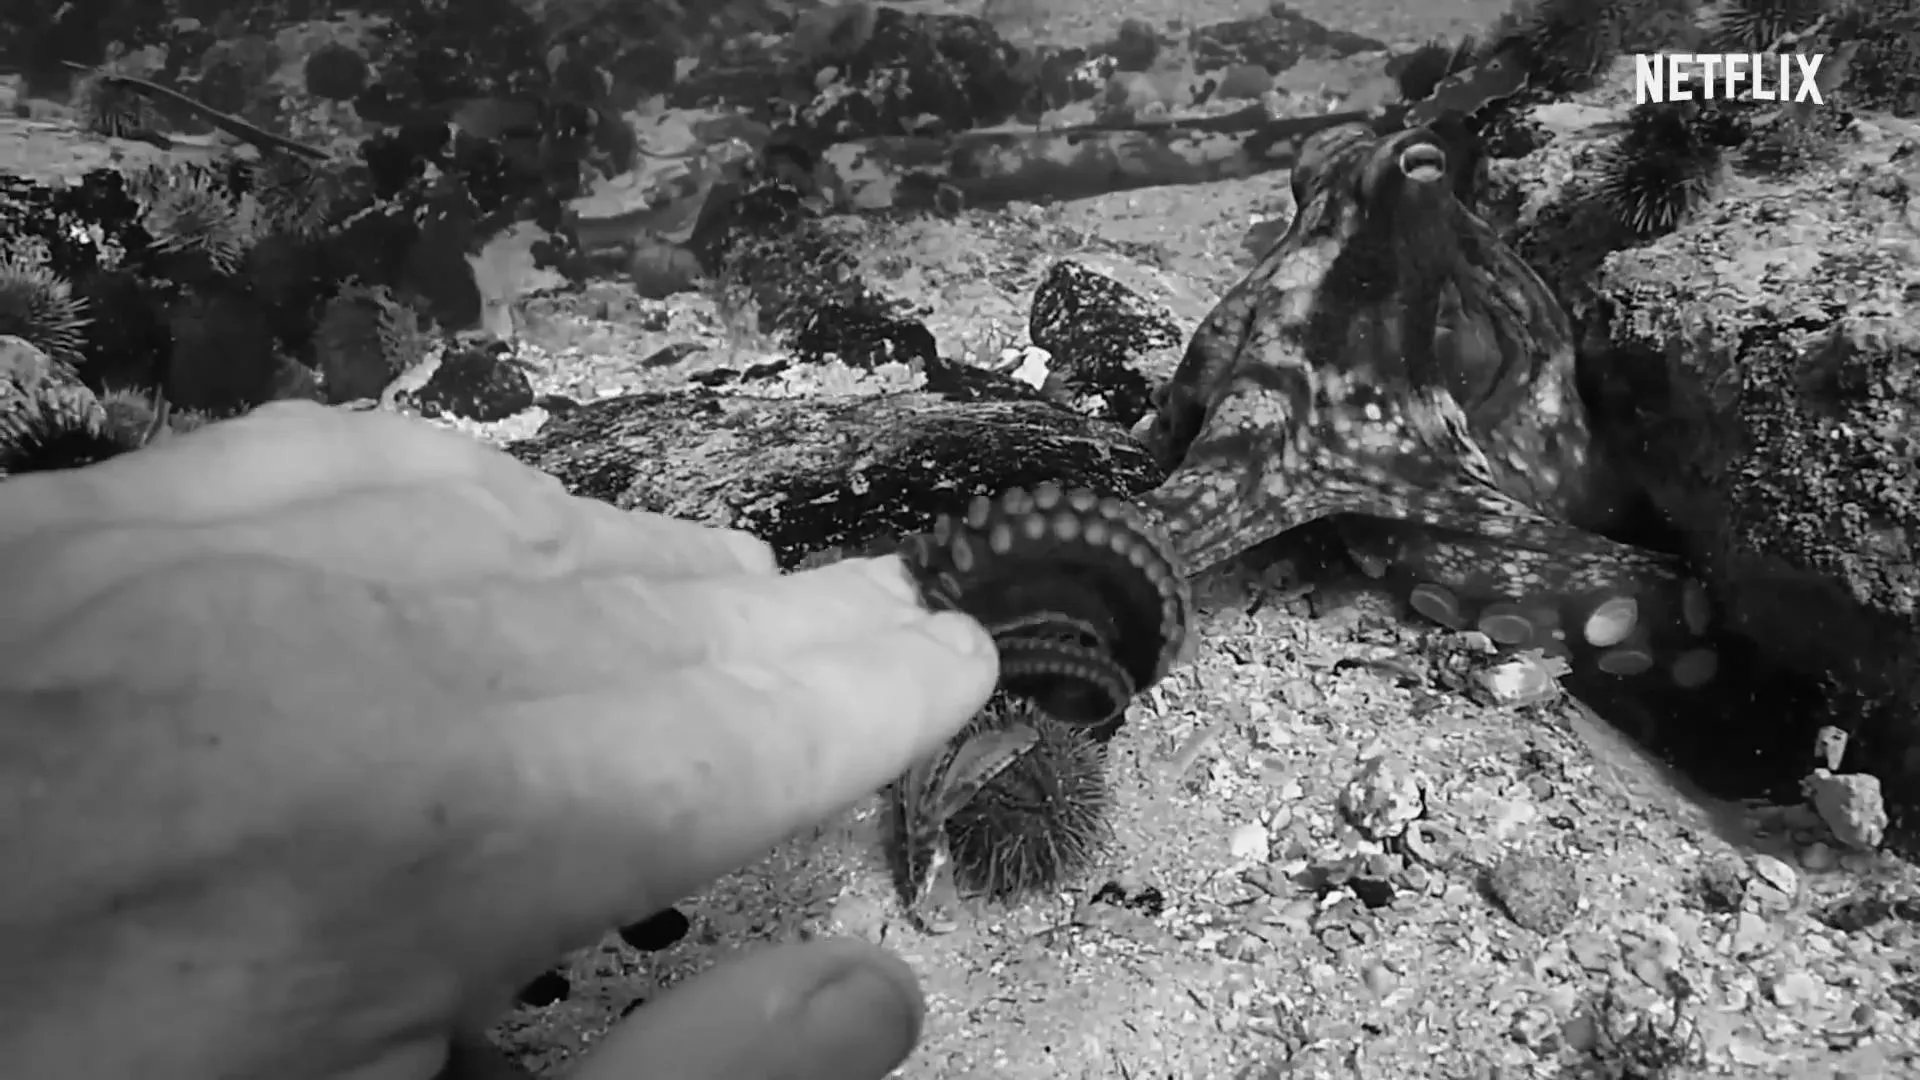
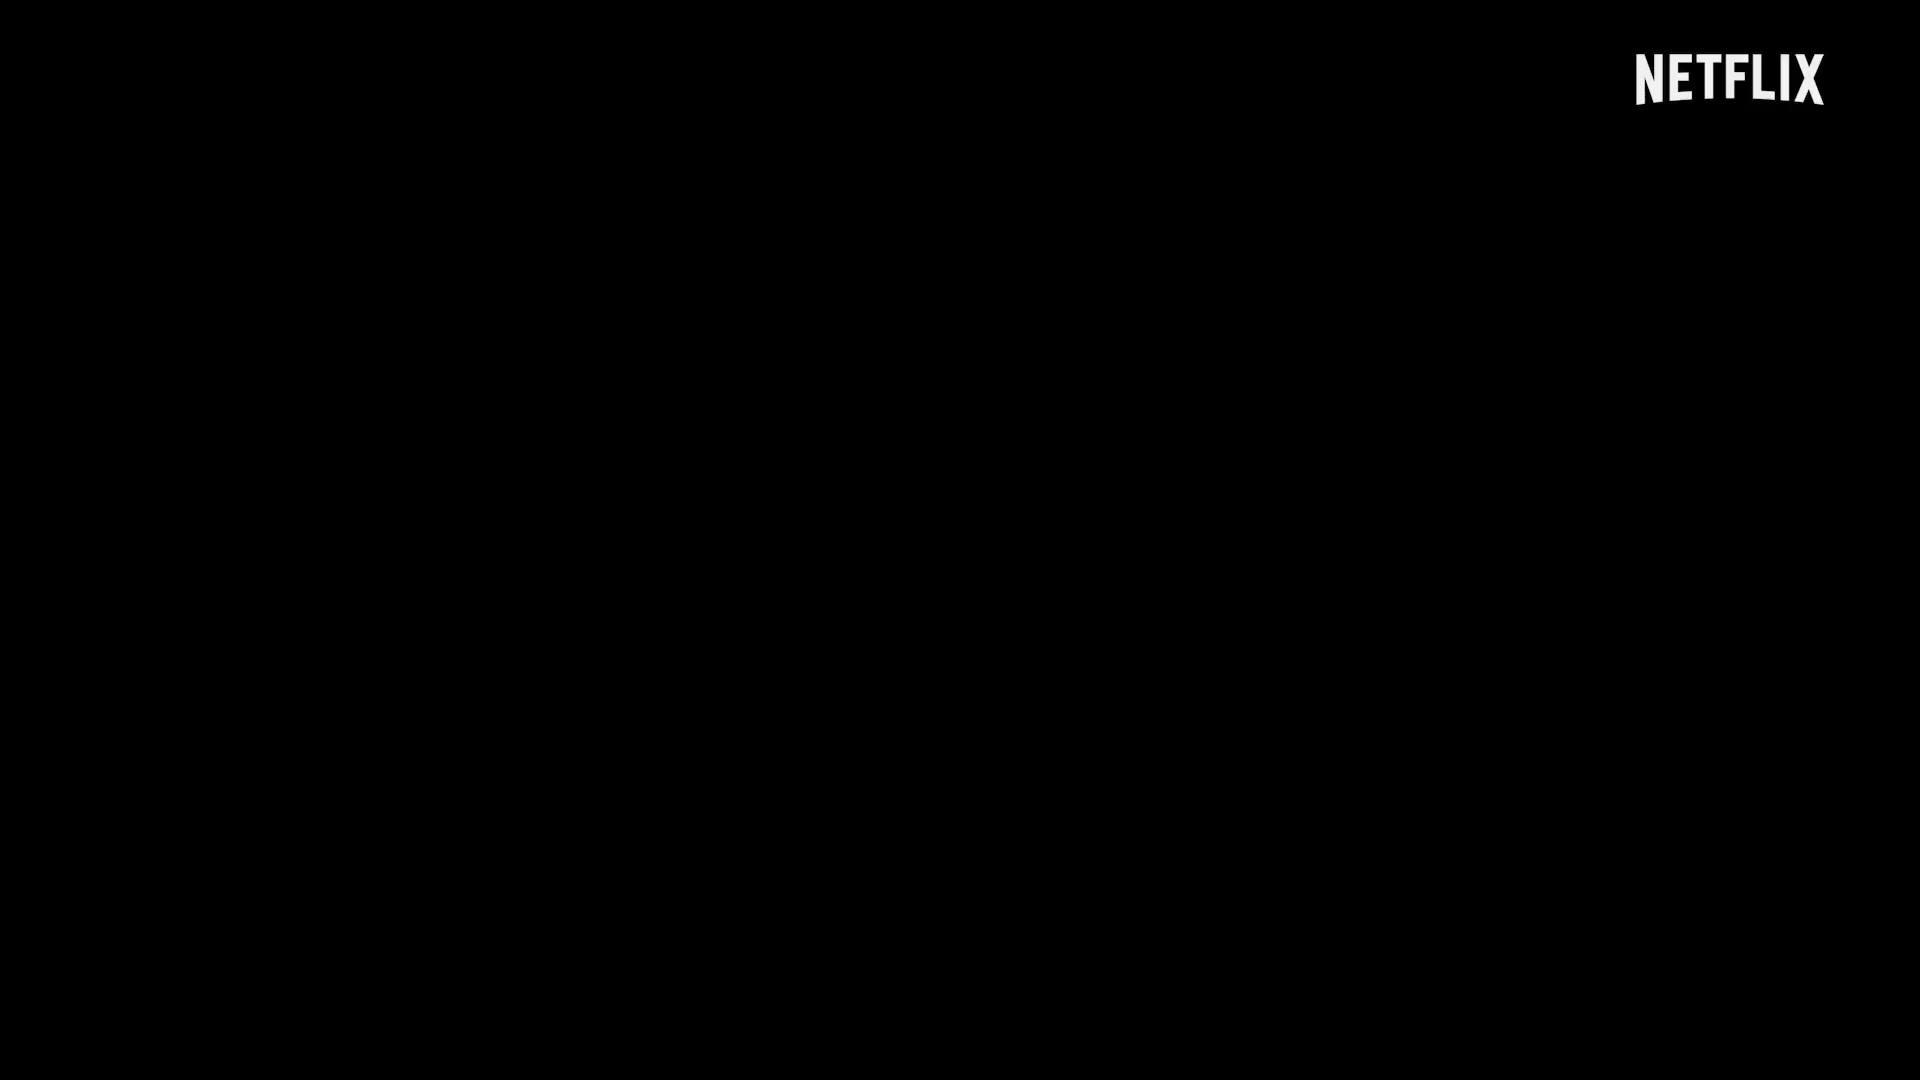
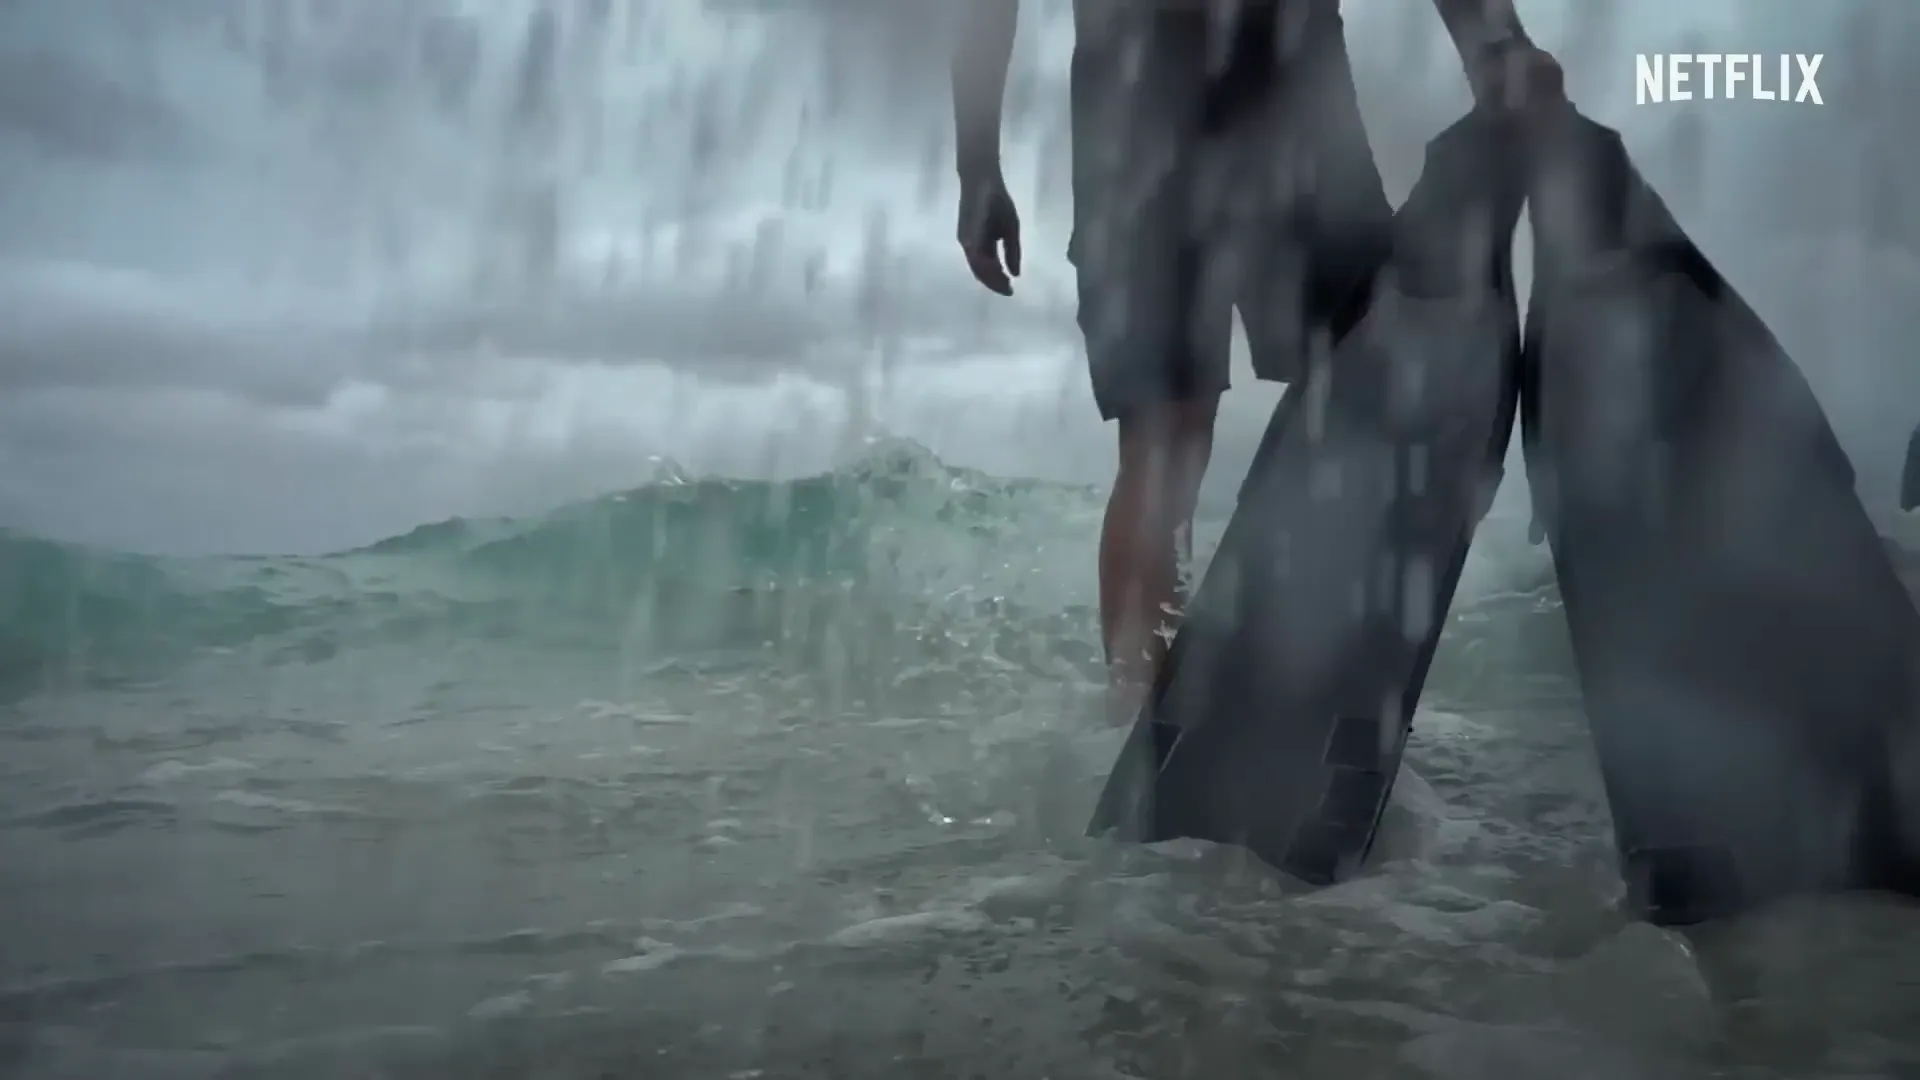
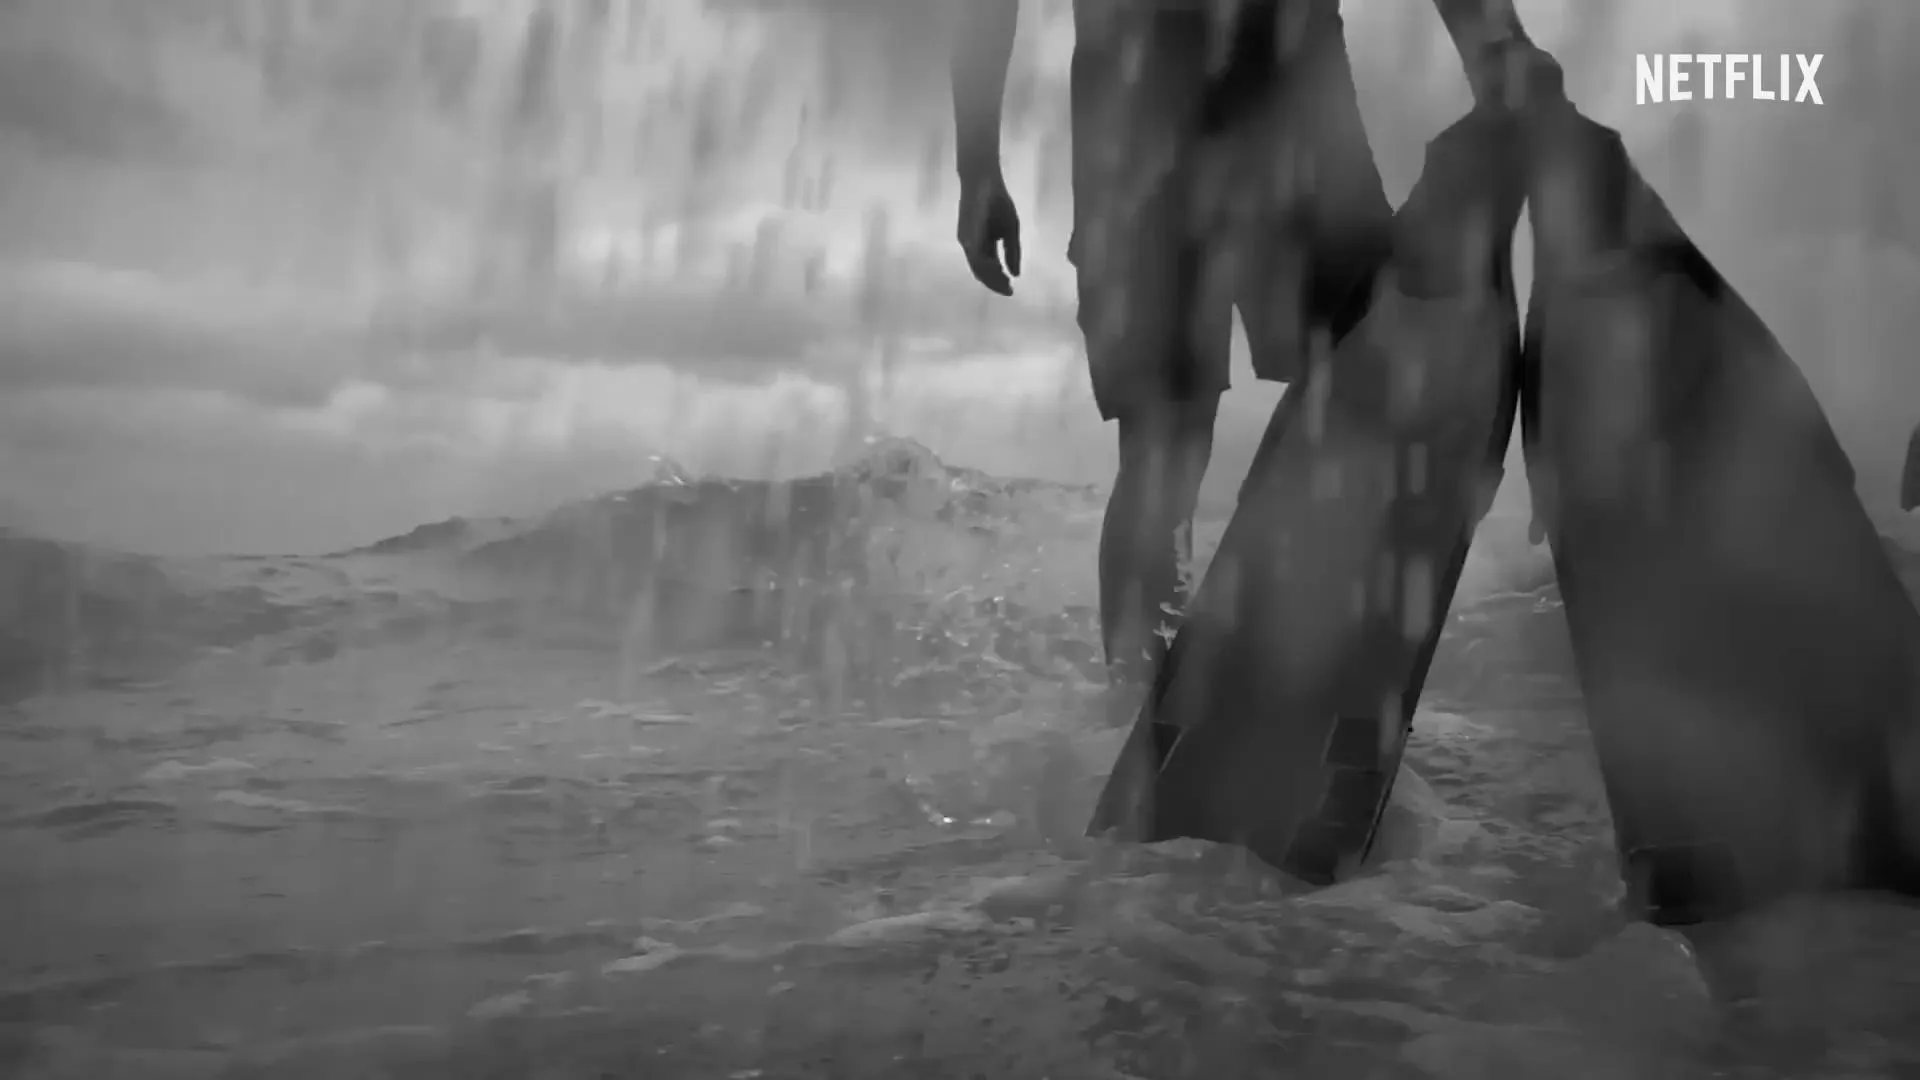
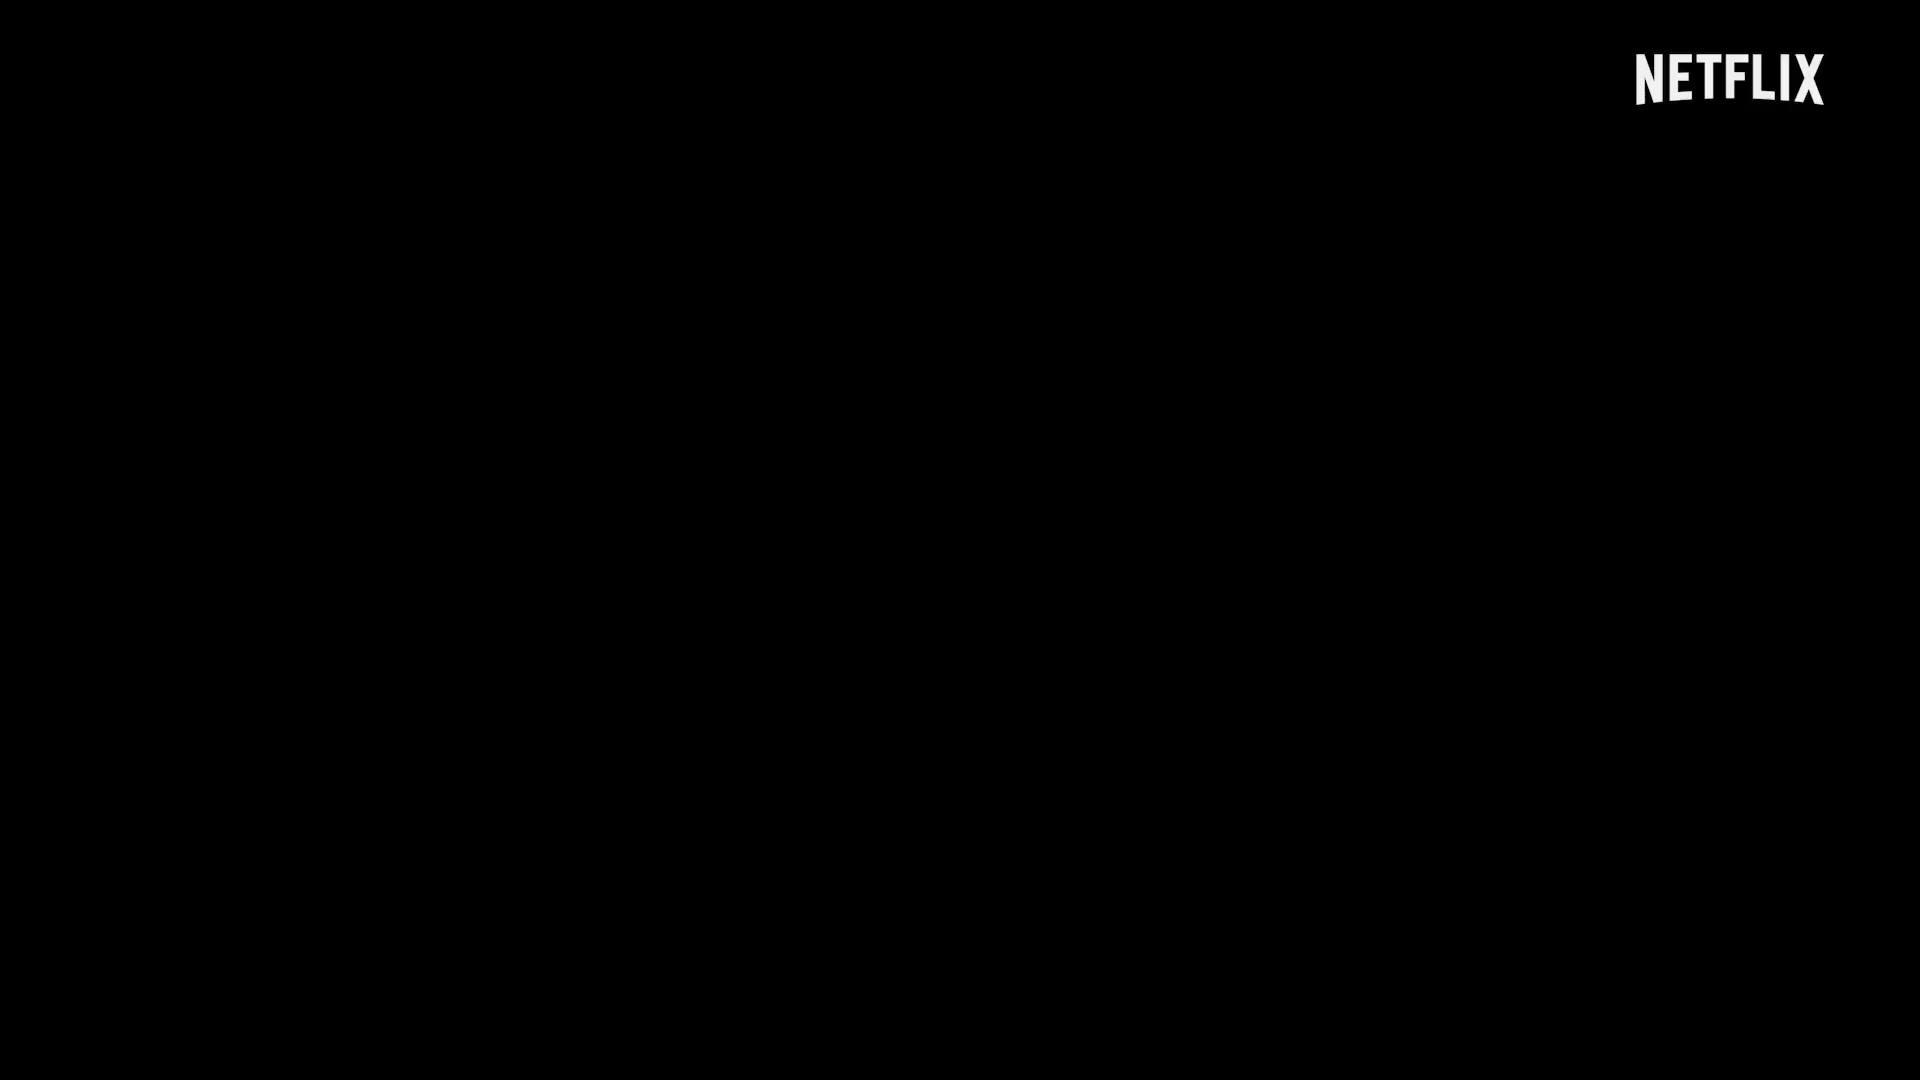

In [17]:
octo_frames_v.head(5)

### Query frames with servable URLs

Query the frames to display them along with their servable file URLs from Backblaze B2.


pos                                           frame_bw  \
0    0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1    1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2    2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3    3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4    4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
5    5  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
6    6  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
7    7  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
8    8  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
9    9  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                    frame_bw_fileurl  
0  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
1  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
2  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
3  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
4  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
5  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
6  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
7  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
8  https://s3.us-east-005.backblazeb2.com/pxt-tes...  
9  https://s3.us-east-005.backblazeb2.com/pxt-tes...
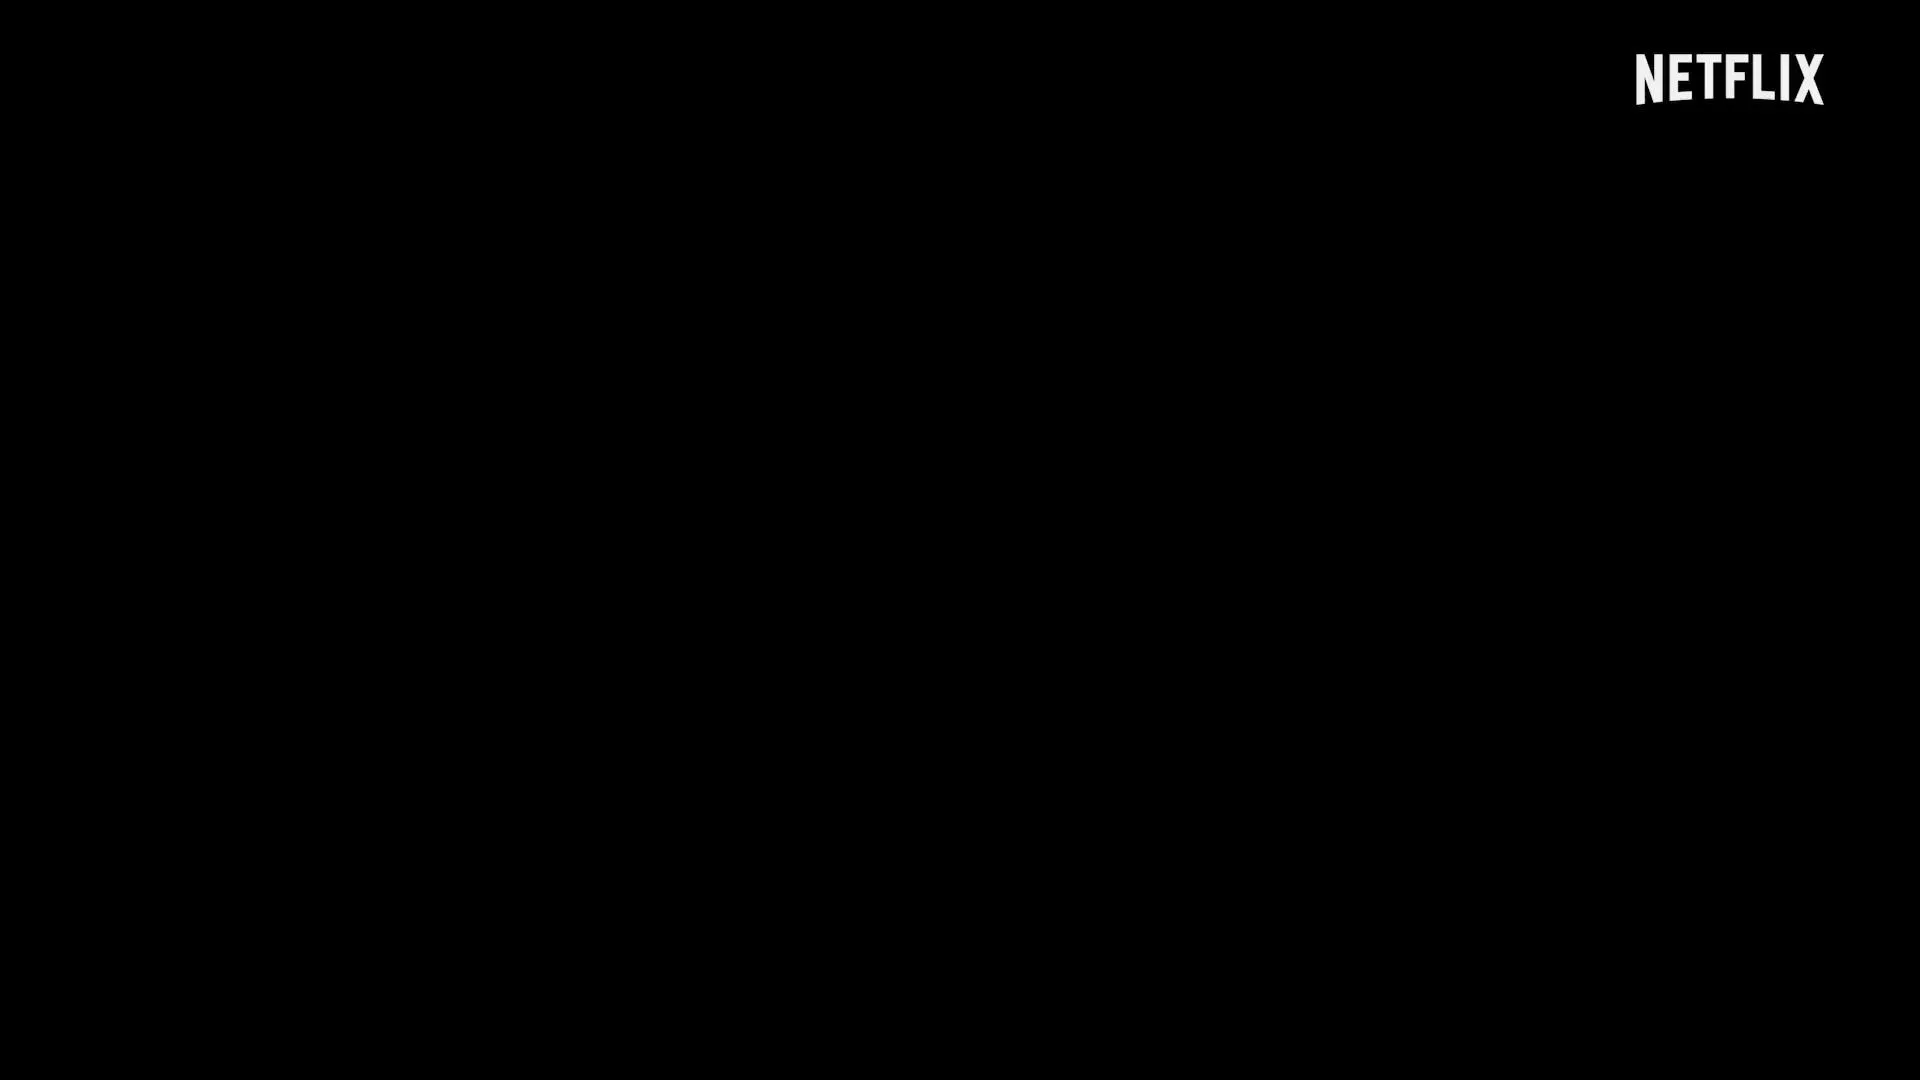
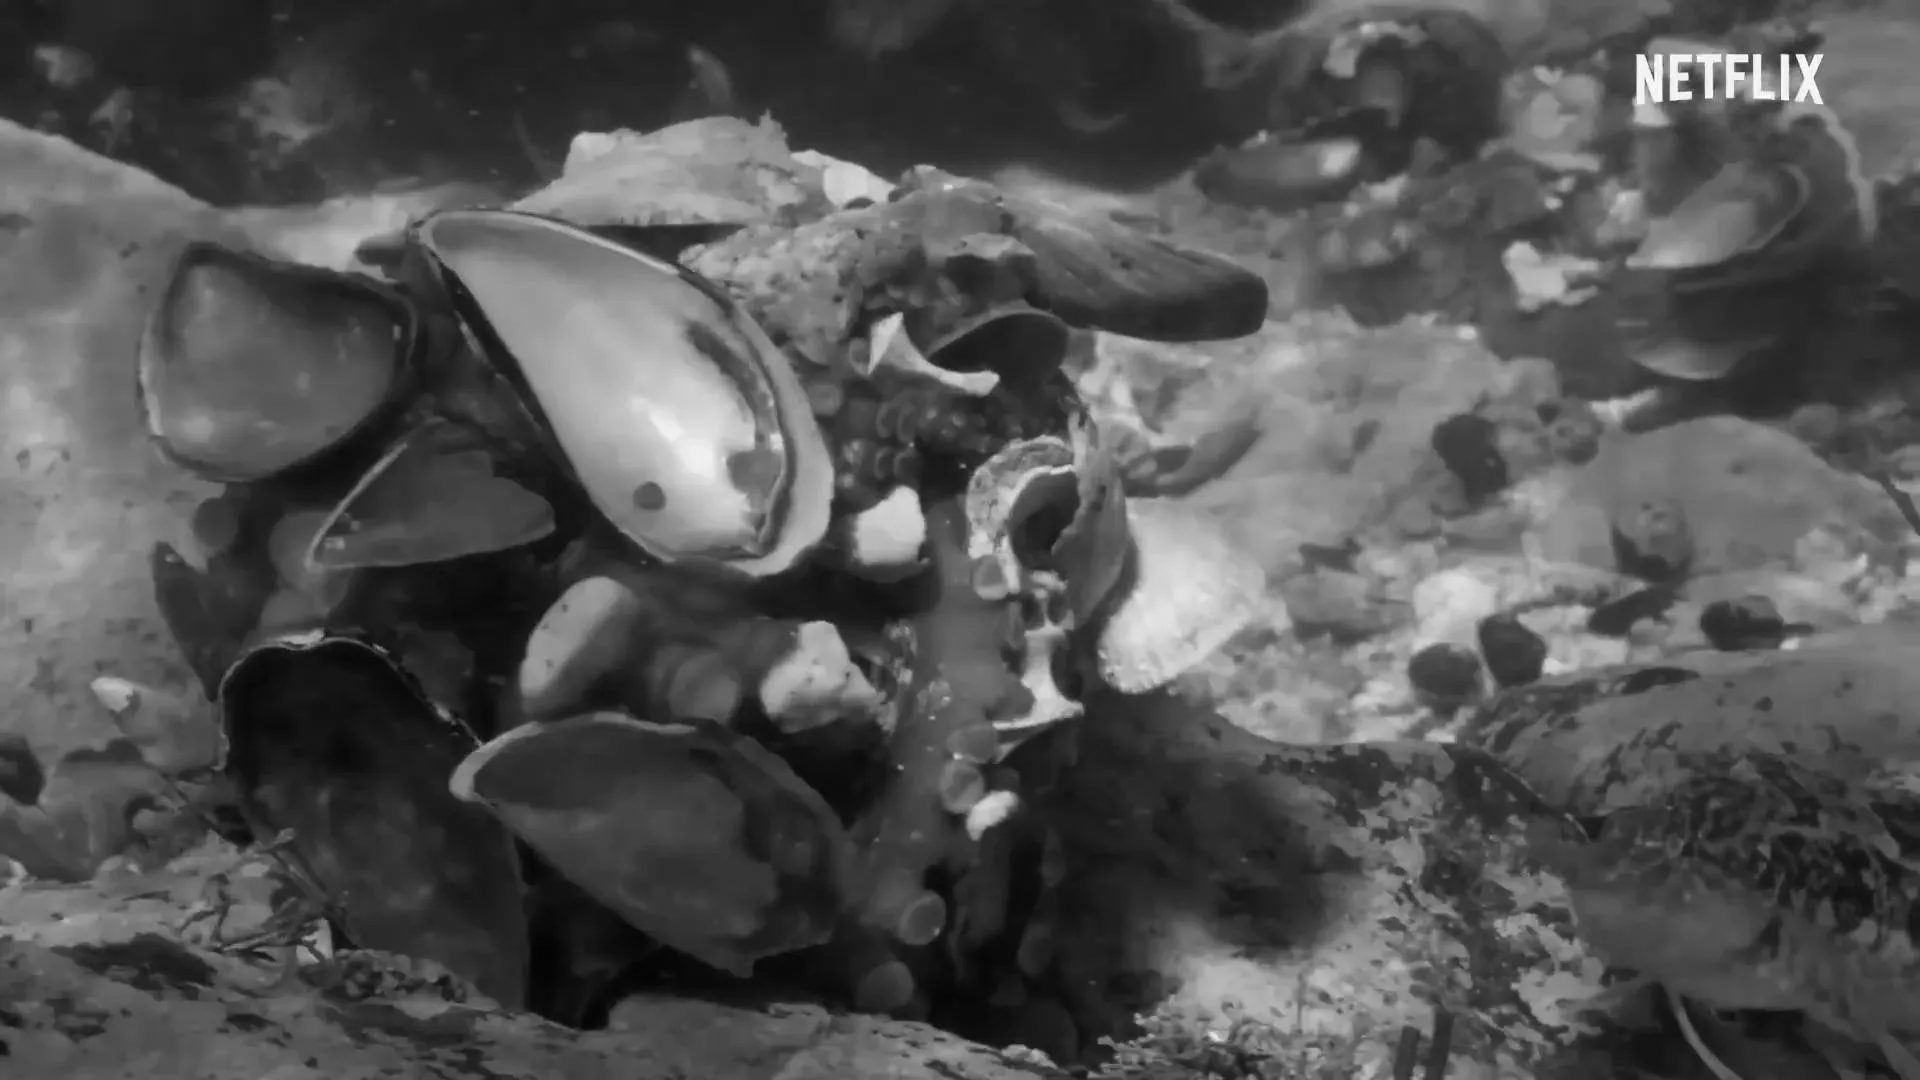
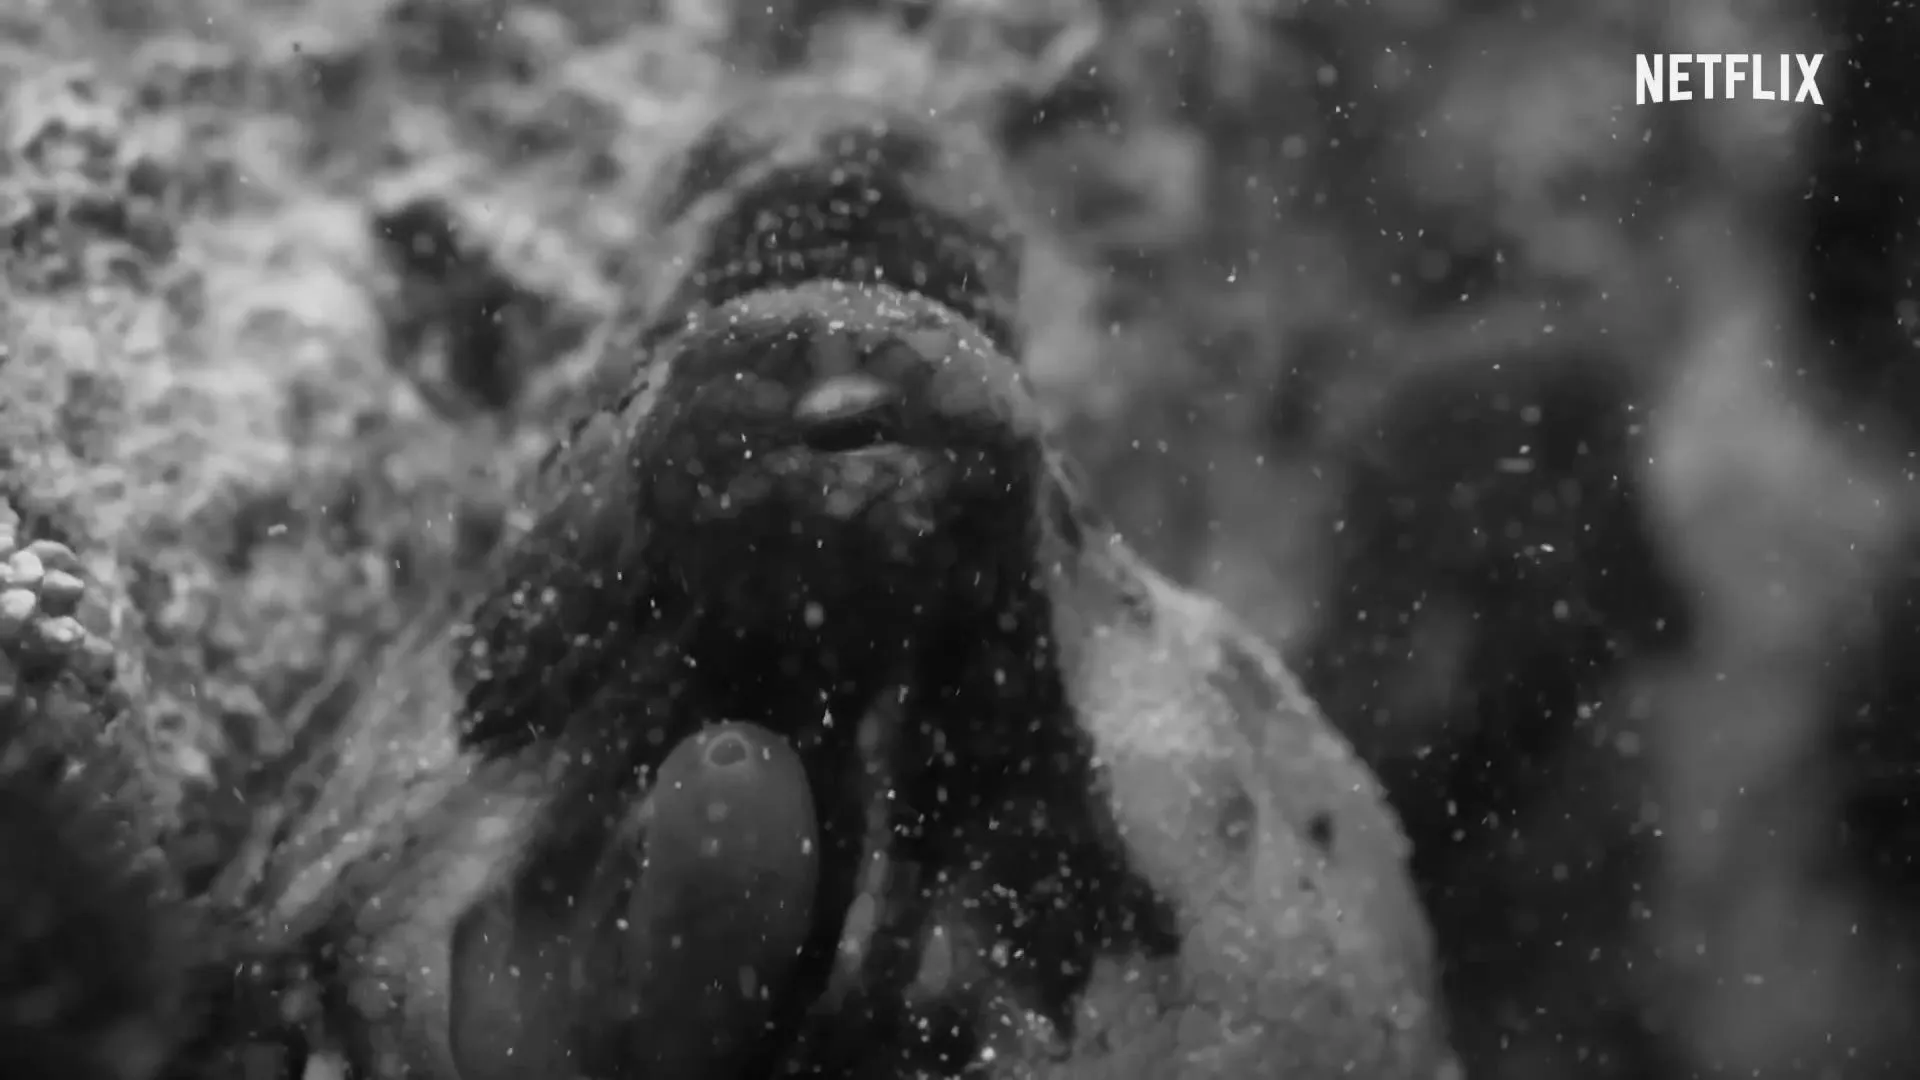
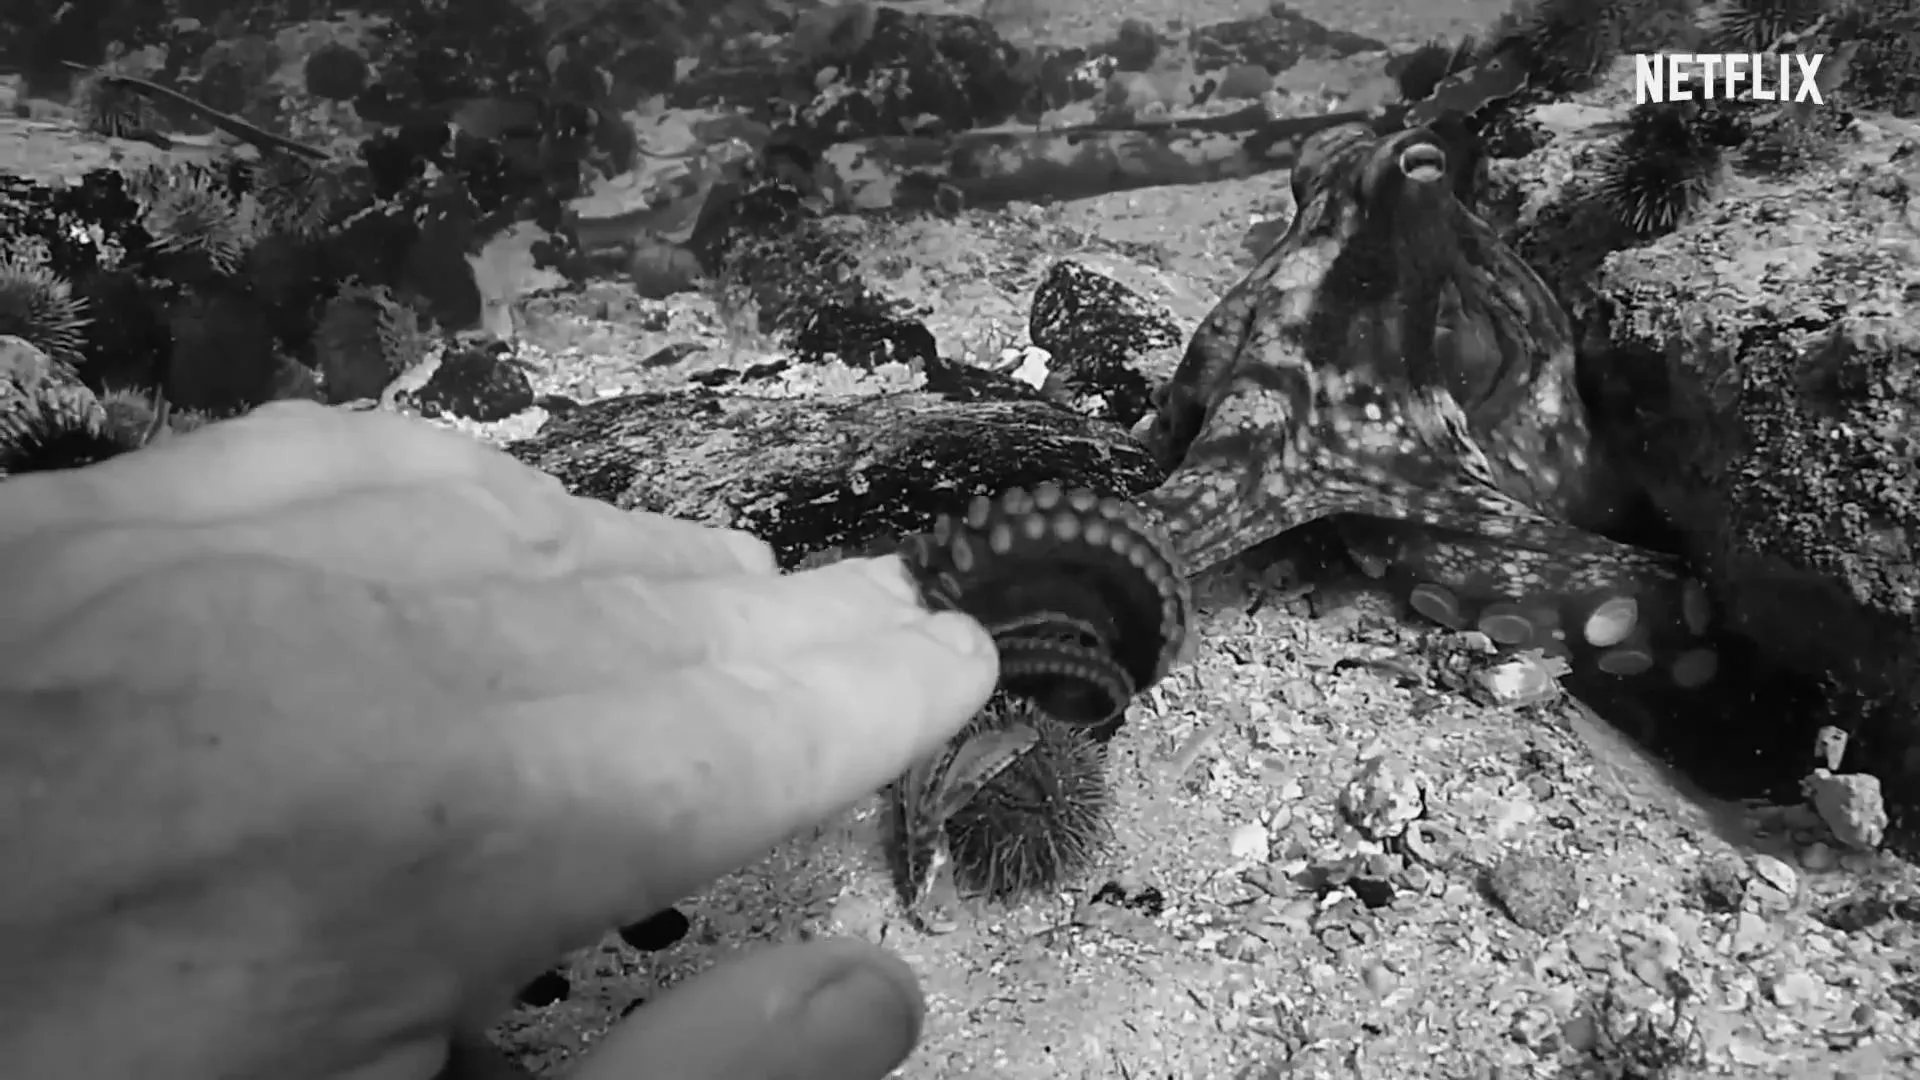
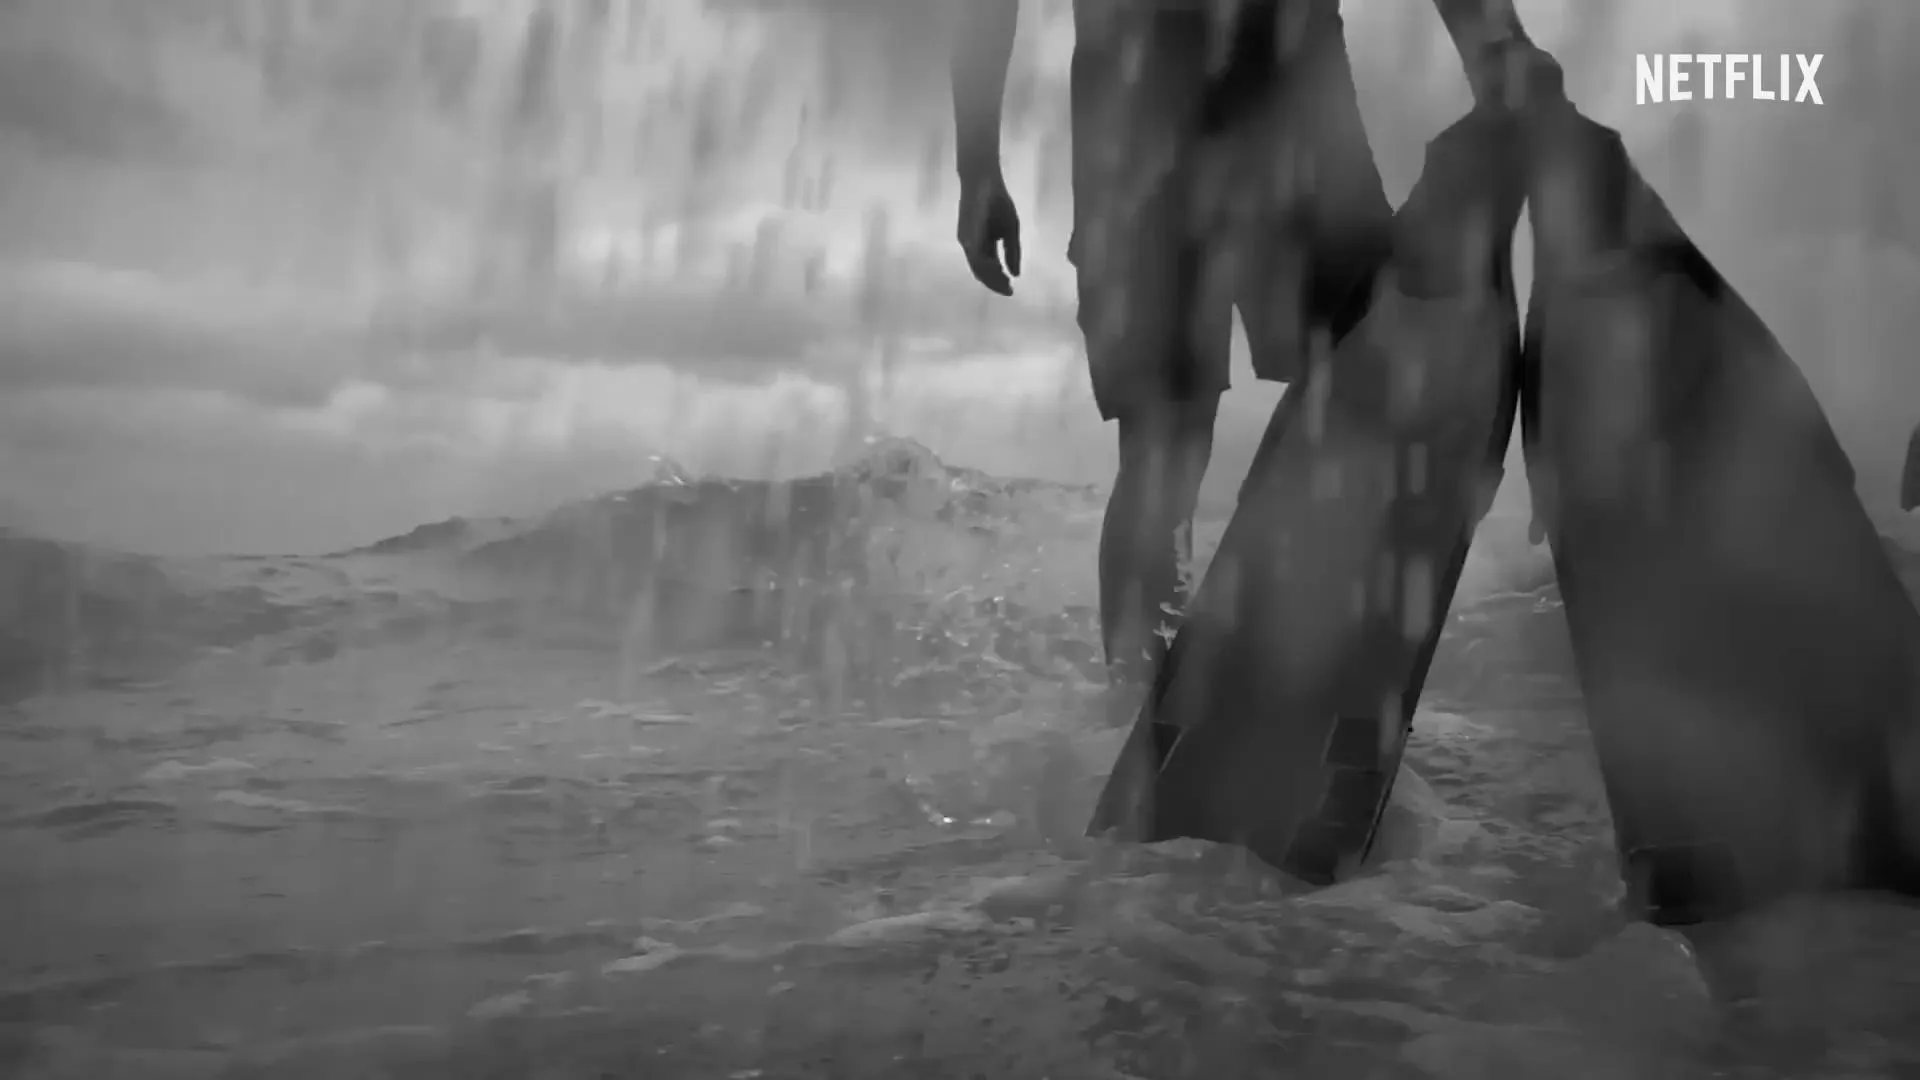
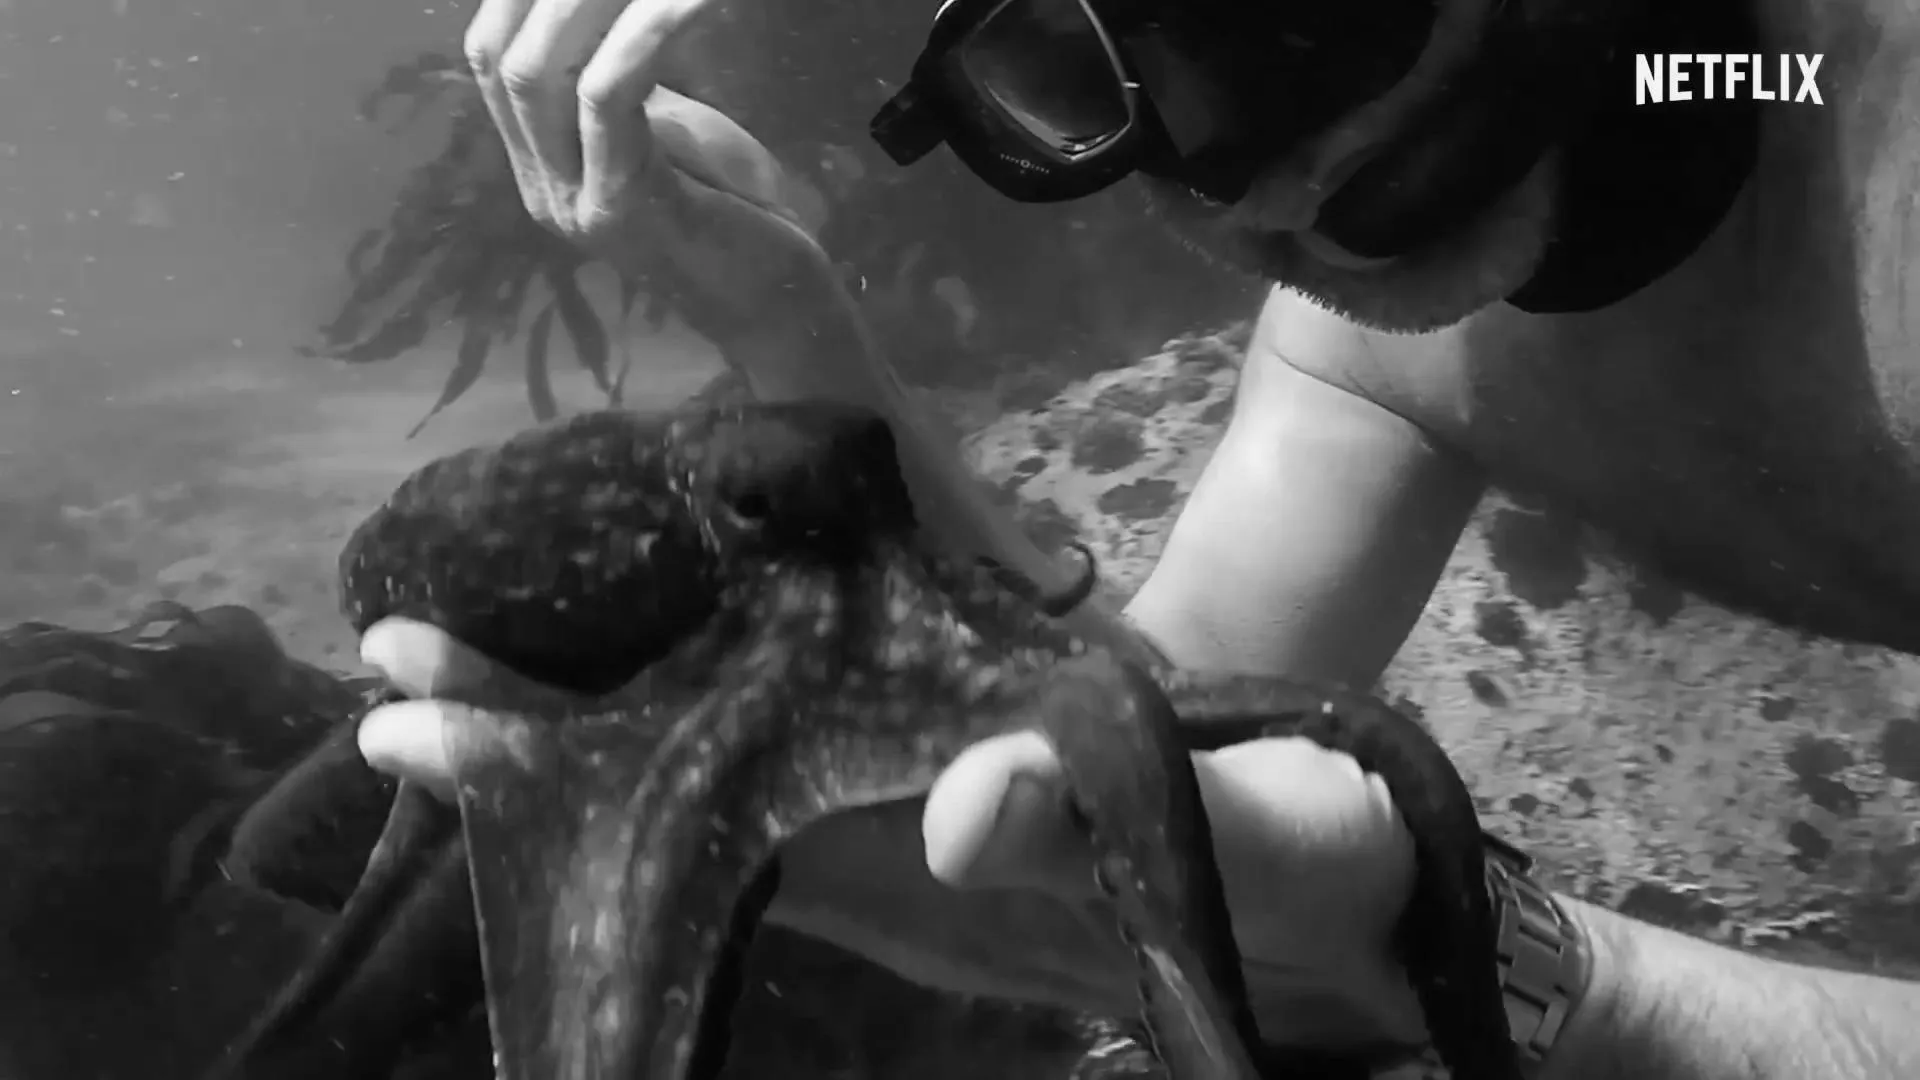
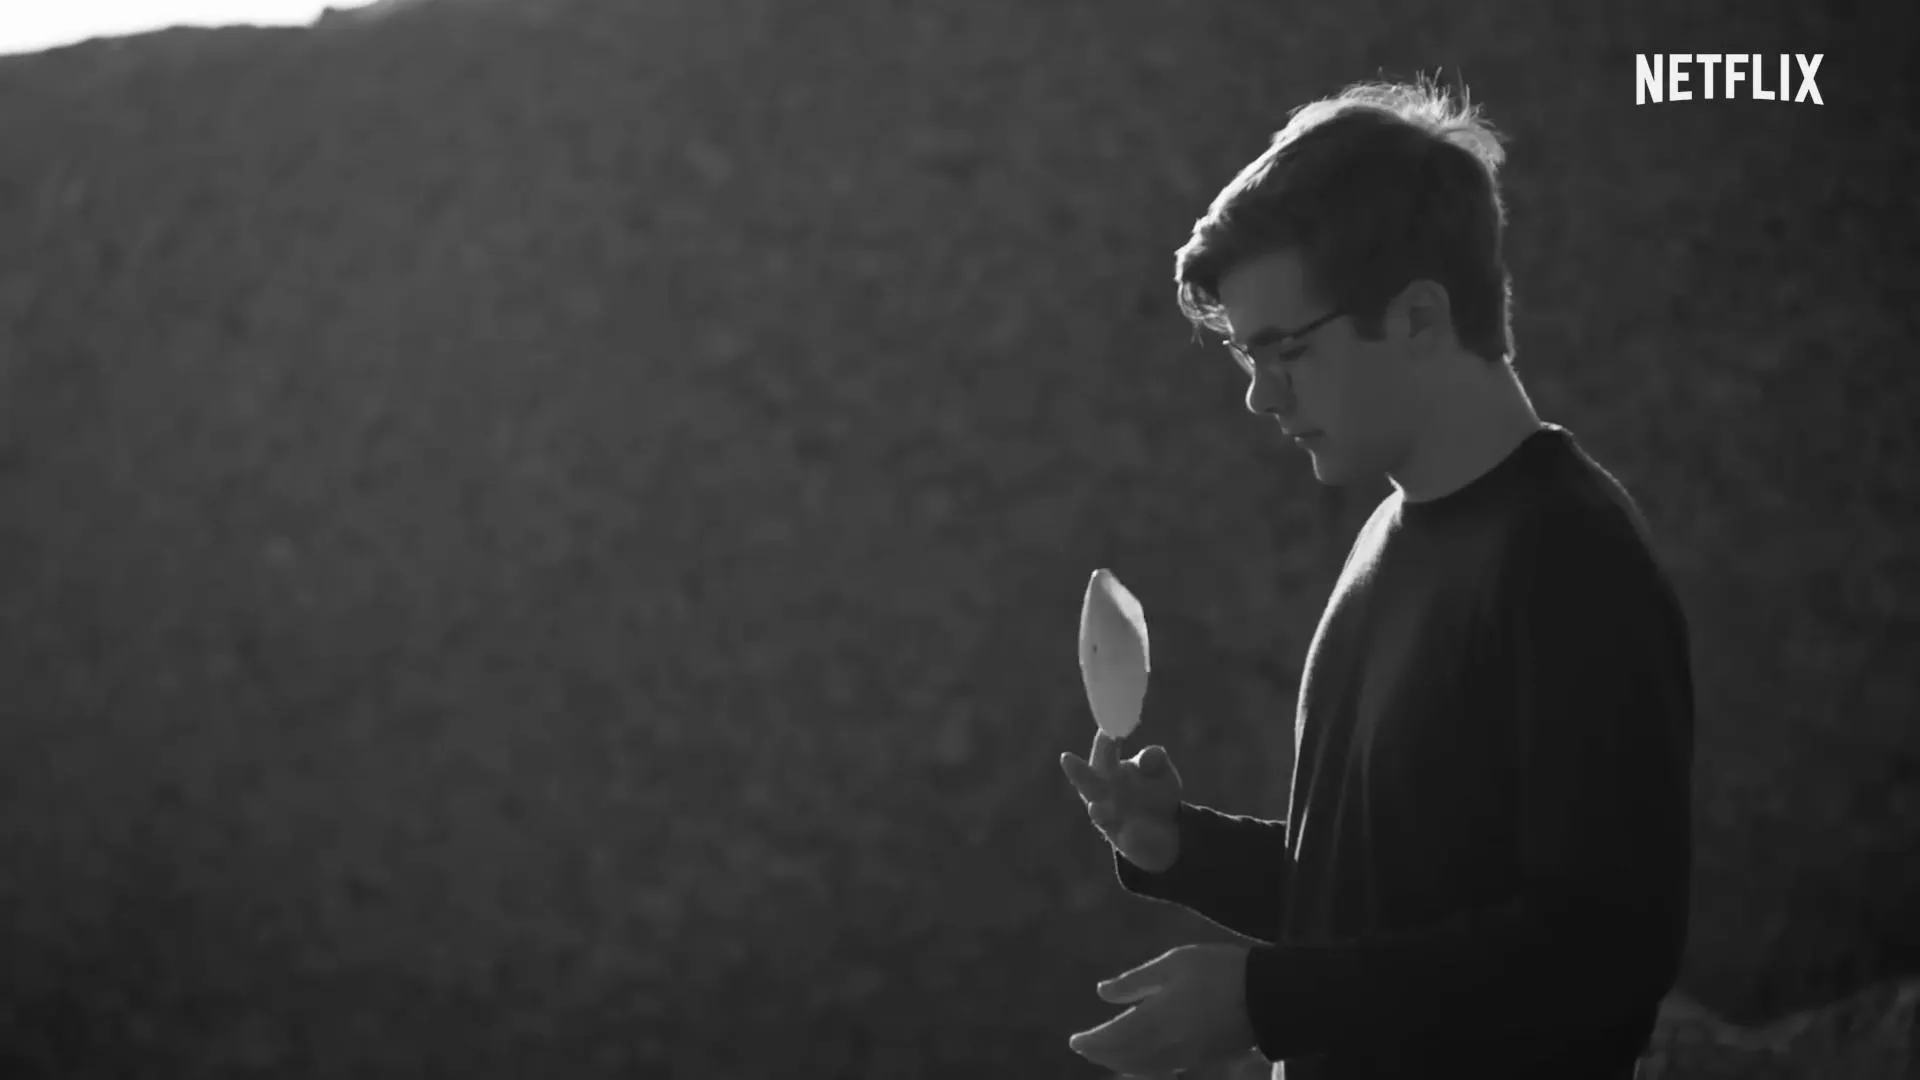
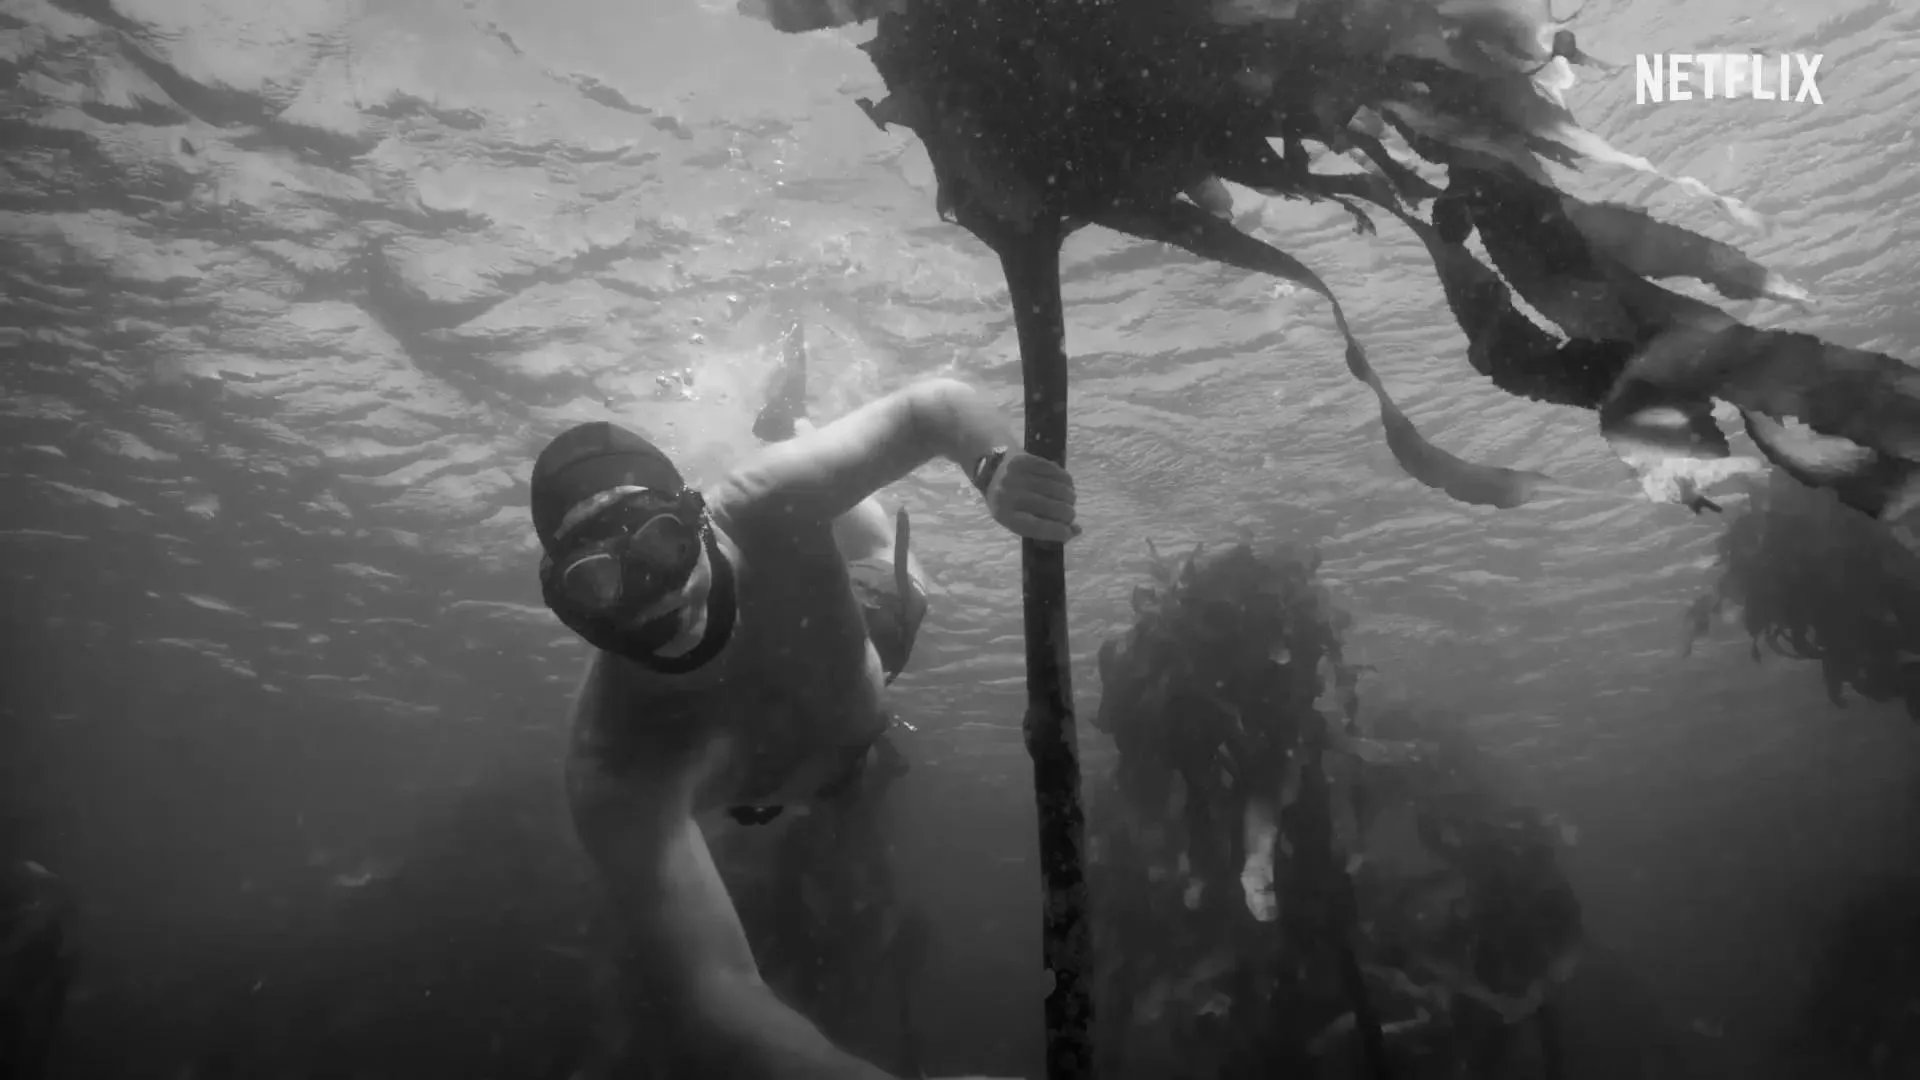
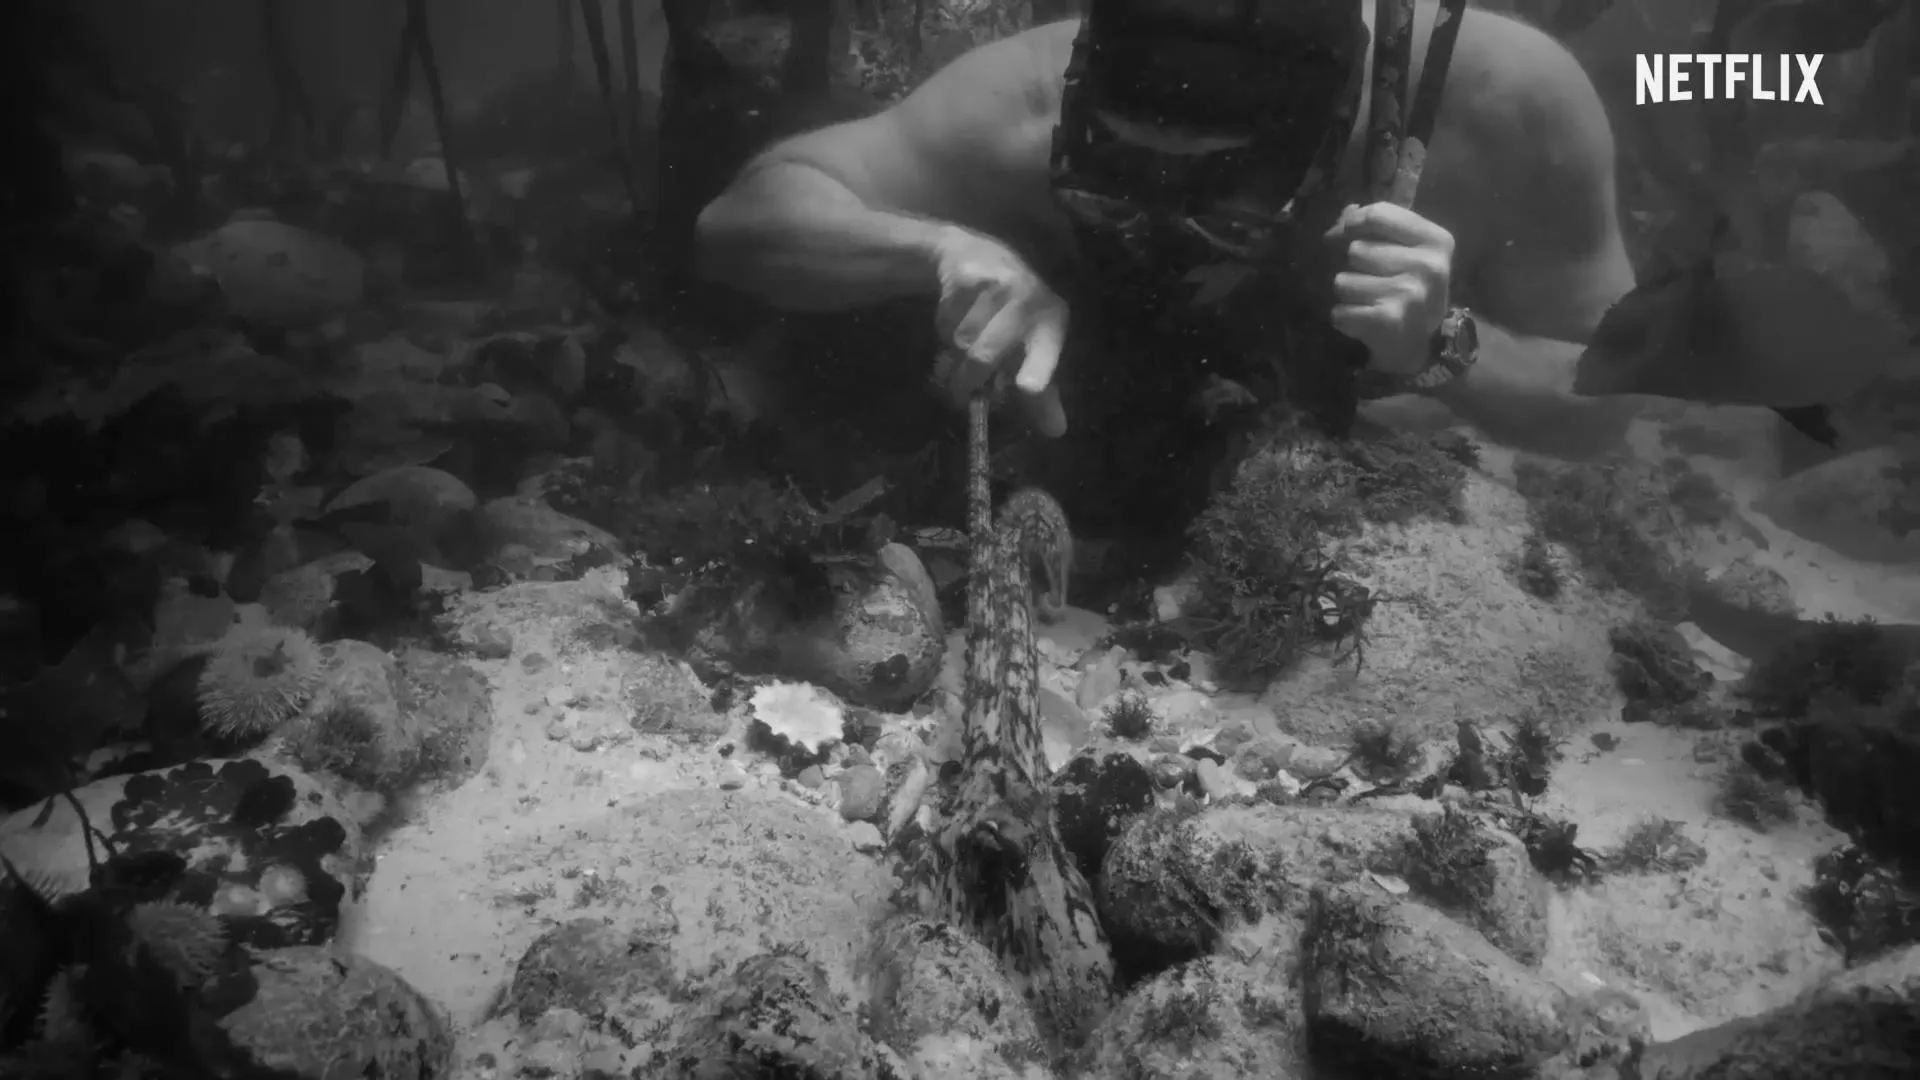
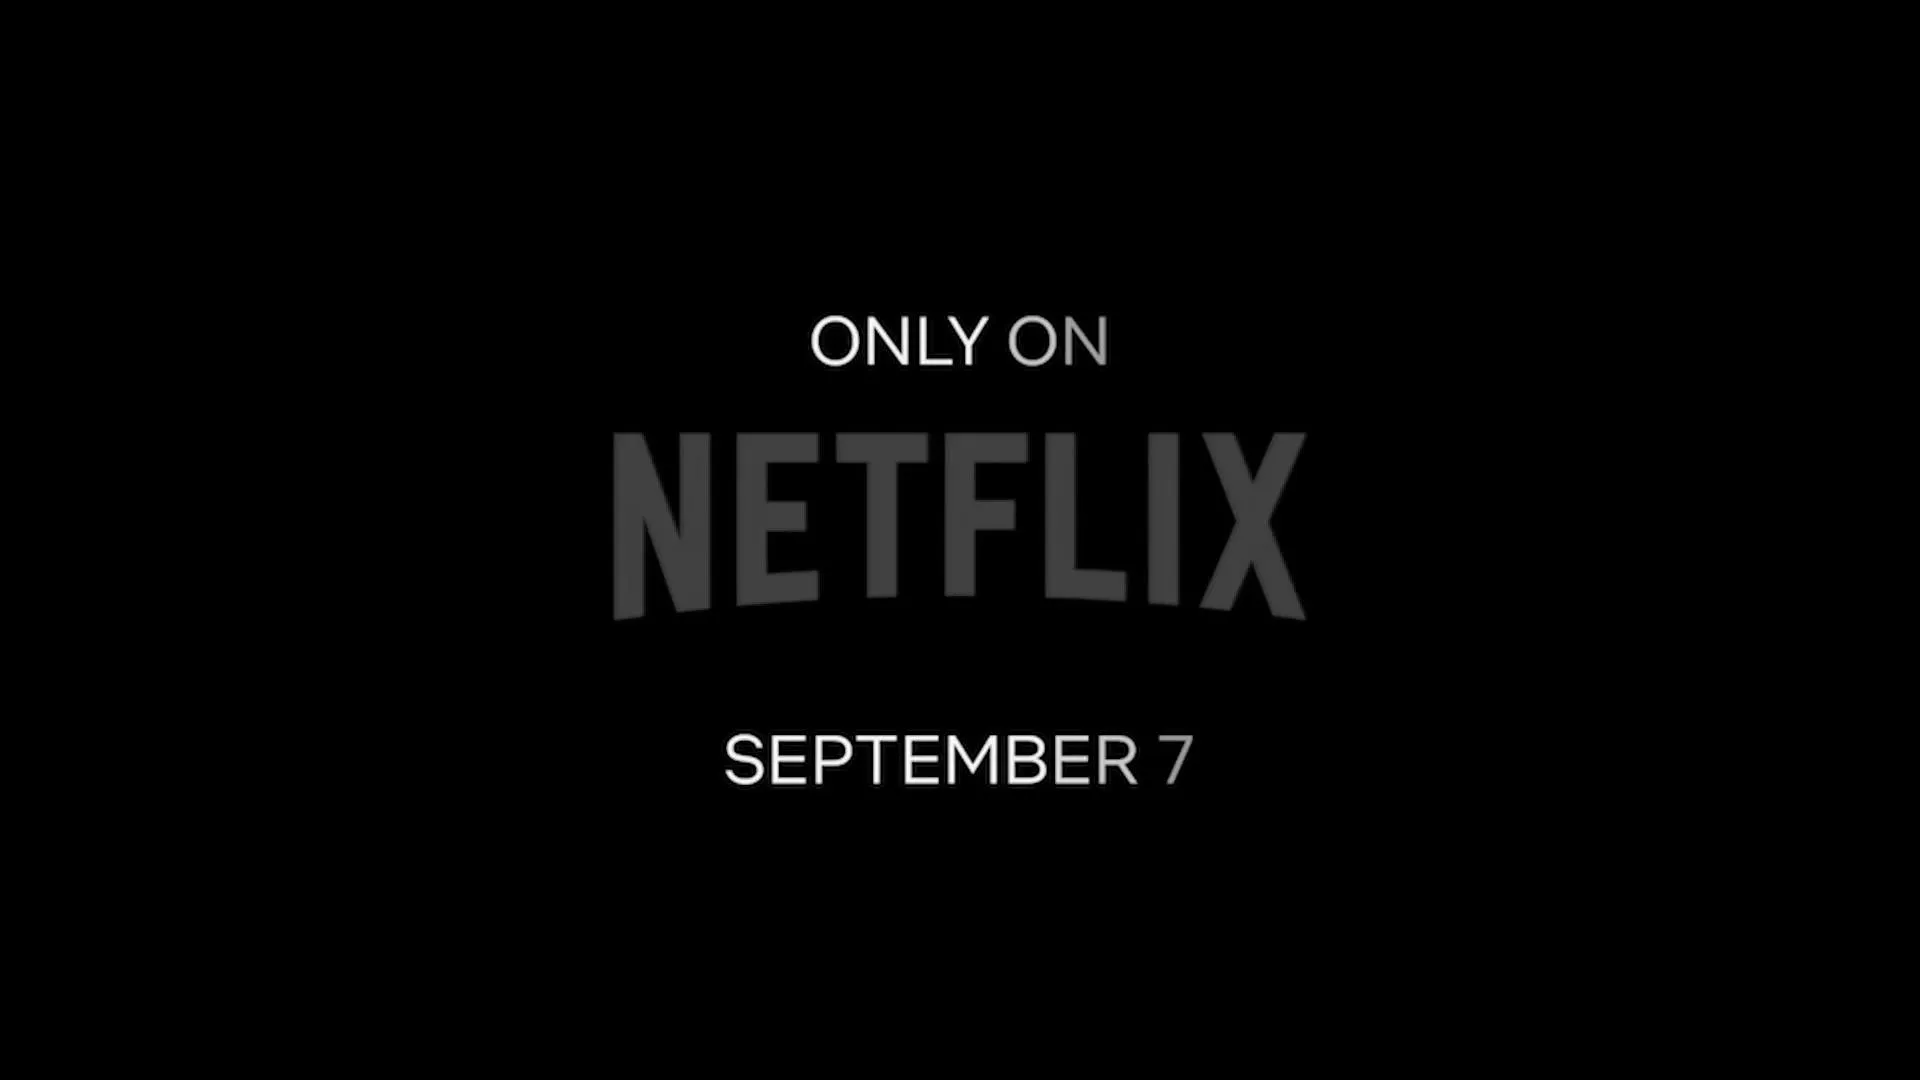

In [18]:
# Query grayscale frames with their B2 URLs
octo_frames_v.select(
    octo_frames_v.pos,
    octo_frames_v.frame_bw,
    octo_frames_v.frame_bw.fileurl
).collect()

## Bonus: Working with Reve in Pixeltable

Pixeltable's Reve integration lets you call Reve's `create`, `edit`, and `remix` endpoints directly from tables so you can iterate on visuals without leaving your data workflows. We'll use edit to take each frame and edit it with the same prompt. In Pixeltable, you can create unique prompts per row as well.

### Documentation

- [Pixeltable Reve Functions](https://docs.pixeltable.com/sdk/latest/reve#module-pixeltable-functions-reve)
- [Reve API Reference](https://api.reve.com/console/docs)

### Prerequisites

- A Reve account with an API key ([https://app.reve.com/](https://app.reve.com/) → Settings → API Keys)

### Important Notes

- Reve usage incurs costs according to your plan—keep an eye on credits.
- Images you send to Reve leave your environment; avoid uploading sensitive or private data.

### Set up Reve API key

In [ ]:
import os
import getpass

if 'REVE_API_KEY' not in os.environ:
    os.environ['REVE_API_KEY'] = getpass.getpass('Reve API Key: ')

In [ ]:
from pixeltable.functions import reve

### Edit frames with Reve

Use Reve's `edit` function to transform the grayscale frames into vibrant underwater scenes. This demonstrates how you can integrate AI image editing directly into your Pixeltable workflows, using B2 storage as your generated media destination.

In [ ]:
octo_frames_v.add_computed_column(
    frame_reve=reve.edit(
        octo_frames_v.frame_bw,
        (
            'Convert every image into a majestic underwater scene with vibrant colors, '
            'rich textures, and if present, focus on the octopus. If there is no octopus, '
            'the image should be misty, wistful, and focus on a sense of reflection. '
            'All images should still look realistic photographs, not imaginary or overly magical.'
        )
    ),
    if_exists='replace',
    destination=f"{B2_ENDPOINT}/{B2_BUCKET}/output/reve/"
)

### View the Reve-edited frames

Compare the original grayscale frames with the Reve-edited versions.

In [ ]:
octo_frames_v.select(octo_frames_v.frame_bw, octo_frames_v.frame_reve).head(5)

### Query Reve-edited frames with servable URLs

View the Reve-edited frames along with their servable file URLs from Backblaze B2.


In [ ]:
# Query Reve-edited frames with their B2 URLs
octo_frames_v.select(
    octo_frames_v.pos,
    octo_frames_v.frame_reve,
    octo_frames_v.frame_reve.fileurl
).collect()